In [69]:
import xarray as xr
import os
import yaml
from datetime import datetime
import glob
import logging
import dask
from tqdm import tqdm
import scipy
import matplotlib.pyplot as plt
import json

In [70]:
ds = xr.open_dataset('data/merged_ds.nc', engine='netcdf4').compute()

In [71]:
hurricane_tracks = json.load(open('hurricane_tracks.json'))

In [72]:
hurricane_names = list(hurricane_tracks.keys())

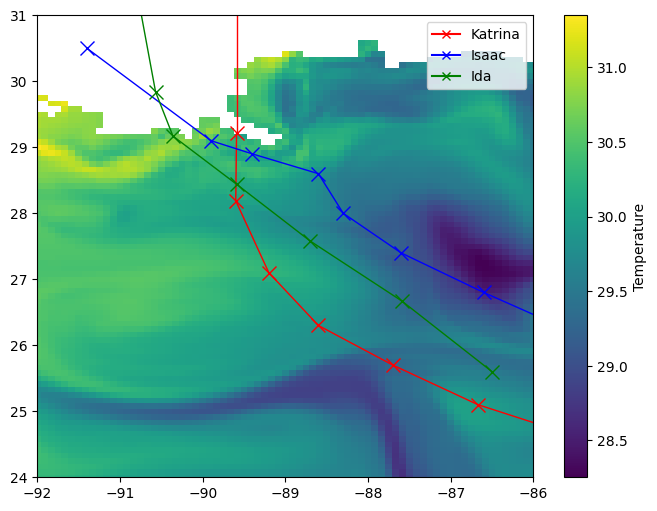

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Select the data for plotting
var = 'thetao'
temperature_data = ds.isel(time=28)[var].values
longitude = ds['longitude'].values
latitude = ds['latitude'].values

# Create a meshgrid for plotting
lon, lat = np.meshgrid(longitude, latitude)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the base temperature map
c = ax.pcolormesh(lon, lat, temperature_data, shading='auto', cmap='viridis')
fig.colorbar(c, ax=ax, label=ds[var].attrs['long_name'])

# Set hard limits on plot extent
ax.set_xlim(longitude.min(), longitude.max())
ax.set_ylim(latitude.min(), latitude.max())

# Plot lines for all hurricanes and points for Katrina
colors = {'katrina': 'r', 'isaac': 'b', 'ida': 'g'}

# Plot lines and points for all hurricanes
for hurricane in hurricane_tracks.keys():
    points = hurricane_tracks[hurricane]['points']
    color = colors[hurricane]

    for i in range(len(points) - 1):
        curr_point = points[i]
        next_point = points[i + 1]

        curr_in_bounds = (longitude.min() <= curr_point['lon'] <= longitude.max() and 
                          latitude.min() <= curr_point['lat'] <= latitude.max())
        next_in_bounds = (longitude.min() <= next_point['lon'] <= longitude.max() and 
                          latitude.min() <= next_point['lat'] <= latitude.max())

        # Draw line if at least one point is in bounds
        if curr_in_bounds or next_in_bounds:
            ax.plot([curr_point['lon'], next_point['lon']], 
                    [curr_point['lat'], next_point['lat']], color=color, linestyle='-', linewidth=1)

        # Plot 'x' marker for current point if in bounds
        if curr_in_bounds:
            ax.plot(curr_point['lon'], curr_point['lat'], marker='x', color=color, markersize=10)

    # Also plot the final point if in bounds
    final_point = points[-1]
    if (longitude.min() <= final_point['lon'] <= longitude.max() and 
        latitude.min() <= final_point['lat'] <= latitude.max()):
        ax.plot(final_point['lon'], final_point['lat'], marker='x', color=color, markersize=10)

# Fix legend
legend_handles = [plt.Line2D([0], [0], color=color, marker='x', linestyle='-', label=name.capitalize())
                  for name, color in colors.items()]
ax.legend(handles=legend_handles, loc='upper right')



In [74]:
no_hurricane_years = [2006,2013,2015]
hurricane_years = [2005,2012,2021]

In [75]:
def get_latlon_within_radius(ds, hurricane_tracks, name, radius_deg):
    """
    Returns a list of (lat, lon) tuples from the dataset grid that fall within a 
    given radius (in degrees) of any hurricane point in the track.

    Parameters:
        ds (xr.Dataset): Dataset with 'latitude' and 'longitude' coordinates.
        hurricane_tracks (dict): Hurricane tracks.
        name (str): Hurricane name in hurricane_tracks.
        radius_deg (float): Radius in degrees (approximately 111 km per degree).

    Returns:
        List[Tuple[float, float]]: List of (lat, lon) coordinates in the radius.
    """
    from math import radians, cos, sin, sqrt, atan2

    def haversine(lat1, lon1, lat2, lon2):
        R = 6371  # Earth radius in km
        dlat = radians(lat2 - lat1)
        dlon = radians(lon2 - lon1)
        a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
        return 2 * R * atan2(sqrt(a), sqrt(1 - a))

    max_km = radius_deg * 111  # Convert degrees to approximate kilometers

    lat_vals = ds.latitude.values
    lon_vals = ds.longitude.values

    lat_grid, lon_grid = np.meshgrid(lat_vals, lon_vals, indexing='ij')
    latlon_list = []

    for p in hurricane_tracks[name]['points']:
        for i in range(lat_grid.shape[0]):
            for j in range(lon_grid.shape[1]):
                dist_km = haversine(p['lat'], p['lon'], lat_grid[i, j], lon_grid[i, j])
                if dist_km <= max_km:
                    latlon_list.append((lat_grid[i, j], lon_grid[i, j]))

    return list(set(latlon_list))  # Remove duplicates

def create_radius_mask_ds(ds, latlon_points):
    """
    Create a deep copy of ds, and set all bottomT values at (lat, lon) positions to -1,
    for all time steps, without modifying the original dataset.
    """
    ds_radius = ds.copy()
    lat_vals = ds.latitude.values
    lon_vals = ds.longitude.values

    # Create a boolean mask over the (lat, lon) grid
    mask = np.zeros((len(lat_vals), len(lon_vals)), dtype=bool)
    for lat, lon in latlon_points:
        lat_idx = np.where(np.isclose(lat_vals, lat))[0]
        lon_idx = np.where(np.isclose(lon_vals, lon))[0]
        if lat_idx.size > 0 and lon_idx.size > 0:
            mask[lat_idx[0], lon_idx[0]] = True

    # Broadcast mask over time
    full_mask = np.broadcast_to(mask, ds['thetao'].shape)

    # Deep copy of the data before modification
    arr = ds_radius['thetao'].values.copy()
    arr[full_mask] = -1
    ds_radius['thetao'].values = arr

    return ds_radius
def extract_ds_grouped_by_time(ds, latlon_points, years):
    """
    Extracts all variables at specified (lat, lon) positions for all time steps in given years.
    Returns a Dataset with dimensions (time, points) and no lat/lon dims.
    Ensures consistent 'points' size across all variables.

    Parameters:
        ds (xr.Dataset): Dataset with 'time', 'latitude', 'longitude', and variables.
        latlon_points (List[Tuple[float, float]]): List of (lat, lon) positions to extract.
        years (Union[int, List[int]]): Year or list of years to extract data for.

    Returns:
        xr.Dataset: Dataset with shape (time, points) for each variable.
    """
    # Ensure years is a list
    if isinstance(years, int):
        years = [years]

    # Select all time steps in the specified years
    ds_years = ds.sel(time=ds['time'].dt.year.isin(years))
    time_vals = ds_years['time'].values

    lat_vals = ds.latitude.values
    lon_vals = ds.longitude.values

    # Find (lat_idx, lon_idx) pairs
    index_pairs = []
    for lat, lon in latlon_points:
        lat_idx = np.where(np.isclose(lat_vals, lat))[0]
        lon_idx = np.where(np.isclose(lon_vals, lon))[0]
        if lat_idx.size > 0 and lon_idx.size > 0:
            index_pairs.append((lat_idx[0], lon_idx[0]))

    # Store values per variable, per time
    variable_data = {}
    global_max_len = 0

    for var_name in ds.data_vars:
        var_array = ds_years[var_name].values  # shape: (time, lat, lon)
        all_values = []

        for t_idx in range(len(time_vals)):
            values_t = []
            for lat_idx, lon_idx in index_pairs:
                val = var_array[t_idx, lat_idx, lon_idx]
                if not np.isnan(val):
                    values_t.append(val)
            all_values.append(values_t)
            global_max_len = max(global_max_len, len(values_t))

        variable_data[var_name] = all_values

    # Build padded arrays
    data_vars = {}
    for var_name, value_lists in variable_data.items():
        padded = np.full((len(time_vals), global_max_len), np.nan)
        for i, row in enumerate(value_lists):
            padded[i, :len(row)] = row
        data_vars[var_name] = (["time", "points"], padded)

    return xr.Dataset(
        data_vars=data_vars,
        coords=dict(time=("time", time_vals))
    )


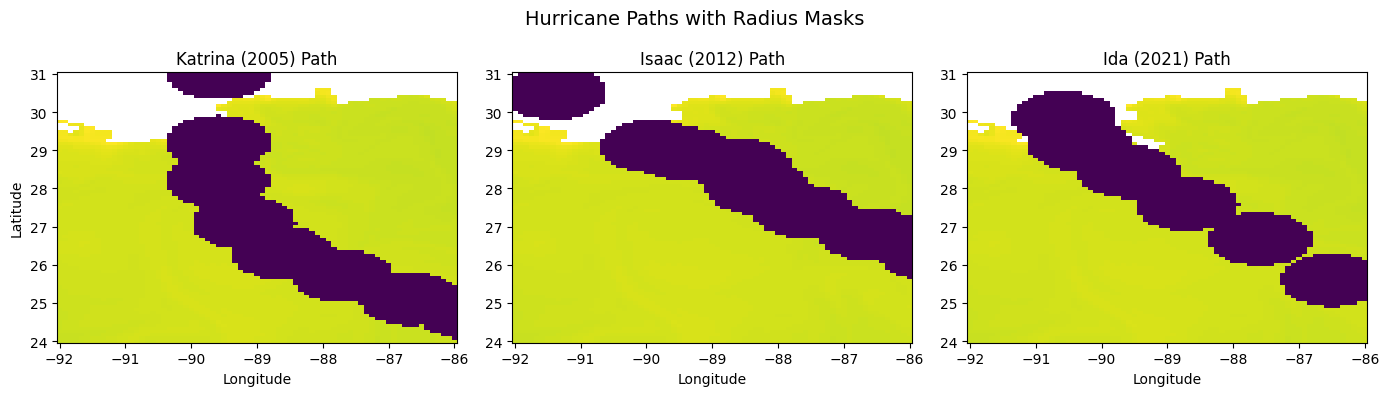

In [76]:
# Create a figure with three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Hurricane Paths with Radius Masks', fontsize=14)

for i, hurricane in enumerate(hurricane_names):
    latlon_points = get_latlon_within_radius(ds, hurricane_tracks, hurricane, radius_deg=0.7)
    ds_radius = create_radius_mask_ds(ds, latlon_points)
    
    # Plot on the corresponding subplot
    data = ds_radius.isel(time=0)['thetao']
    im = axes[i].pcolormesh(data.longitude, data.latitude, data, shading='auto')
    year = hurricane_tracks[hurricane]['year']
    axes[i].set_title(f'{hurricane.title()} ({year}) Path')
    axes[i].set_xlabel('Longitude')
    if i == 0:  # Only show y-label on leftmost plot
        axes[i].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

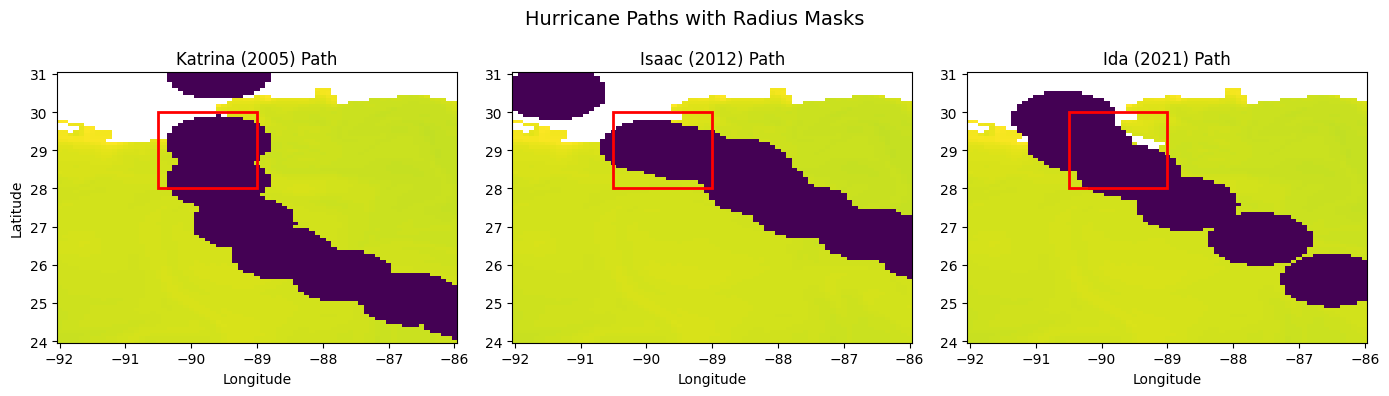

In [77]:
# Create a figure with three subplots side by side
redbox = {
    'latmin': 28,
    'latmax': 30,
    'lonmin': -90.5,
    'lonmax': -89
}

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Hurricane Paths with Radius Masks', fontsize=14)

for i, hurricane in enumerate(hurricane_names):
    latlon_points = get_latlon_within_radius(ds, hurricane_tracks, hurricane, radius_deg=0.7)
    ds_radius = create_radius_mask_ds(ds, latlon_points)
    
    # Plot on the corresponding subplot
    data = ds_radius.isel(time=0)['thetao']
    im = axes[i].pcolormesh(data.longitude, data.latitude, data, shading='auto')
    
    # Add red box
    rect = plt.Rectangle((redbox['lonmin'], redbox['latmin']), 
                        redbox['lonmax'] - redbox['lonmin'],
                        redbox['latmax'] - redbox['latmin'],
                        fill=False, color='red', linewidth=2)
    axes[i].add_patch(rect)
    
    year = hurricane_tracks[hurricane]['year']
    axes[i].set_title(f'{hurricane.title()} ({year}) Path')
    axes[i].set_xlabel('Longitude')
    if i == 0:  # Only show y-label on leftmost plot
        axes[i].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

In [78]:
# Create datasets for redbox area during hurricane and non-hurricane years
redbox = {
    'latmin': 28,
    'latmax': 30,
    'lonmin': -90.5,
    'lonmax': -89
}

# Filter data for redbox area
ds_redbox = ds.sel(
    latitude=slice(redbox['latmin'], redbox['latmax']),
    longitude=slice(redbox['lonmin'], redbox['lonmax'])
)

# Get hurricane years
hurricane_years = set(track['year'] for track in hurricane_tracks.values())

# Create masks for hurricane and non-hurricane years
hurricane_mask = ds_redbox.time.dt.year.isin(list(hurricane_years))
non_hurricane_mask = ~hurricane_mask

# Create separate datasets
ds_hurricane_years = ds_redbox.sel(time=hurricane_mask)
ds_non_hurricane_years = ds_redbox.sel(time=non_hurricane_mask)

In [116]:
# Filter data for redbox area
ds_redbox = ds.copy()

# Get hurricane years
hurricane_years = set(track['year'] for track in hurricane_tracks.values())

# Create masks for hurricane and non-hurricane years
hurricane_mask = ds_redbox.time.dt.year.isin(list(hurricane_years))
non_hurricane_mask = ~hurricane_mask

# Create separate datasets
ds_hurricane_years_big = ds_redbox.sel(time=hurricane_mask)
ds_non_hurricane_years_big = ds_redbox.sel(time=non_hurricane_mask)

In [118]:
ds_hurricane_years_big

<xarray.Dataset> Size: 192MB
Dimensions:    (latitude: 85, longitude: 73, time: 276)
Coordinates:
  * latitude   (latitude) float32 340B 24.0 24.08 24.17 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 292B -92.0 -91.92 -91.83 ... -86.08 -86.0
  * time       (time) datetime64[ns] 2kB 2005-08-01 2005-08-02 ... 2021-10-31
Data variables: (12/17)
    bottomT    (time, latitude, longitude) float64 14MB 3.894 3.894 ... nan nan
    mlotst     (time, latitude, longitude) float64 14MB 10.99 10.68 ... nan nan
    siconc     (time, latitude, longitude) float64 14MB nan nan nan ... nan nan
    sithick    (time, latitude, longitude) float64 14MB nan nan nan ... nan nan
    so         (time, latitude, longitude) float64 14MB 36.72 36.7 ... nan nan
    thetao     (time, latitude, longitude) float64 14MB 29.63 29.64 ... nan nan
    ...         ...
    chl        (time, latitude, longitude) float32 7MB 0.08365 0.08365 ... nan
    no3        (time, latitude, longitude) float32 7MB 0.00923 0.00923 ... nan
    nppv       (time, latitude, longitude) float32 7MB 1.267 1.267 ... nan nan
    o2         (time, latitude, longitude) float32 7MB 197.2 197.2 ... nan nan
    po4        (time, latitude, longitude) float32 7MB 3.827e-05 ... nan
    si         (time, latitude, longitude) float32 7MB 4.216 4.216 ... nan nan
Attributes:
    source:                    MERCATOR GLORYS12V1
    comment:                   CMEMS product
    title:                     daily mean fields from Global Ocean Physics An...
    references:                http://www.mercator-ocean.fr
    Conventions:               CF-1.4
    history:                   2023/06/01 16:20:05 MERCATOR OCEAN Netcdf crea...
    institution:               MERCATOR OCEAN
    copernicusmarine_version:  2.0.0

In [119]:
ds_non_hurricane_years_big

<xarray.Dataset> Size: 192MB
Dimensions:    (latitude: 85, longitude: 73, time: 276)
Coordinates:
  * latitude   (latitude) float32 340B 24.0 24.08 24.17 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 292B -92.0 -91.92 -91.83 ... -86.08 -86.0
  * time       (time) datetime64[ns] 2kB 2006-08-01 2006-08-02 ... 2015-10-31
Data variables: (12/17)
    bottomT    (time, latitude, longitude) float64 14MB 3.891 3.891 ... nan nan
    mlotst     (time, latitude, longitude) float64 14MB 18.62 18.62 ... nan nan
    siconc     (time, latitude, longitude) float64 14MB nan nan nan ... nan nan
    sithick    (time, latitude, longitude) float64 14MB nan nan nan ... nan nan
    so         (time, latitude, longitude) float64 14MB 36.44 36.45 ... nan nan
    thetao     (time, latitude, longitude) float64 14MB 29.71 29.72 ... nan nan
    ...         ...
    chl        (time, latitude, longitude) float32 7MB 0.08112 0.08112 ... nan
    no3        (time, latitude, longitude) float32 7MB 0.003067 0.003067 ... nan
    nppv       (time, latitude, longitude) float32 7MB 1.391 1.391 ... nan nan
    o2         (time, latitude, longitude) float32 7MB 195.9 195.9 ... nan nan
    po4        (time, latitude, longitude) float32 7MB 0.0001943 ... nan
    si         (time, latitude, longitude) float32 7MB 2.965 2.965 ... nan nan
Attributes:
    source:                    MERCATOR GLORYS12V1
    comment:                   CMEMS product
    title:                     daily mean fields from Global Ocean Physics An...
    references:                http://www.mercator-ocean.fr
    Conventions:               CF-1.4
    history:                   2023/06/01 16:20:05 MERCATOR OCEAN Netcdf crea...
    institution:               MERCATOR OCEAN
    copernicusmarine_version:  2.0.0

In [164]:
def plot_hurricane_period_maps(variable, ds, ds_hurricane_years, ds_non_hurricane_years):
    """
    Plot maps showing the difference between hurricane and non-hurricane years
    for before, during, and after hurricane periods
    
    Parameters:
        variable (str): Name of variable to plot
    """
    # Create figure with 3 subplots (1 row, 3 columns)
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    # Define time periods (month-day)
    before_period = (ds.time.dt.month == 8) & (ds.time.dt.day >= 15) & (ds.time.dt.day <=15)
    during_period = (ds.time.dt.month == 8) & (ds.time.dt.day.isin([29, 30]))
    after_period = ((ds.time.dt.month ==9) & (ds.time.dt.day == 13)) #| ((ds.time.dt.month == 9) & (ds.time.dt.day <= 13))
    
    # Calculate averages for each period for hurricane years
    before_avg_h = ds_hurricane_years.where(before_period)[variable].mean('time')
    during_avg_h = ds_hurricane_years.where(during_period)[variable].mean('time')
    after_avg_h = ds_hurricane_years.where(after_period)[variable].mean('time')
    
    # Calculate averages for each period for non-hurricane years
    before_avg_nh = ds_non_hurricane_years.where(before_period)[variable].mean('time')
    during_avg_nh = ds_non_hurricane_years.where(during_period)[variable].mean('time')
    after_avg_nh = ds_non_hurricane_years.where(after_period)[variable].mean('time')

    # Calculate differences (hurricane - non-hurricane)
    before_diff = before_avg_h - before_avg_nh
    during_diff = during_avg_h - during_avg_nh
    after_diff = after_avg_h - after_avg_nh

    # Calculate min and max values for the differences
    diffs = [before_diff, during_diff, after_diff]
    value_min = min(d.min() for d in diffs).values
    value_max = max(d.max() for d in diffs).values

    # Print min and max values of differences
    print(f"Min difference: {value_min:.2f}")
    print(f"Max difference: {value_max:.2f}")
    
    # Plot the differences
    periods = [before_diff, during_diff, after_diff]
    titles = ['2 Weeks Before Hurricane\n(Aug 15)', 
             'During Hurricane\n(Aug 29-30)',
             '2 Weeks After Hurricane\n(Sep 13)']
    
    for ax, data, title in zip(axes, periods, titles):
        im = ax.pcolormesh(data.longitude, data.latitude, data, 
                          shading='auto',
                          cmap='RdYlBu_r',  # Red-White-Blue colormap with red for high values
                          vmin=-max(abs(value_min), abs(value_max)),
                          vmax=max(abs(value_min), abs(value_max)))
        ax.set_title(title)
        ax.set_xlabel('Longitude')
        if ax == axes[0]:  # Only show y-label on leftmost plot
            ax.set_ylabel('Latitude')
        fig.colorbar(im, ax=ax)
    
    plt.suptitle(f'Difference in {variable} Values (Hurricane Years - Non-Hurricane Years)', y=1.05)
    plt.tight_layout()
    
    # Save the figure before showing it
    path = 'images/landfall_maps/big_map/'
    filename = f'{variable}_landfall_difference_big.png'
    plt.savefig(path + filename, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()


Min difference: -2.66
Max difference: 5.42


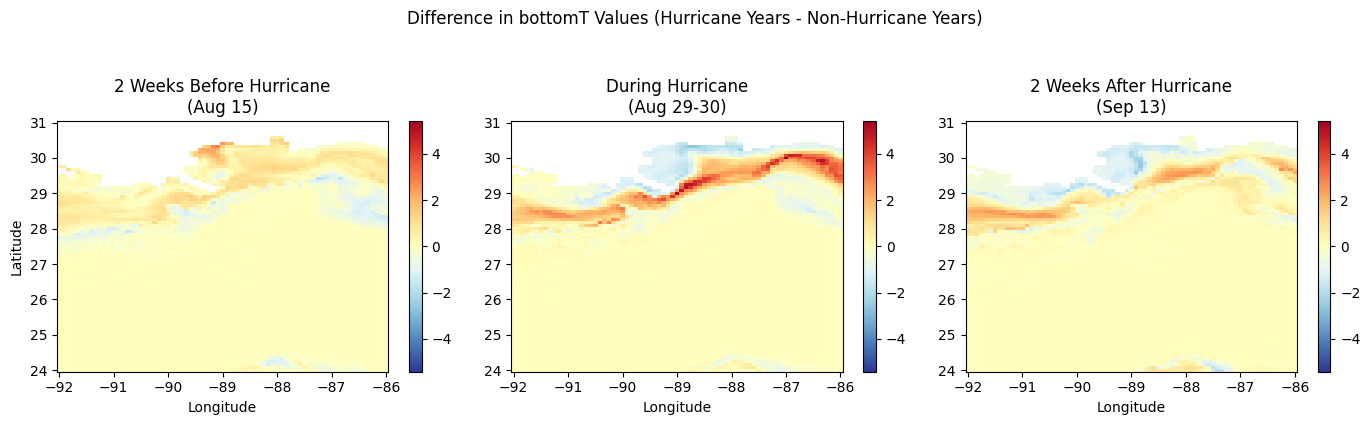

Min difference: -7.78
Max difference: 23.58


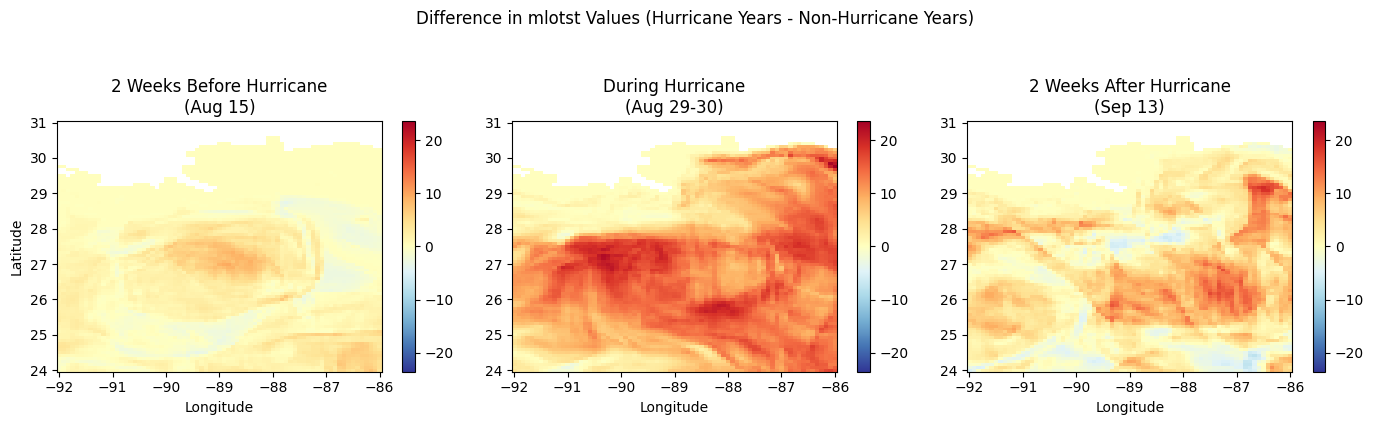

Min difference: -4.46
Max difference: 5.37


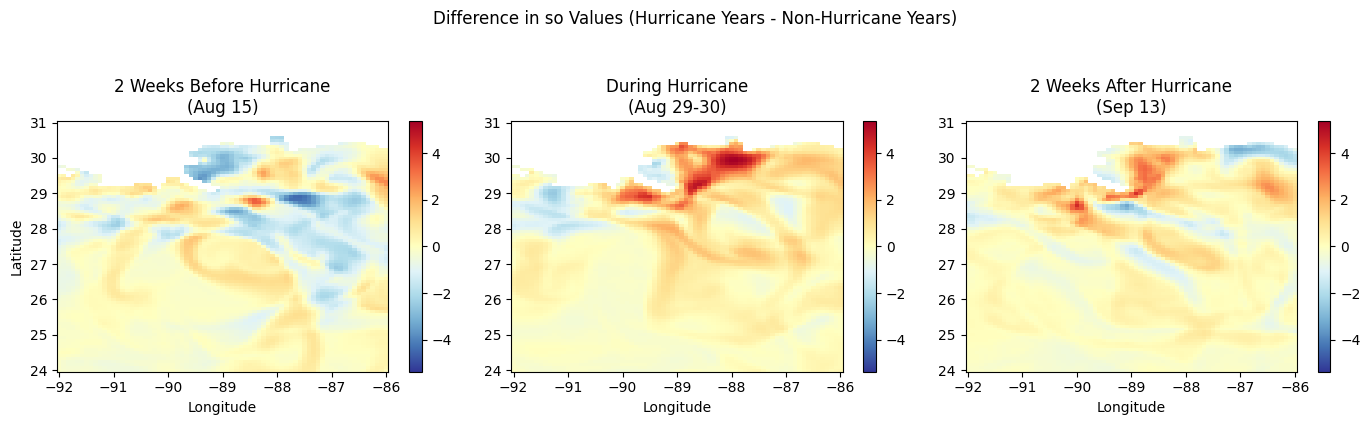

Min difference: -1.28
Max difference: 2.23


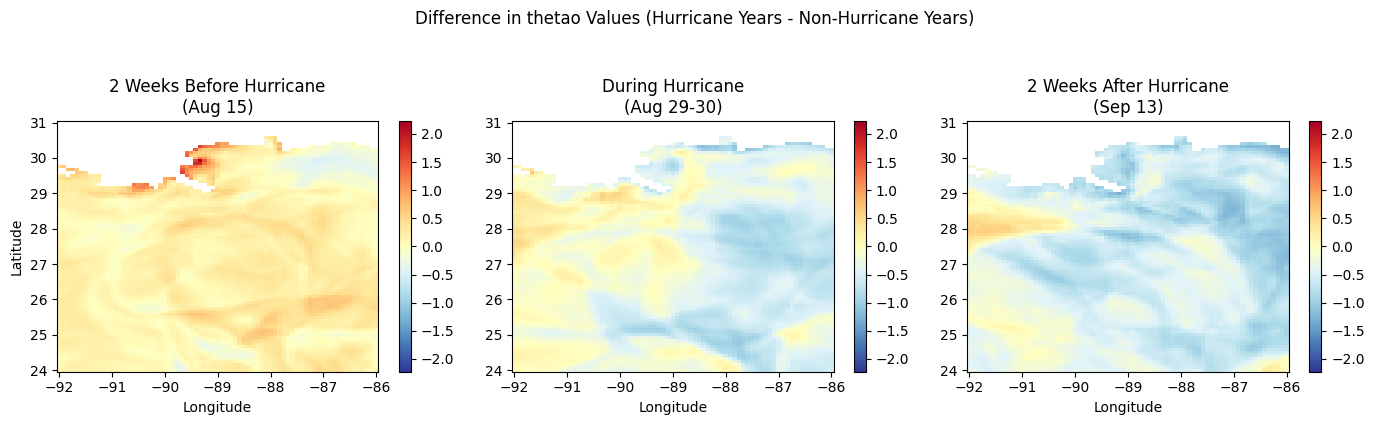

Min difference: -0.77
Max difference: 0.73


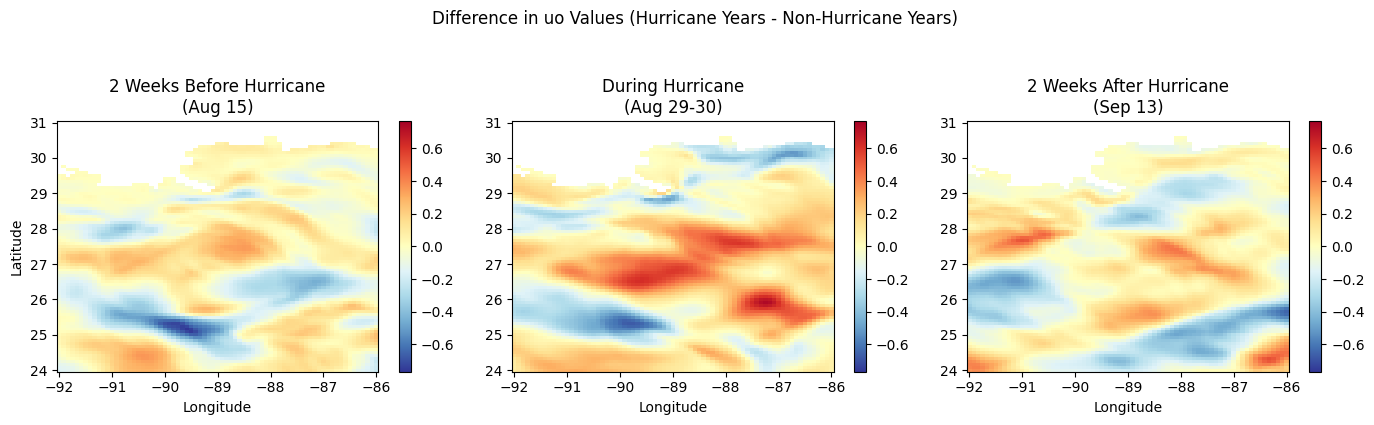

Min difference: -0.75
Max difference: 0.85


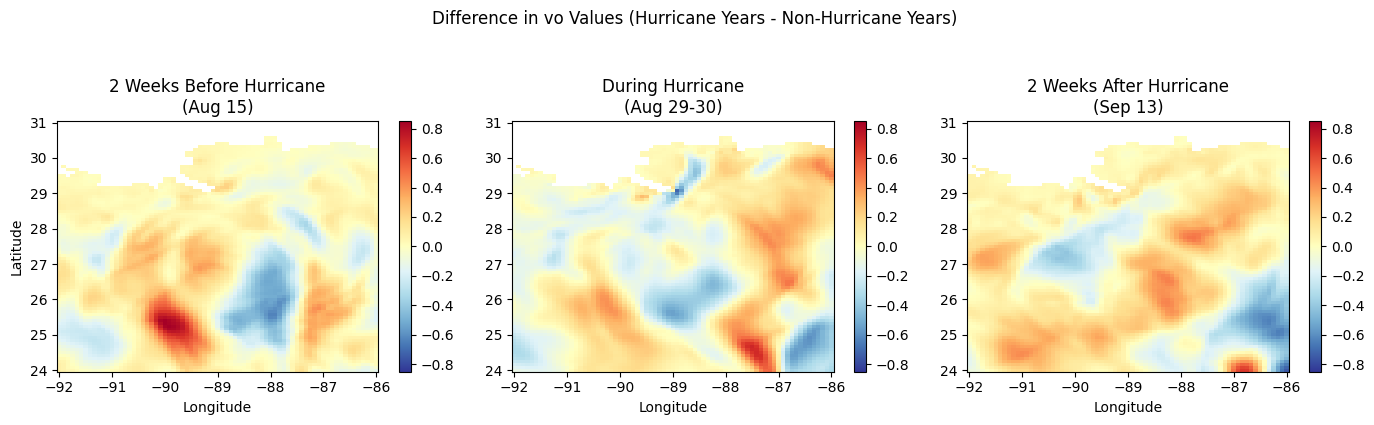

Min difference: -0.24
Max difference: 0.61


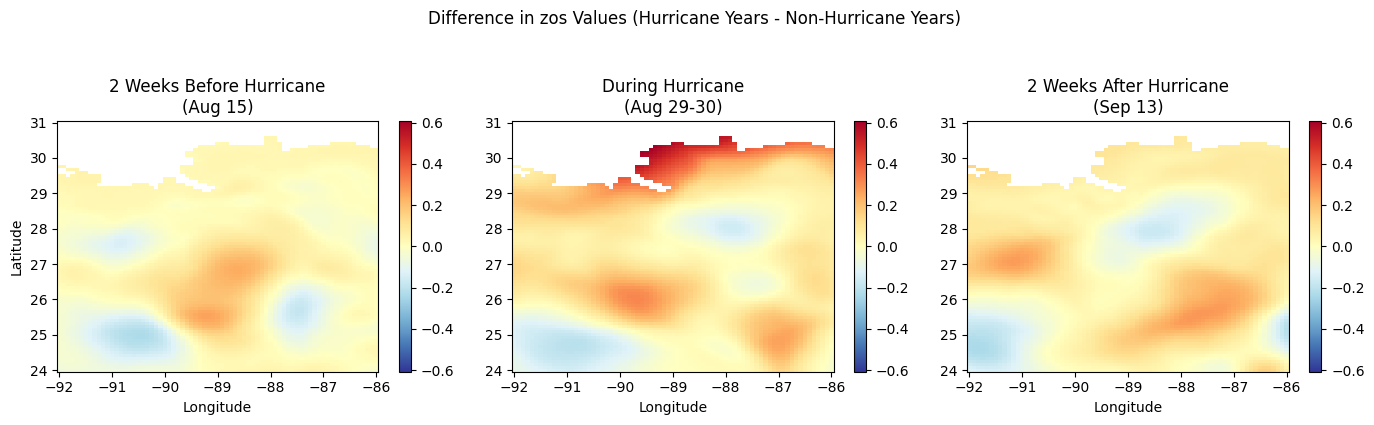

Min difference: -0.89
Max difference: 0.37


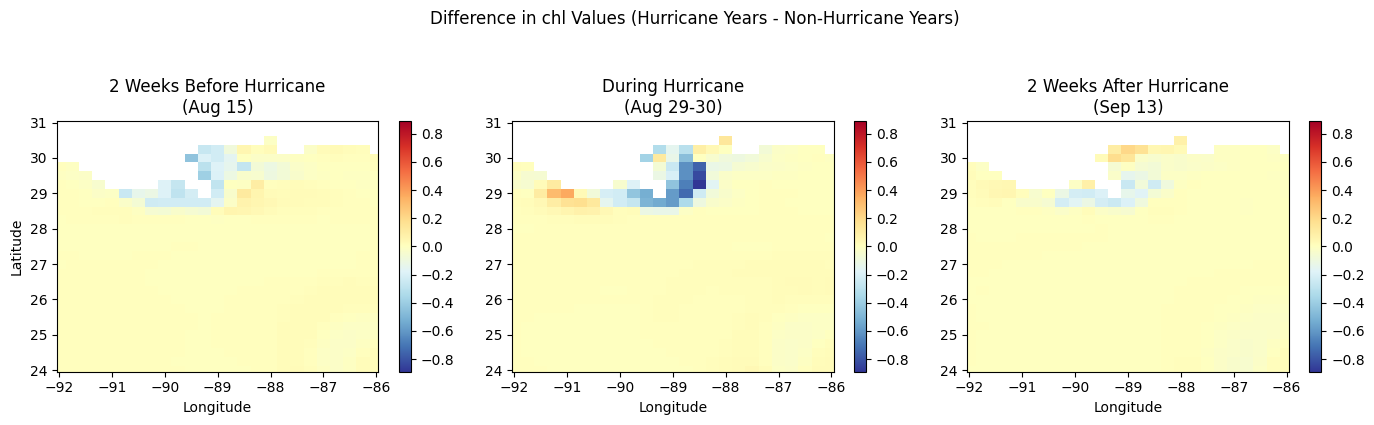

Min difference: -7.08
Max difference: 6.14


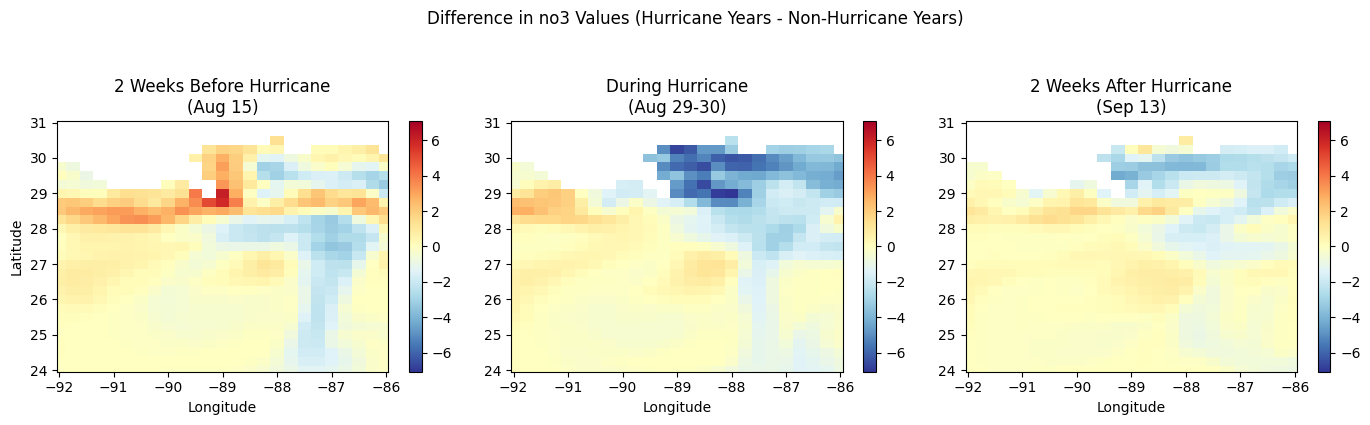

Min difference: -95.96
Max difference: 21.10


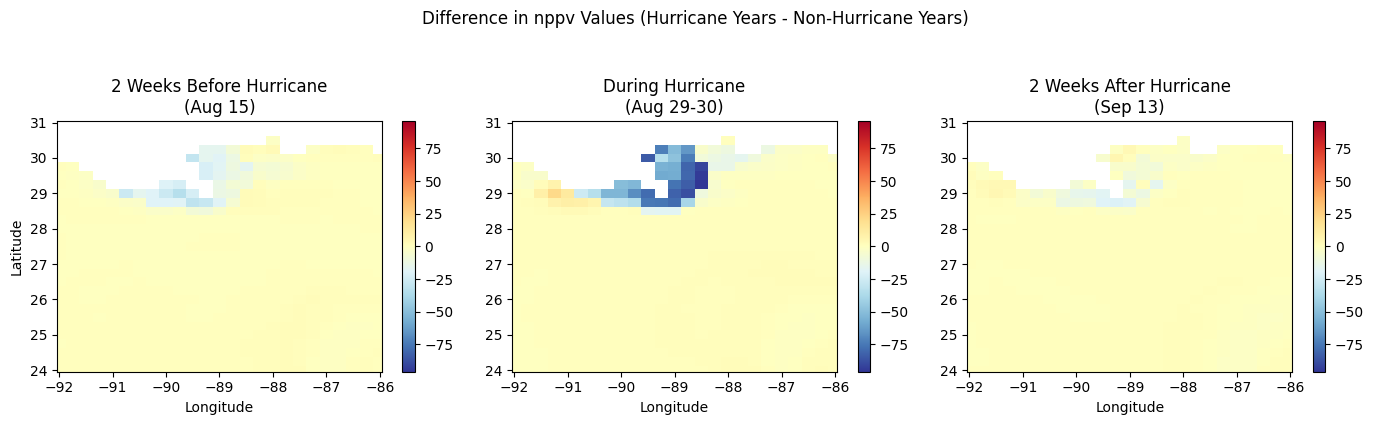

Min difference: -11.76
Max difference: 7.70


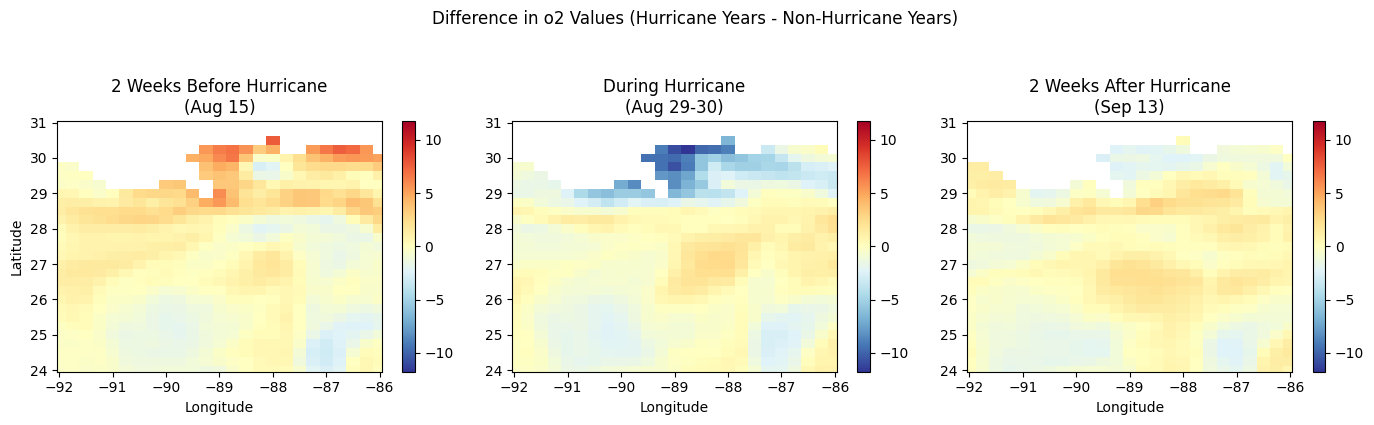

Min difference: -0.00
Max difference: 0.00


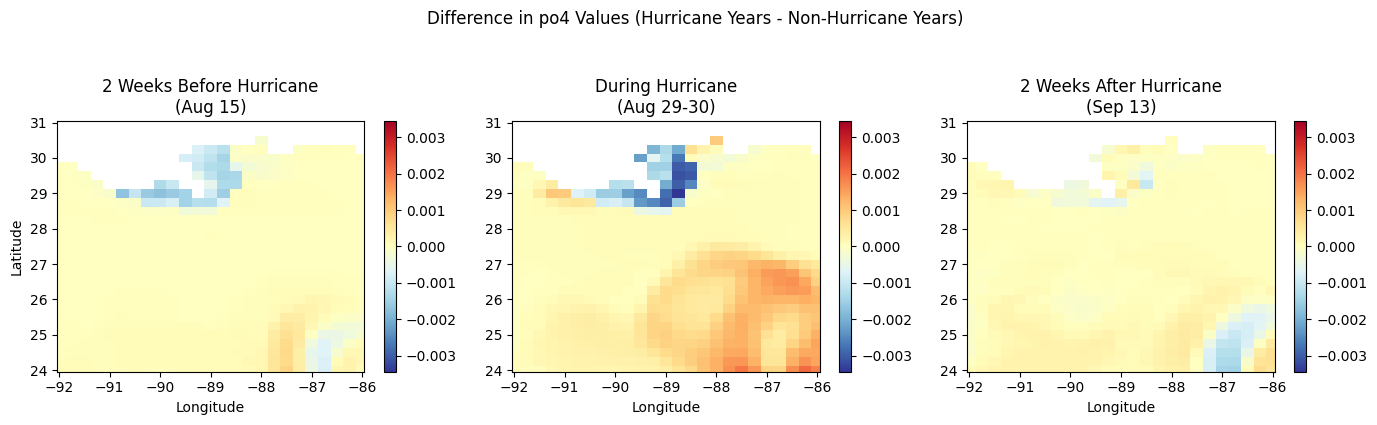

Min difference: -8.25
Max difference: 16.41


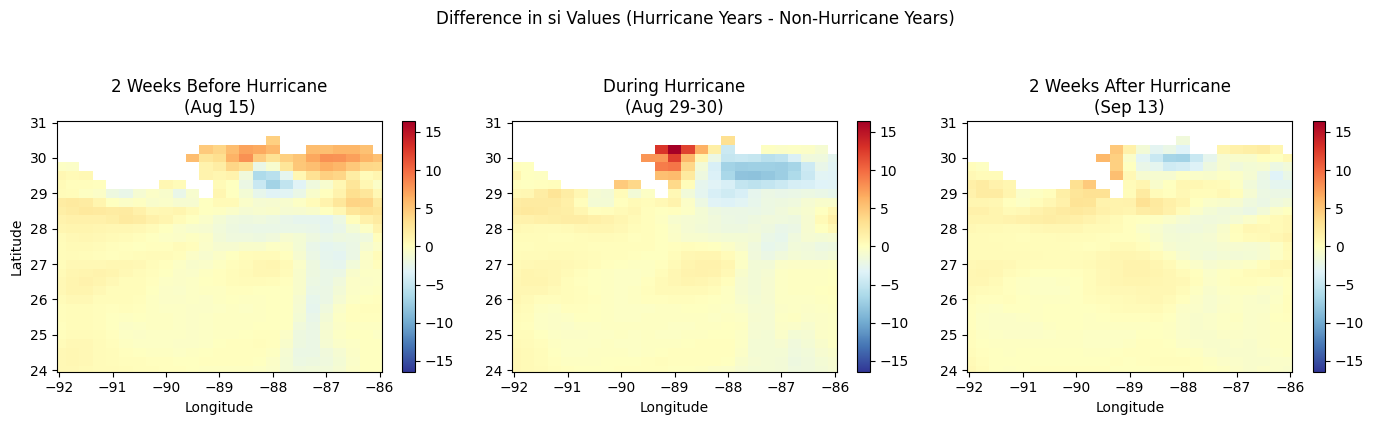

In [165]:
for var in ds.data_vars:
    if var not in ['siconc','sithick','vsi','usi']:
        plot_hurricane_period_maps(var, ds, ds_hurricane_years_big, ds_non_hurricane_years_big)

Min value: 4.31
Max value: 33.25


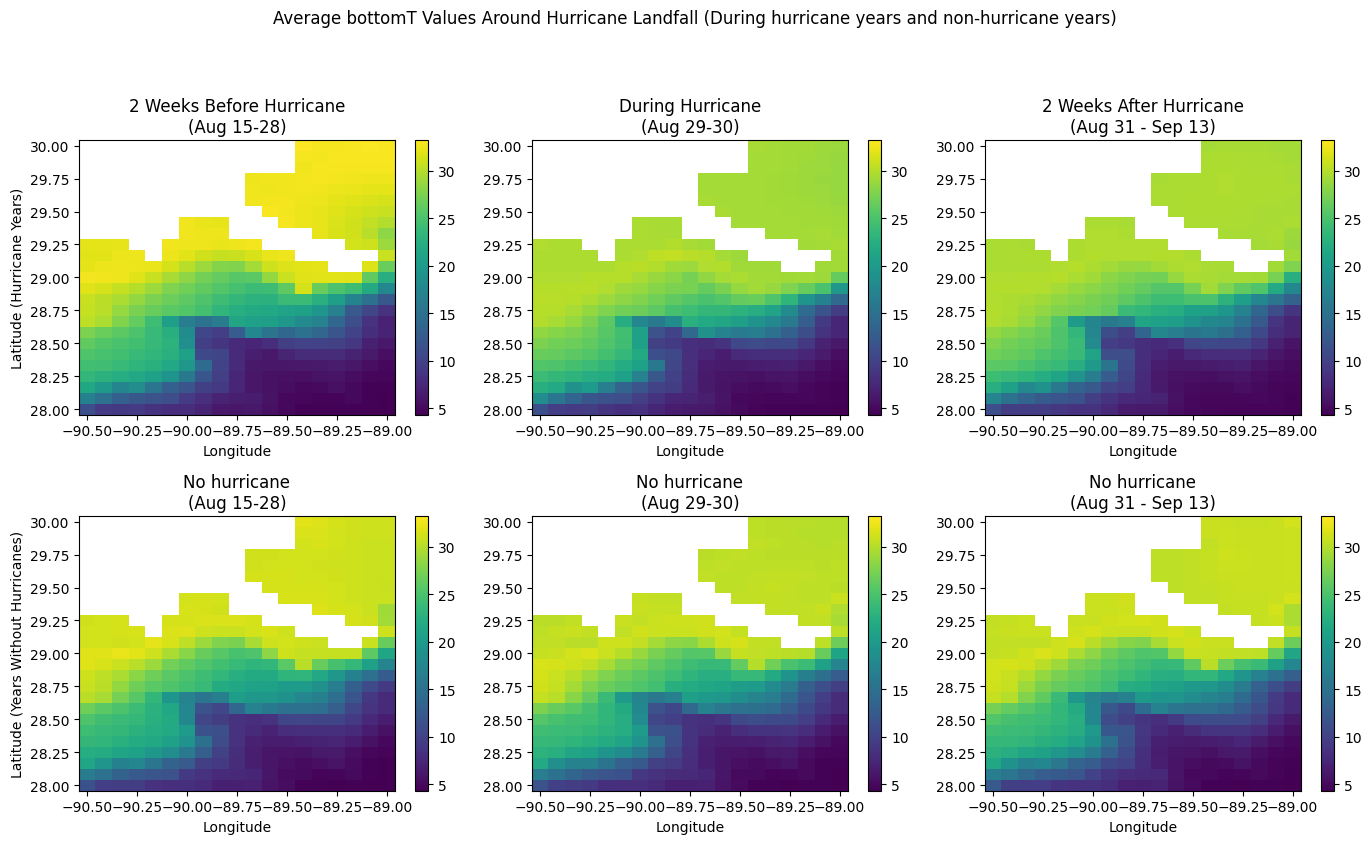

Min value: 6.71
Max value: 18.57


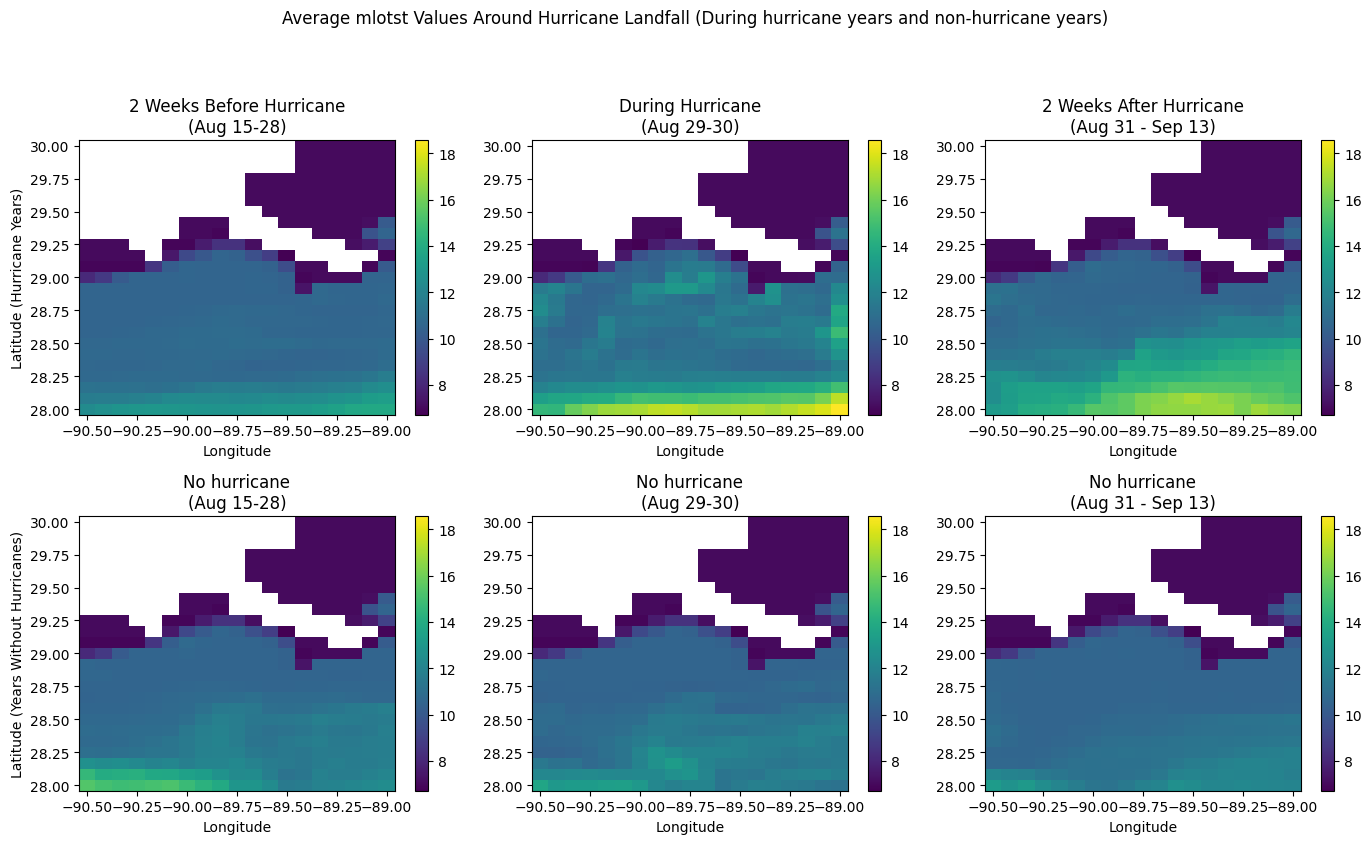

Min value: 17.06
Max value: 36.18


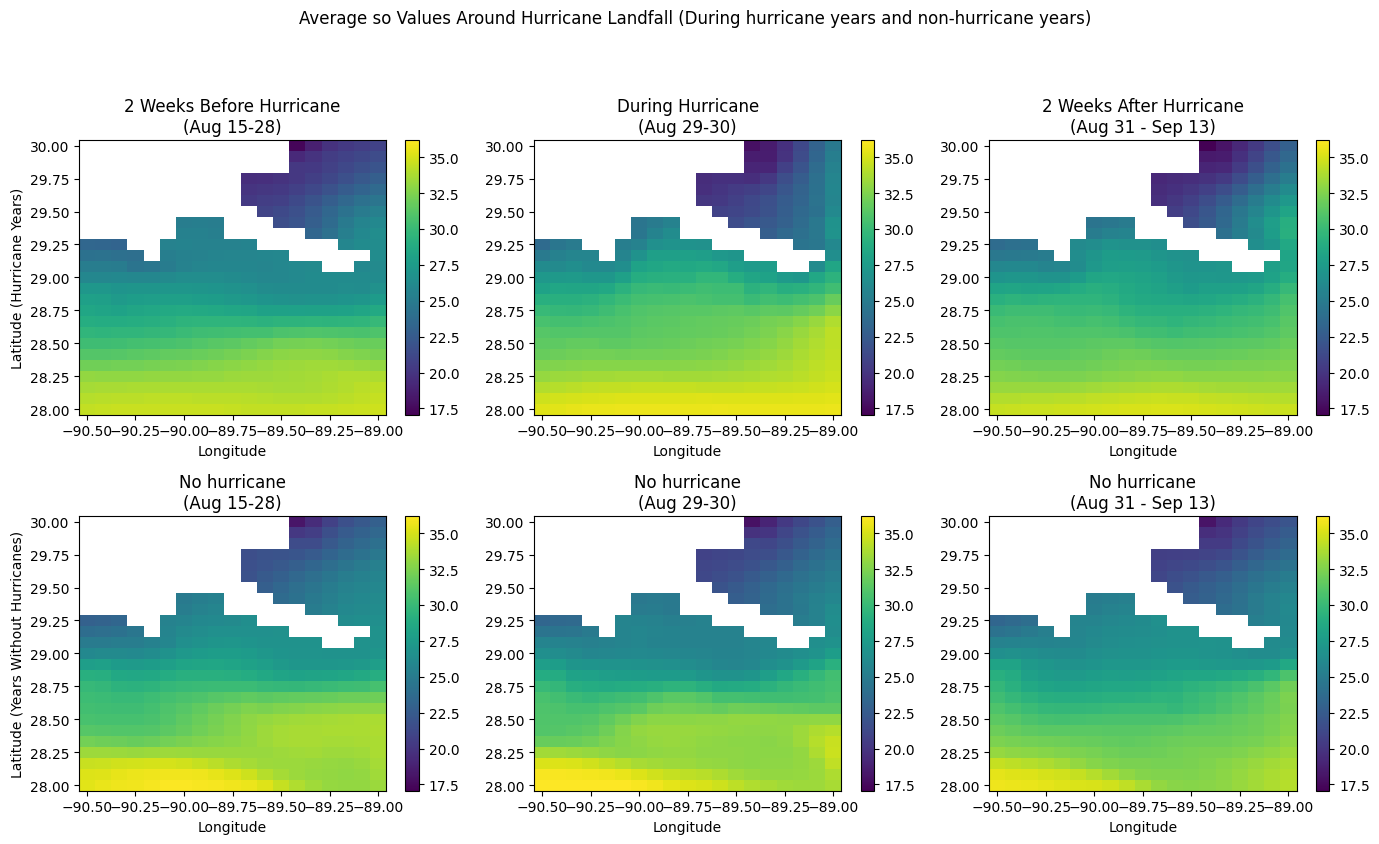

Min value: 28.62
Max value: 32.03


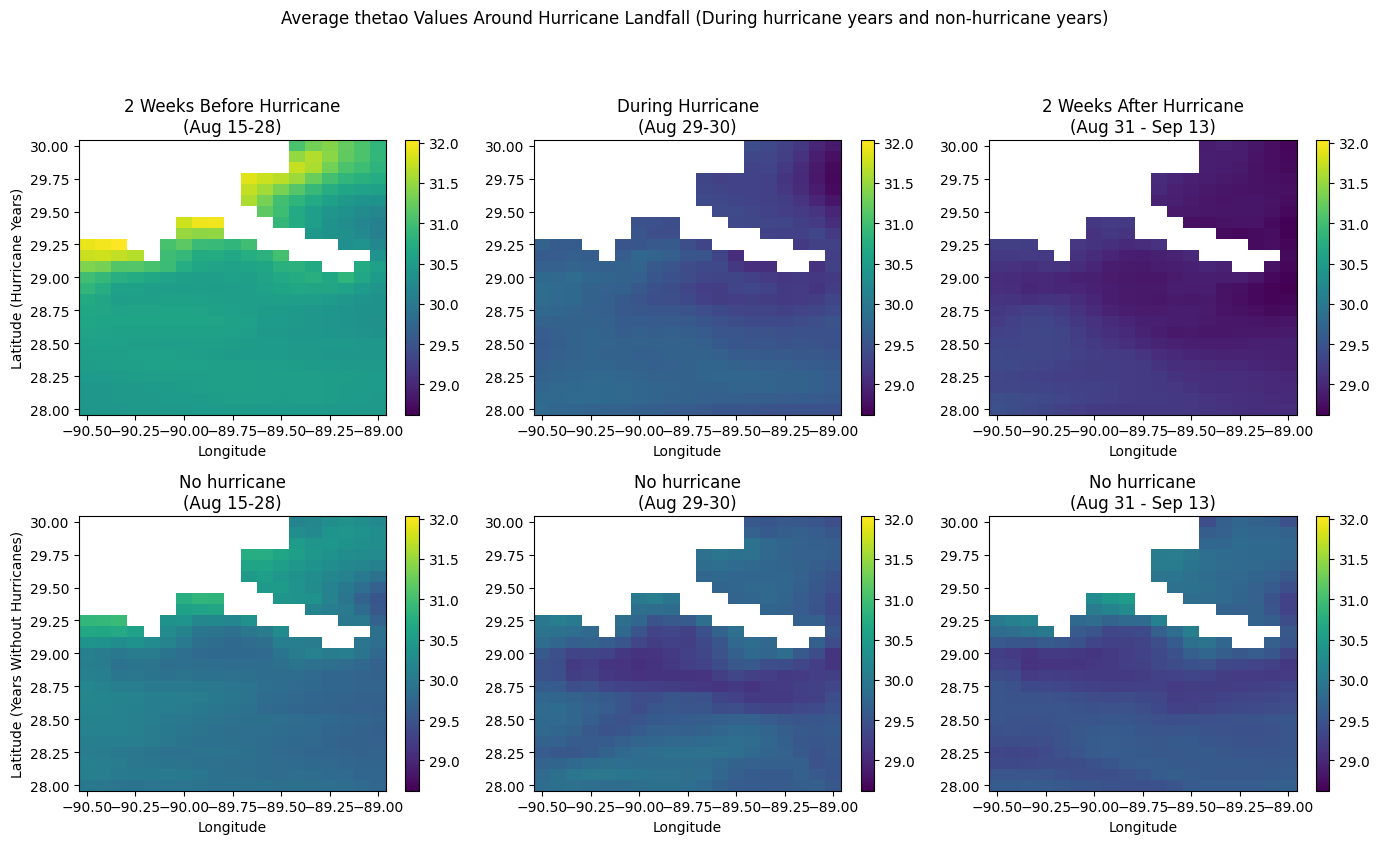

Min value: -0.60
Max value: 0.67


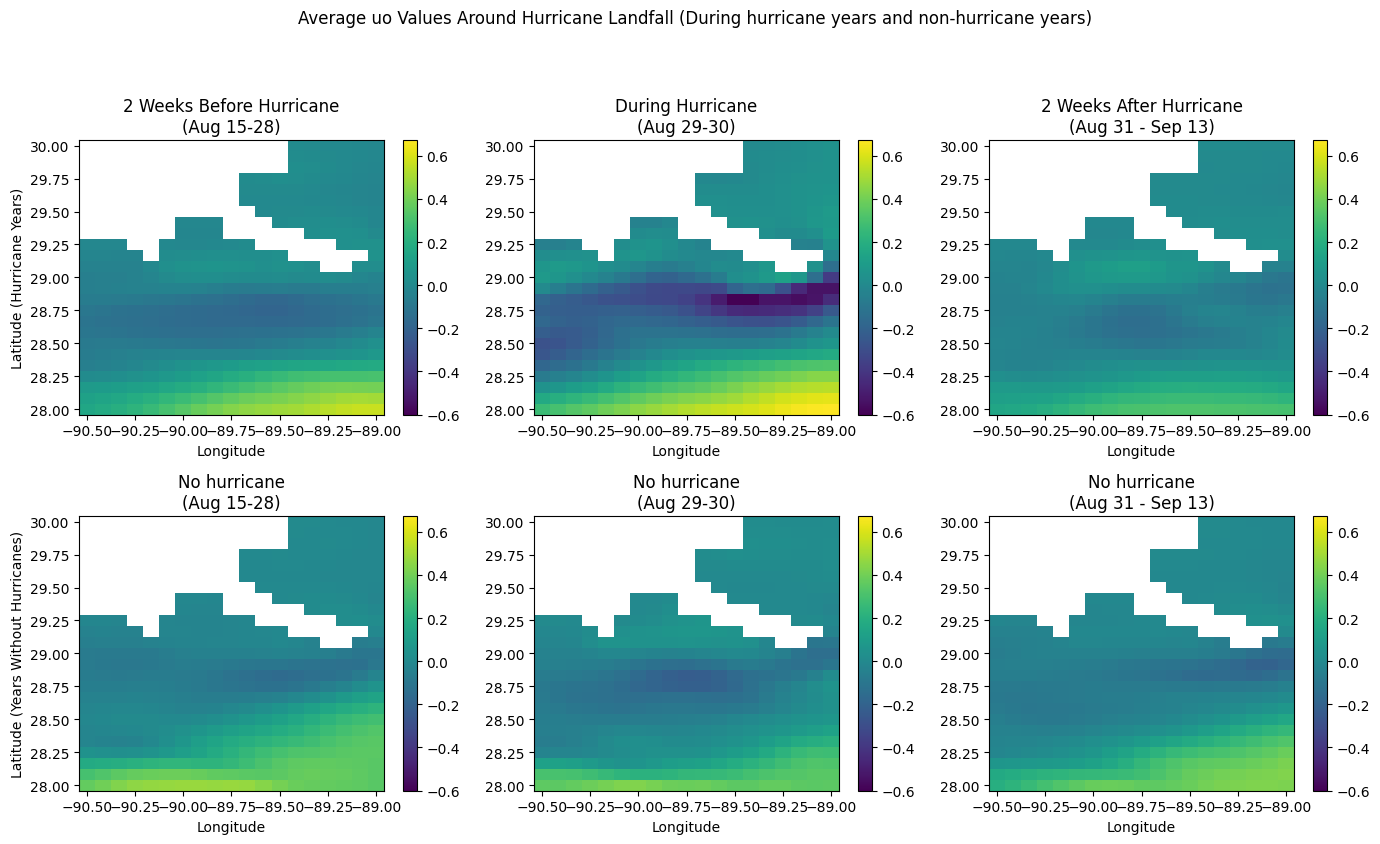

Min value: -0.65
Max value: 0.23


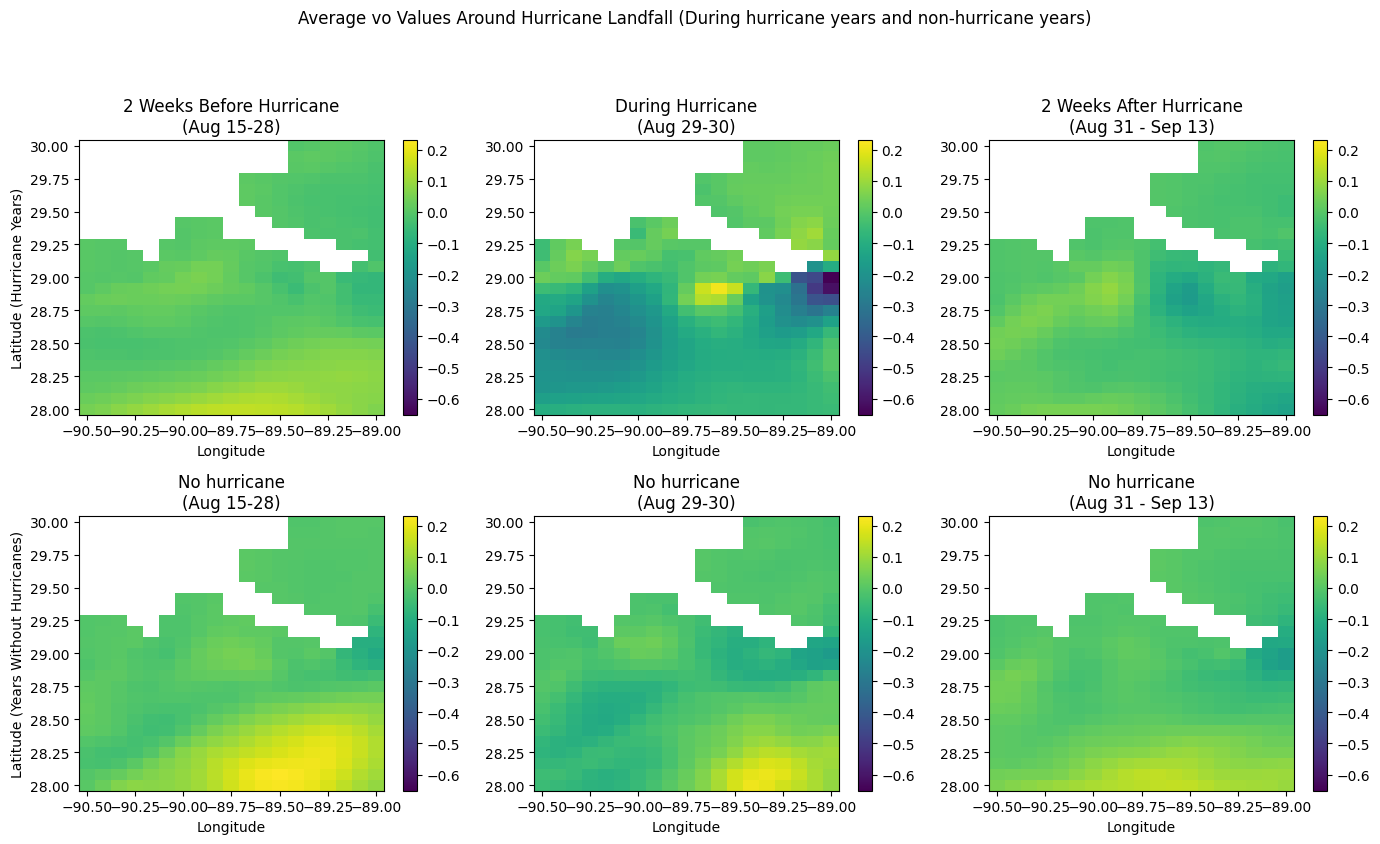

Min value: -0.08
Max value: 0.54


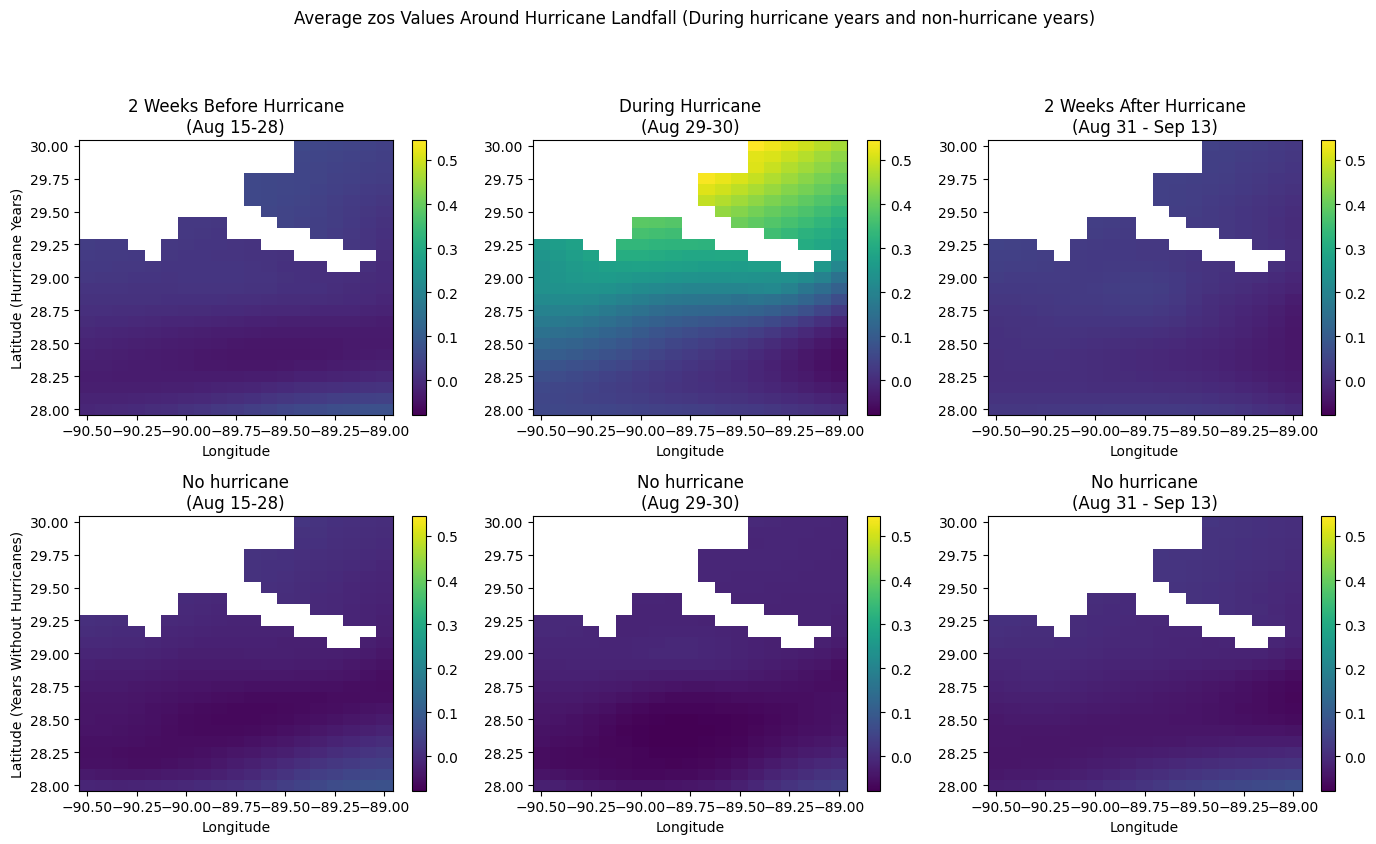

Min value: 0.08
Max value: 1.64


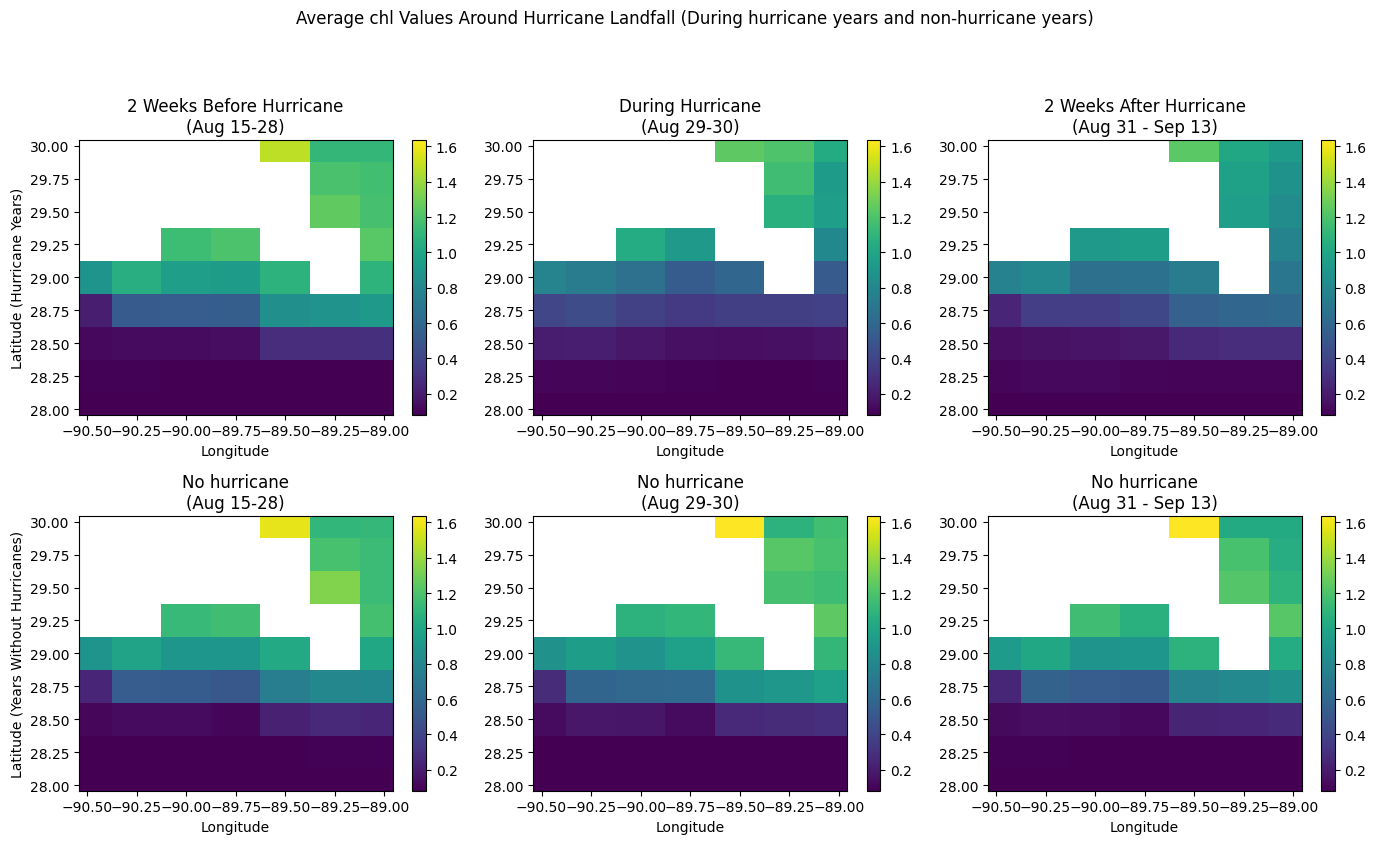

Min value: 0.35
Max value: 27.33


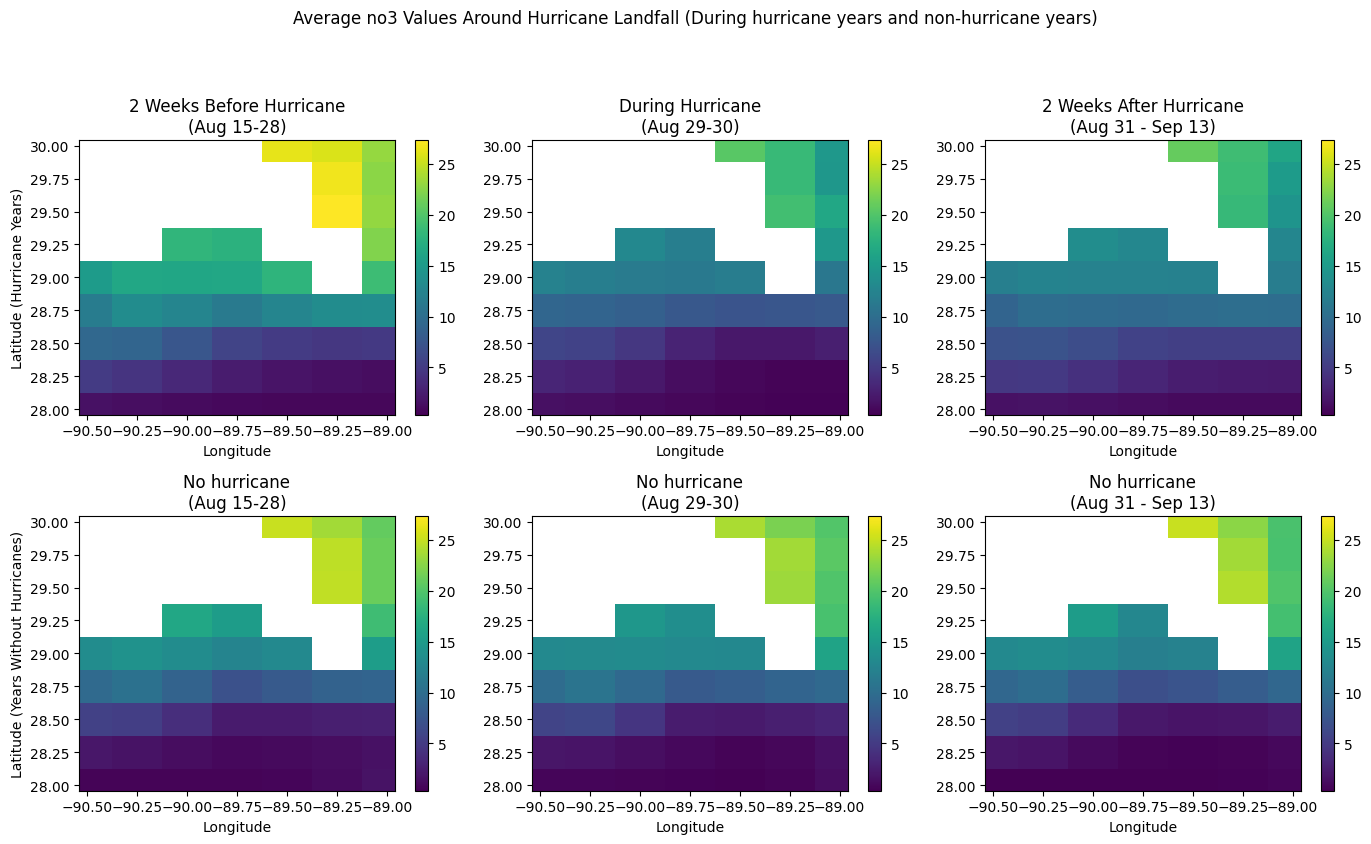

Min value: 1.14
Max value: 162.33


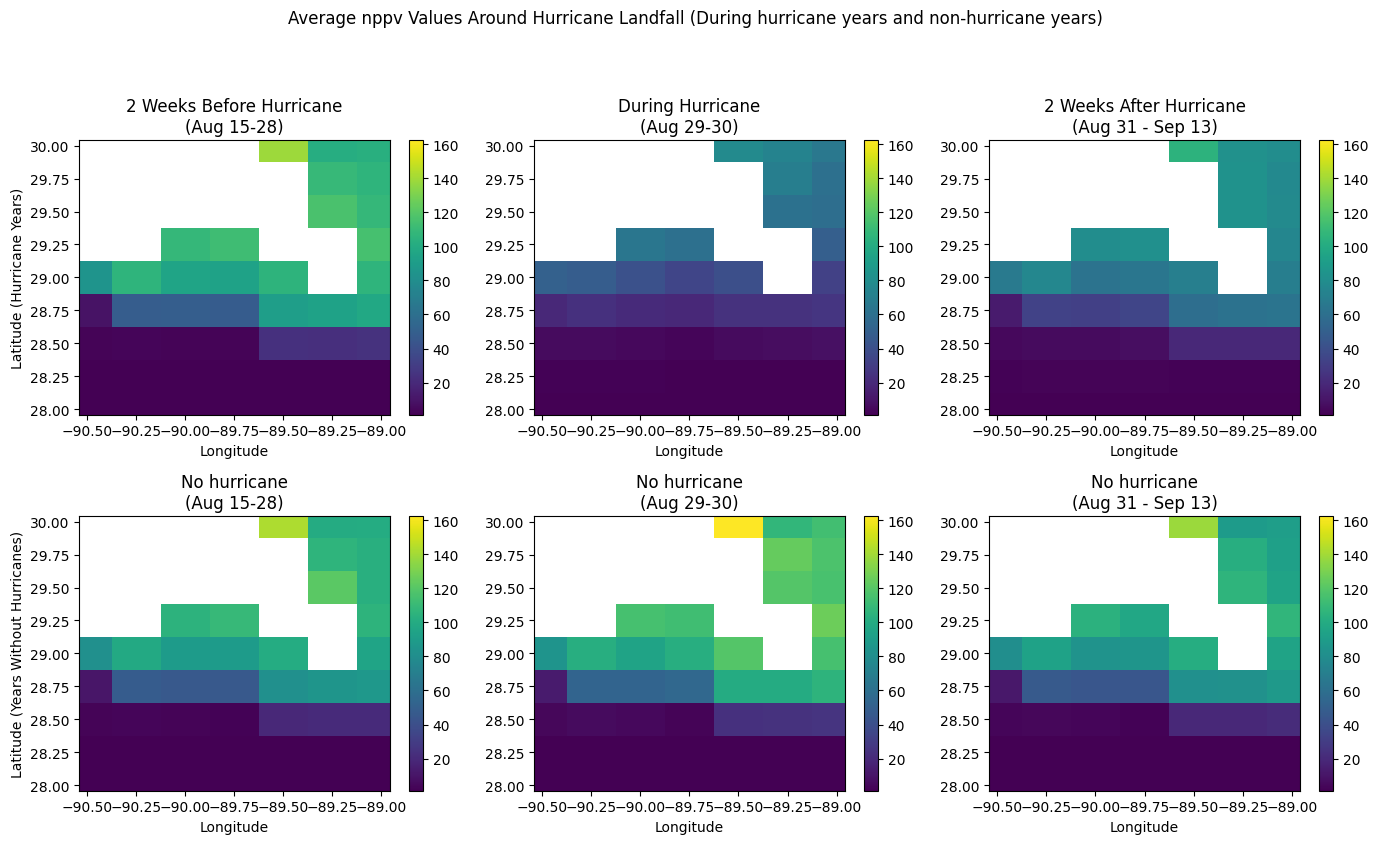

Min value: 196.34
Max value: 223.26


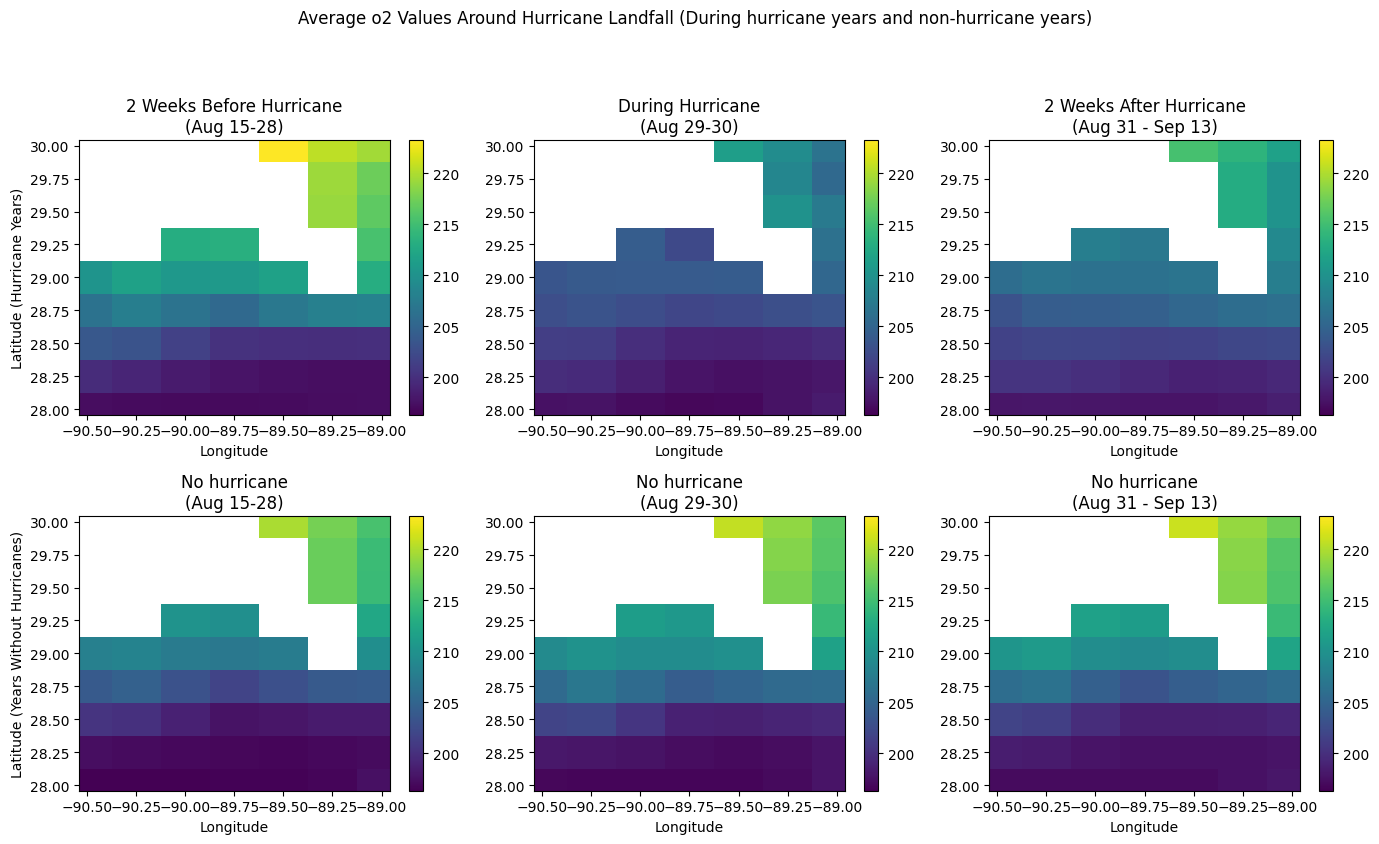

Min value: 0.00
Max value: 0.01


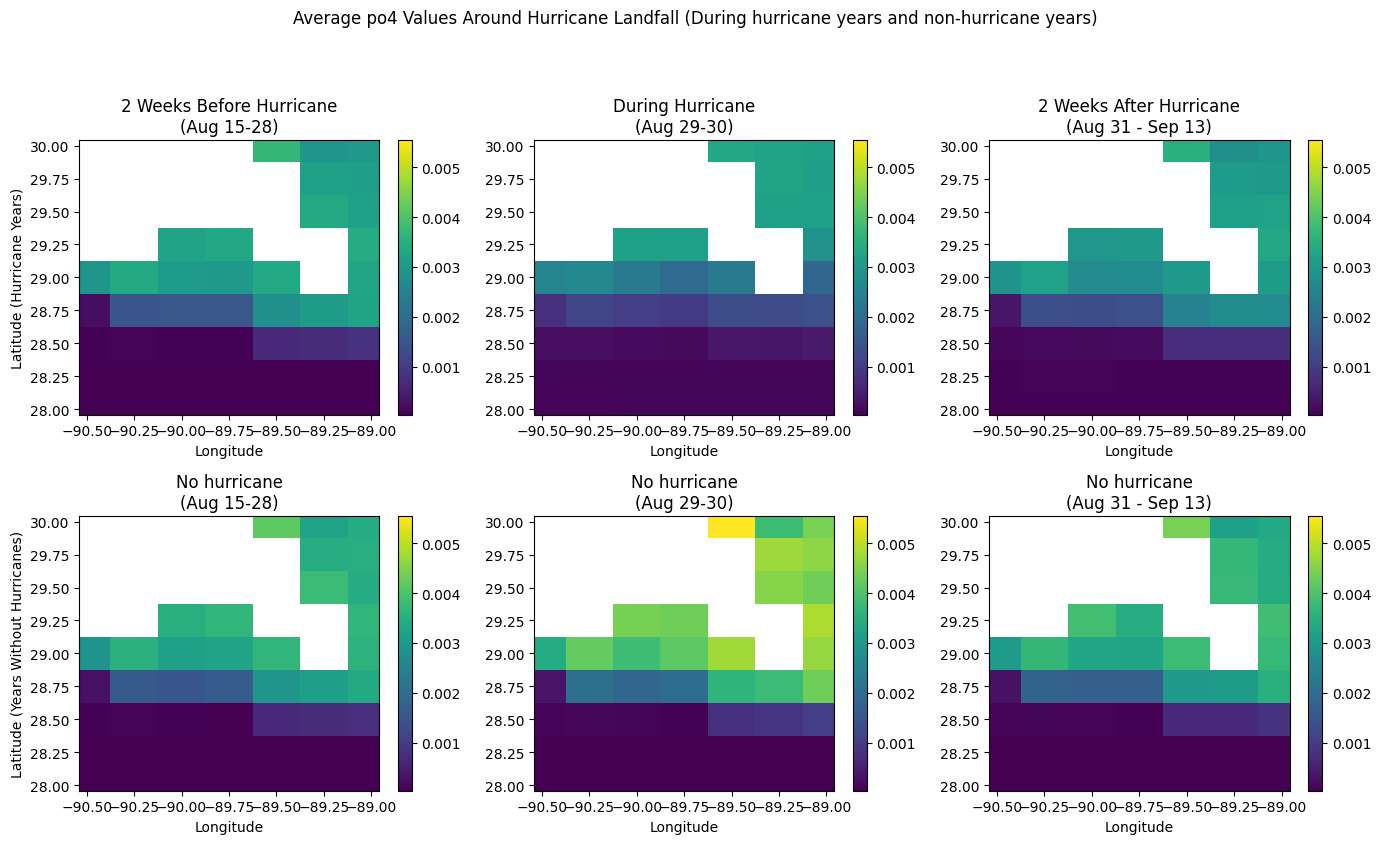

Min value: 4.25
Max value: 35.58


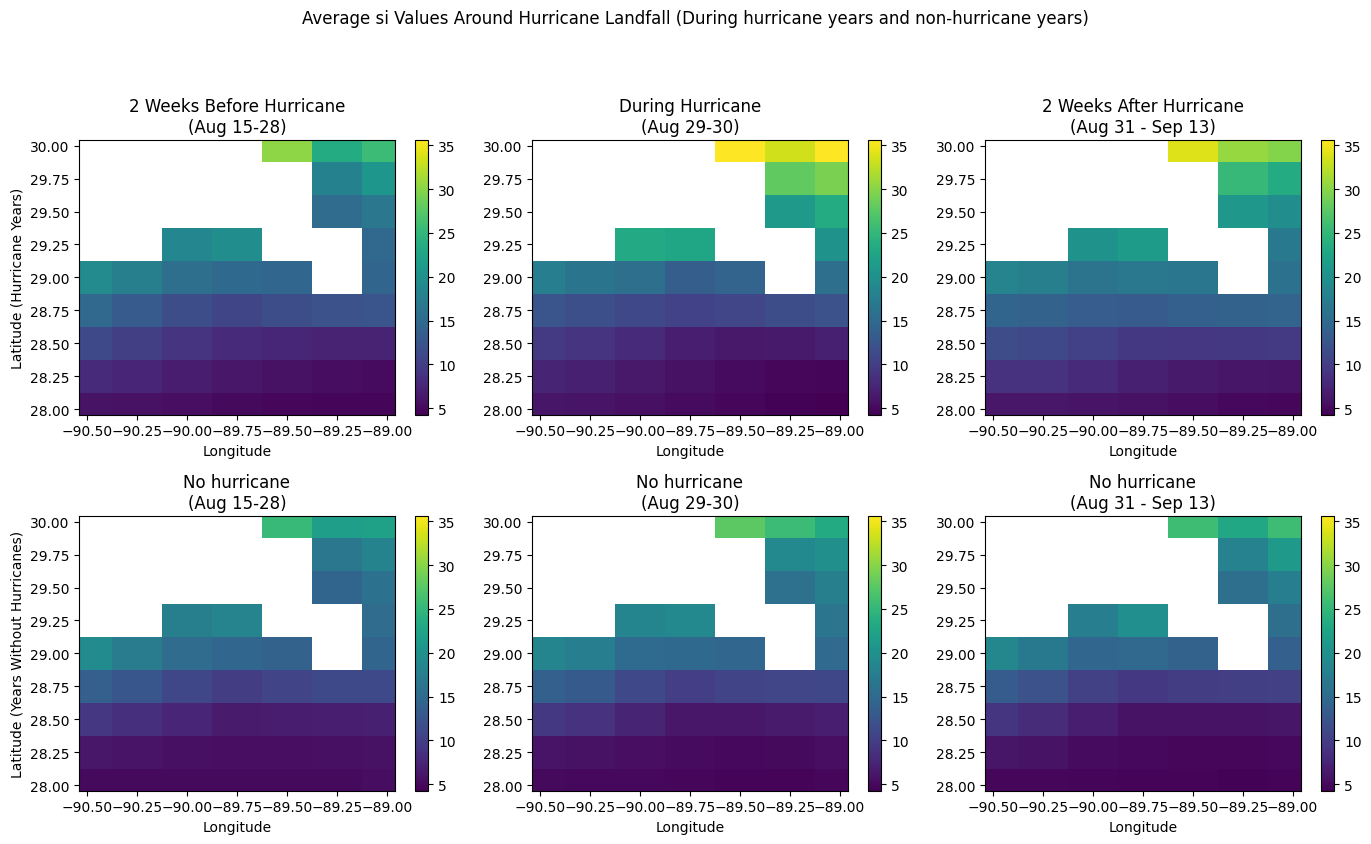

In [68]:
def plot_hurricane_period_maps(variable):
    """
    Plot maps showing average values before, during, and after hurricane period for both
    hurricane and non-hurricane years
    
    Parameters:
        variable (str): Name of variable to plot
    """
    # Create figure with 6 subplots (2 rows, 3 columns)
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    
    # Define time periods (month-day)
    before_period = (ds_redbox.time.dt.month == 8) & (ds_redbox.time.dt.day >= 15) & (ds_redbox.time.dt.day <= 28)
    during_period = (ds_redbox.time.dt.month == 8) & (ds_redbox.time.dt.day.isin([29, 30]))
    after_period = ((ds_redbox.time.dt.month == 8) & (ds_redbox.time.dt.day > 30)) | ((ds_redbox.time.dt.month == 9) & (ds_redbox.time.dt.day <= 13))
    
    # Calculate averages for each period for hurricane years
    before_avg_h = ds_hurricane_years.where(before_period)[variable].mean('time')
    during_avg_h = ds_hurricane_years.where(during_period)[variable].mean('time')
    after_avg_h = ds_hurricane_years.where(after_period)[variable].mean('time')
    
    # Calculate averages for each period for non-hurricane years
    before_avg_nh = ds_non_hurricane_years.where(before_period)[variable].mean('time')
    during_avg_nh = ds_non_hurricane_years.where(during_period)[variable].mean('time')
    after_avg_nh = ds_non_hurricane_years.where(after_period)[variable].mean('time')

    # Calculate min and max values only for the periods we're plotting
    h_data = [before_avg_h, during_avg_h, after_avg_h]
    nh_data = [before_avg_nh, during_avg_nh, after_avg_nh]
    value_min = min(min(d.min() for d in h_data), min(d.min() for d in nh_data)).values
    value_max = max(max(d.max() for d in h_data), max(d.max() for d in nh_data)).values

    # Print min and max values
    print(f"Min value: {value_min:.2f}")
    print(f"Max value: {value_max:.2f}")
    
    # Plot data for hurricane years (top row)
    periods_h = [before_avg_h, during_avg_h, after_avg_h]
    titles_hurricane = ['2 Weeks Before Hurricane\n(Aug 15-28)', 
                       'During Hurricane\n(Aug 29-30)',
                       '2 Weeks After Hurricane\n(Aug 31 - Sep 13)']
    
    for ax, data, title in zip(axes[0], periods_h, titles_hurricane):
        im = ax.pcolormesh(data.longitude, data.latitude, data, 
                          shading='auto',
                          vmin=value_min,
                          vmax=value_max)
        ax.set_title(title)
        ax.set_xlabel('Longitude')
        if ax == axes[0,0]:  # Only show y-label on leftmost plot
            ax.set_ylabel('Latitude (Hurricane Years)')
        fig.colorbar(im, ax=ax)
    
    # Plot data for non-hurricane years (bottom row)
    periods_nh = [before_avg_nh, during_avg_nh, after_avg_nh]
    titles_no_hurricane = ['No hurricane\n(Aug 15-28)', 
                          'No hurricane\n(Aug 29-30)',
                          'No hurricane\n(Aug 31 - Sep 13)']
    
    for ax, data, title in zip(axes[1], periods_nh, titles_no_hurricane):
        im = ax.pcolormesh(data.longitude, data.latitude, data, 
                          shading='auto',
                          vmin=value_min,
                          vmax=value_max)
        ax.set_title(title)
        ax.set_xlabel('Longitude')
        if ax == axes[1,0]:  # Only show y-label on leftmost plot
            ax.set_ylabel('Latitude (Years Without Hurricanes)')
        fig.colorbar(im, ax=ax)
    
    plt.suptitle(f'Average {variable} Values Around Hurricane Landfall (During hurricane years and non-hurricane years)', y=1.05)
    plt.tight_layout()
    
    # Save the figure before showing it
    path = 'images/landfall_maps/'
    filename = f'{variable}_landfall.png'
    plt.savefig(path + filename, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()

for var in ds.data_vars:
    if var not in ['siconc','sithick','vsi','usi']:
        plot_hurricane_period_maps(var)
        
#plot_hurricane_period_maps('mlotst')
#plot_hurricane_period_maps('so')


In [47]:
print("Hurricane Years:")
print(f"Max mlotst: {ds_hurricane_years.mlotst.max().values}")
print(f"Min mlotst: {ds_hurricane_years.mlotst.min().values}")

print("\nNon-Hurricane Years:")
print(f"Max mlotst: {ds_non_hurricane_years.mlotst.max().values}")
print(f"Min mlotst: {ds_non_hurricane_years.mlotst.min().values}")

Hurricane Years:
Max mlotst: 74.61775924265385
Min mlotst: 6.561479851603508

Non-Hurricane Years:
Max mlotst: 84.23109018802643
Min mlotst: 6.256294742226601


In [30]:
ds_redbox

<xarray.Dataset> Size: 29MB
Dimensions:    (latitude: 25, longitude: 19, time: 552)
Coordinates:
  * latitude   (latitude) float32 100B 28.0 28.08 28.17 ... 29.83 29.92 30.0
  * longitude  (longitude) float32 76B -90.5 -90.42 -90.33 ... -89.08 -89.0
  * time       (time) datetime64[ns] 4kB 2005-08-01 2005-08-02 ... 2021-10-31
Data variables: (12/17)
    bottomT    (time, latitude, longitude) float64 2MB 12.65 9.242 ... 21.53
    mlotst     (time, latitude, longitude) float64 2MB 14.34 14.19 ... 7.019
    siconc     (time, latitude, longitude) float64 2MB nan nan nan ... nan nan
    sithick    (time, latitude, longitude) float64 2MB nan nan nan ... nan nan
    so         (time, latitude, longitude) float64 2MB 36.54 36.54 ... 22.12
    thetao     (time, latitude, longitude) float64 2MB 30.21 30.17 ... 21.57
    ...         ...
    chl        (time, latitude, longitude) float32 1MB 0.08436 0.08436 ... 1.178
    no3        (time, latitude, longitude) float32 1MB 0.3749 0.3749 ... 11.67
    nppv       (time, latitude, longitude) float32 1MB 1.178 1.178 ... 62.17
    o2         (time, latitude, longitude) float32 1MB 196.3 196.3 ... 227.4
    po4        (time, latitude, longitude) float32 1MB 3.649e-05 ... 0.004024
    si         (time, latitude, longitude) float32 1MB 5.088 5.088 ... 22.0 22.0
Attributes:
    source:                    MERCATOR GLORYS12V1
    comment:                   CMEMS product
    title:                     daily mean fields from Global Ocean Physics An...
    references:                http://www.mercator-ocean.fr
    Conventions:               CF-1.4
    history:                   2023/06/01 16:20:05 MERCATOR OCEAN Netcdf crea...
    institution:               MERCATOR OCEAN
    copernicusmarine_version:  2.0.0

In [26]:
hurricane_years

{2005, 2012, 2021}

In [24]:
ds_hurricane_years.plot

<xarray.Dataset> Size: 176B
Dimensions:    (latitude: 25, longitude: 19, time: 0)
Coordinates:
  * latitude   (latitude) float32 100B 28.0 28.08 28.17 ... 29.83 29.92 30.0
  * longitude  (longitude) float32 76B -90.5 -90.42 -90.33 ... -89.08 -89.0
  * time       (time) datetime64[ns] 0B 
Data variables: (12/17)
    bottomT    (time, latitude, longitude) float64 0B 
    mlotst     (time, latitude, longitude) float64 0B 
    siconc     (time, latitude, longitude) float64 0B 
    sithick    (time, latitude, longitude) float64 0B 
    so         (time, latitude, longitude) float64 0B 
    thetao     (time, latitude, longitude) float64 0B 
    ...         ...
    chl        (time, latitude, longitude) float32 0B 
    no3        (time, latitude, longitude) float32 0B 
    nppv       (time, latitude, longitude) float32 0B 
    o2         (time, latitude, longitude) float32 0B 
    po4        (time, latitude, longitude) float32 0B 
    si         (time, latitude, longitude) float32 0B 
Attributes:
    source:                    MERCATOR GLORYS12V1
    comment:                   CMEMS product
    title:                     daily mean fields from Global Ocean Physics An...
    references:                http://www.mercator-ocean.fr
    Conventions:               CF-1.4
    history:                   2023/06/01 16:20:05 MERCATOR OCEAN Netcdf crea...
    institution:               MERCATOR OCEAN
    copernicusmarine_version:  2.0.0

In [105]:
import matplotlib.pyplot as plt
def plot_time_averages(ds, variables, start_date, end_date, hurricane_name):
    """
    Plot time-averaged and zero-mean standardized data for selected variables.

    Parameters:
        ds (xr.Dataset): Input dataset with dimensions ('time', 'points').
        variables (List[str]): List of variable names to include in the plot.
    """
    plt.figure(figsize=(10, 5))

    for var in variables:
        data = ds[var]  # shape (time, points)
        # Compute average over all points at each time step
        avg_time_series = data.mean(dim='points')
        # Standardize to zero mean
        standardized = avg_time_series - avg_time_series.mean()
        # Plot
        plt.plot(ds['time'], standardized, label=var)

    # Add red box for hurricane period
    plt.axvspan(start_date, end_date, color='red', alpha=0.2)

    plt.xlabel('Time')
    plt.ylabel('Standardized daily average')
    plt.title(f'Time-Averaged Standardized Variables during {hurricane_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from scipy.signal import savgol_filter

def plot_time_averages_multiple_hurricanes(hurricane_datasets, variable, hurricane_tracks):
    import matplotlib.dates as mdates
    plt.figure(figsize=(12, 5))

    # First standardize no_hurricane data separately
    no_hurricane_data = hurricane_datasets["no_hurricane"][variable]
    no_hurricane_mean = no_hurricane_data.mean()
    no_hurricane_std = no_hurricane_data.std()

    # Plot no_hurricane data
    time = pd.to_datetime(hurricane_datasets["no_hurricane"]['time'].values)
    time_normalized = pd.to_datetime({
        "year": 2000,
        "month": time.month,
        "day": time.day
    })

    standardized_no_hurricane = (no_hurricane_data - no_hurricane_mean) / no_hurricane_std
    
    # Apply Savitzky-Golay filter for smoothing baseline
    window_length = 31  # Must be odd number
    polyorder = 3  # Polynomial order for fitting
    smoothed_baseline = savgol_filter(standardized_no_hurricane, window_length, polyorder)
    plt.plot(time_normalized, smoothed_baseline, label="No Hurricane",
            linestyle='--', color='gray')

    # Plot each hurricane using its own standardization
    for hurricane, ds in hurricane_datasets.items():
        if hurricane != "no_hurricane":
            data = ds[variable]
            
            # Handle both (time, points) and (time,) dimensions
            if "points" in data.dims:
                avg_time_series = data.mean(dim='points')
            else:
                avg_time_series = data

            # Standardize using this hurricane's own parameters
            hurricane_mean = avg_time_series.mean()
            hurricane_std = avg_time_series.std()
            standardized = (avg_time_series - hurricane_mean) / hurricane_std

            time = pd.to_datetime(ds['time'].values)
            time_normalized = pd.to_datetime({
                "year": 2000,
                "month": time.month,
                "day": time.day
            })

            # Apply shorter Savitzky-Golay filter for hurricanes
            window_length_hurricane = 11  # Shorter window for hurricanes
            smoothed_hurricane = savgol_filter(standardized, window_length_hurricane, polyorder)
            plt.plot(time_normalized, smoothed_hurricane, label=hurricane.capitalize())

            # Add hurricane period highlight
            if hurricane in hurricane_tracks:
                start = pd.to_datetime(hurricane_tracks[hurricane]['start_date'])
                end = pd.to_datetime(hurricane_tracks[hurricane]['end_date'])
                start_norm = pd.Timestamp(year=2000, month=start.month, day=start.day)
                end_norm = pd.Timestamp(year=2000, month=end.month, day=end.day)
                plt.axvspan(start_norm, end_norm, color='red', alpha=0.1)

    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.set_xlim(pd.Timestamp('2000-08-01'), pd.Timestamp('2000-10-31'))

    plt.xlabel('Date (MM-DD)')
    plt.ylabel(f'Standardized {variable}')
    plt.title(f'Time-Averaged {variable.upper()} with Individual Hurricane Standardization (Aug-Oct)')
    plt.legend(title="Hurricane")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # Create directory if it doesn't exist
    import os
    os.makedirs('images/time_average/all_time', exist_ok=True)
    
    # Save plot
    filename = f'images/time_average/all_time/window_{variable}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()



In [98]:
from collections import defaultdict

hurricane_datasets = {}
no_hurricane_daily_averages = defaultdict(list)  # var -> list of DataFrames

for hurricane in hurricane_names:
    # 1. Get lat/lon for this hurricane path
    latlon_points = get_latlon_within_radius(ds, hurricane_tracks, hurricane, radius_deg=0.6)

    # 2. Extract hurricane data for that year
    ds_hurricane = extract_ds_grouped_by_time(ds, latlon_points, years=int(hurricane_tracks[hurricane]['year']))
    hurricane_datasets[hurricane] = ds_hurricane

    # 3. Extract no-hurricane years over the same latlon path
    ds_no_hurricane = extract_ds_grouped_by_time(ds, latlon_points, years=no_hurricane_years)

    # 4. Align all no-hurricane data to month-day and compute average per day
    for var in ds_no_hurricane.data_vars:
        df = ds_no_hurricane[var].to_dataframe().reset_index()
        df["date"] = pd.to_datetime(df["time"])
        df["synthetic_date"] = pd.to_datetime({
            "year": 2000,
            "month": df["date"].dt.month,
            "day": df["date"].dt.day
        })
        grouped = df.groupby("synthetic_date")[var].mean().reset_index()
        grouped.set_index("synthetic_date", inplace=True)
        no_hurricane_daily_averages[var].append(grouped)

# 5. After loop: average across the 3 no-hurricane tracks
no_hurricane_combined = {}

for var, df_list in no_hurricane_daily_averages.items():
    df_concat = pd.concat(df_list, axis=1)
    df_mean = df_concat.mean(axis=1)
    no_hurricane_combined[var] = df_mean

# 6. Convert to xarray Dataset
df_combined = pd.DataFrame(no_hurricane_combined)
df_combined.index.name = "time"
ds_no_hurricane_final = xr.Dataset.from_dataframe(df_combined)

# 7. Add to datasets
hurricane_datasets["no_hurricane"] = ds_no_hurricane_final


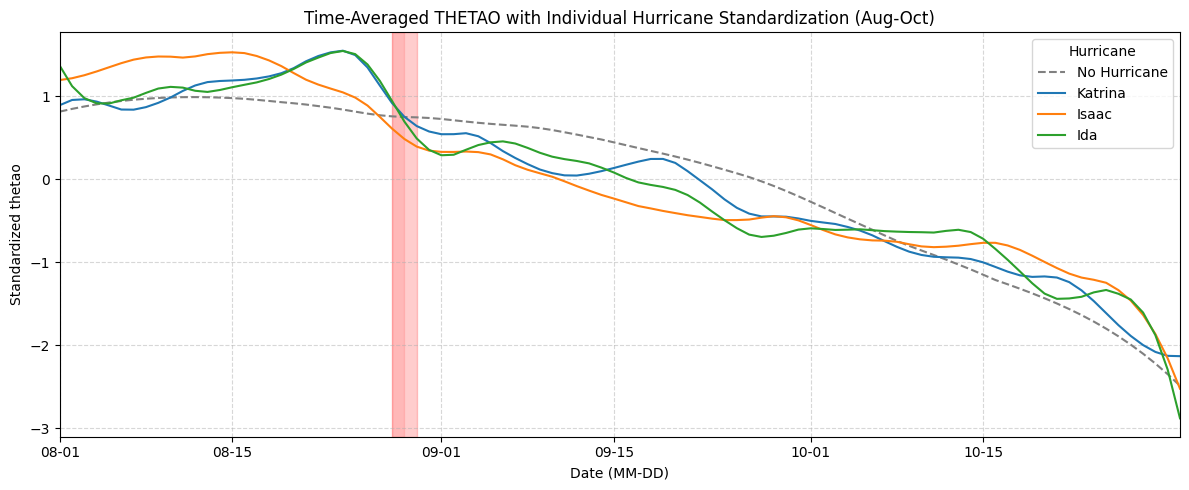

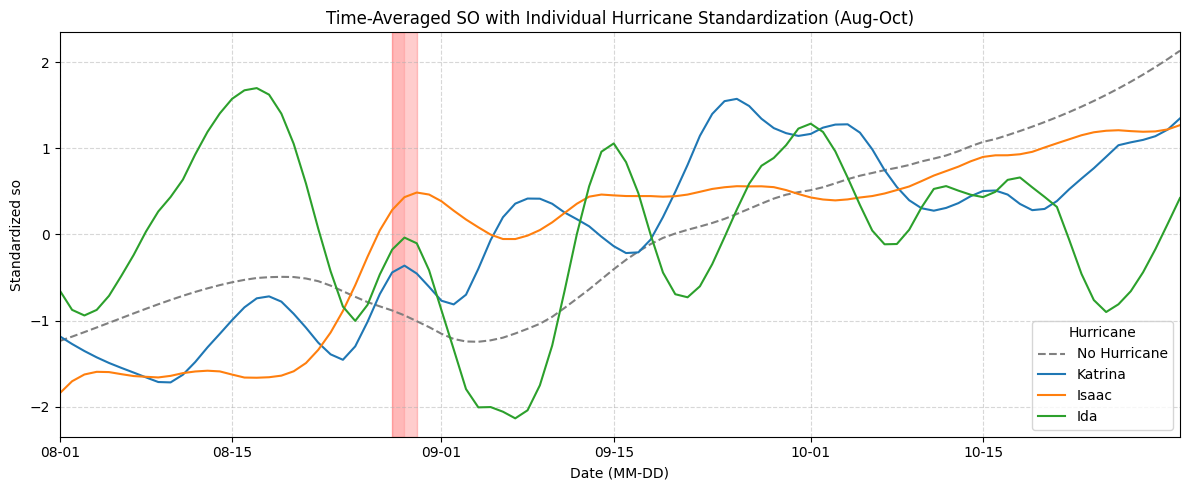

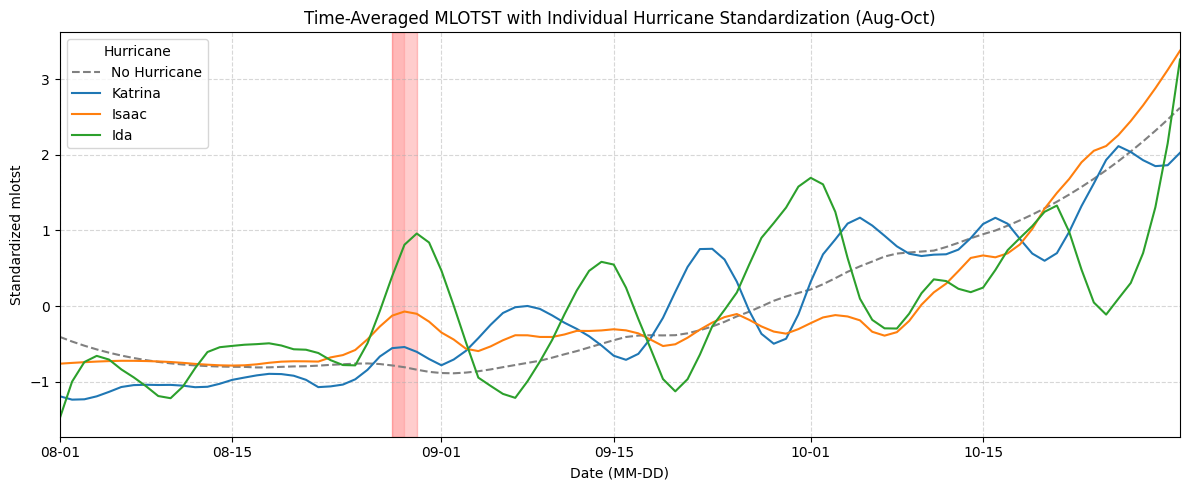

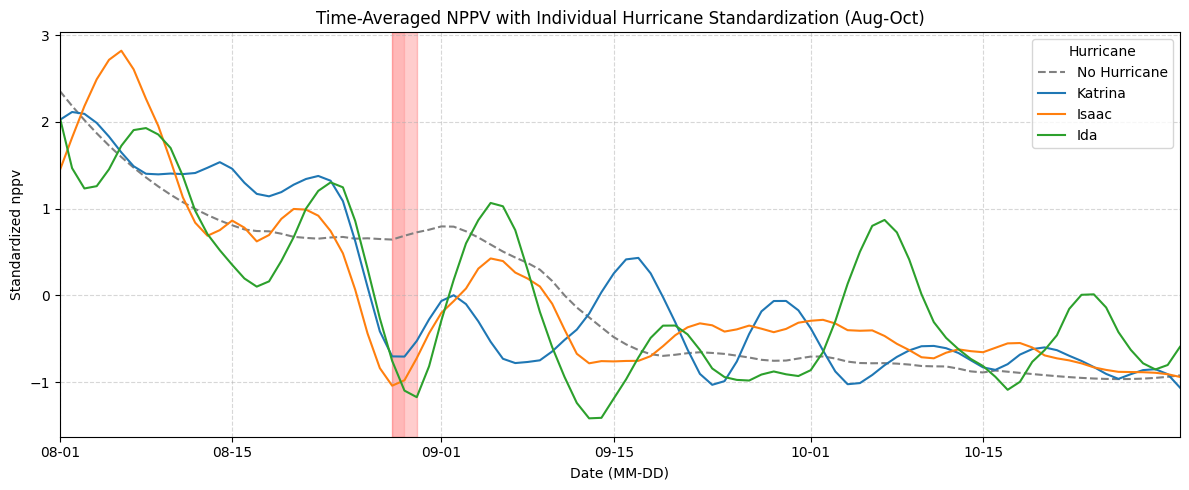

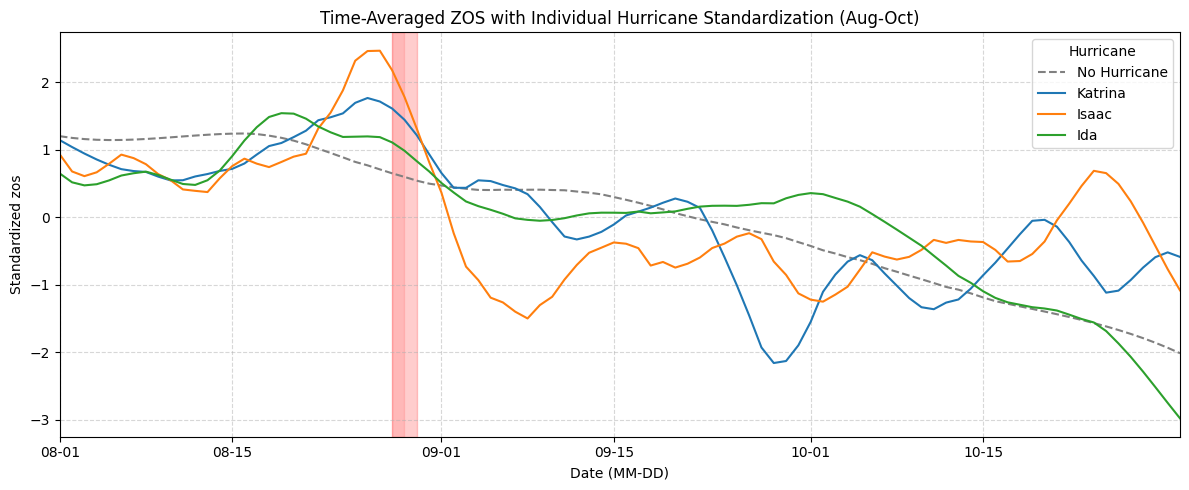

In [106]:
for var in ['thetao','so','mlotst','nppv','zos']: #ds.data_vars:
    if var not in ['siconc','sithick','vsi','usi']:
        plot_time_averages_multiple_hurricanes(
            hurricane_datasets,
            variable=var,
            hurricane_tracks=hurricane_tracks
        )

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import os

def plot_hurricane_vs_nohurricane(ds_hurricane, ds_no_hurricane, var_name, hurricane_meta, hurricane_name):
    """
    Plots weekly average, max, and min values of `var_name` from August 1 to October 31
    comparing a hurricane year vs. average of multiple no-hurricane years.
    Highlights the week(s) during which the hurricane occurred.

    Parameters:
        ds_hurricane (xr.Dataset): Dataset for the hurricane year.
        ds_no_hurricane (xr.Dataset): Dataset for non-hurricane years.
        var_name (str): Name of the data variable to analyze.
        hurricane_meta (dict): Dict with 'year', 'start_date', 'end_date' of the hurricane.
        hurricane_name (str): Name of the hurricane (e.g., 'katrina').
    """
    def preprocess(ds):
        df = ds[var_name].to_dataframe().reset_index()
        df["date"] = pd.to_datetime(df["time"])
        df["week"] = df["date"].dt.isocalendar().week
        df["month"] = df["date"].dt.month
        return df[(df["month"] >= 8) & (df["month"] <= 10)]

    df_h = preprocess(ds_hurricane)
    df_nh = preprocess(ds_no_hurricane)

    stats_h = df_h.groupby("week")[var_name].agg(["mean", "min", "max"])
    stats_nh = df_nh.groupby("week")[var_name].agg(["mean", "min", "max"])

    weeks = sorted(set(stats_h.index) | set(stats_nh.index))
    stats_h = stats_h.reindex(weeks)
    stats_nh = stats_nh.reindex(weeks)

    x = np.arange(len(weeks))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 6))

    # Bar plots
    ax.bar(x - width/2, stats_h["mean"], width, label=f"{hurricane_name.capitalize()} Avg", alpha=0.7, color="tab:red")
    ax.errorbar(x - width/2, stats_h["mean"], 
                yerr=[stats_h["mean"] - stats_h["min"], stats_h["max"] - stats_h["mean"]],
                fmt='none', ecolor='tab:red', capsize=5)

    ax.bar(x + width/2, stats_nh["mean"], width, label="No-Hurricane Avg", alpha=0.7, color="tab:blue")
    ax.errorbar(x + width/2, stats_nh["mean"], 
                yerr=[stats_nh["mean"] - stats_nh["min"], stats_nh["max"] - stats_nh["mean"]],
                fmt='none', ecolor='tab:blue', capsize=5)

    # Y-axis limits
    all_mins = np.minimum(stats_h["min"].min(), stats_nh["min"].min())
    all_maxs = np.maximum(stats_h["max"].max(), stats_nh["max"].max())
    y_margin = (all_maxs - all_mins) * 0.05
    ax.set_ylim(all_mins - y_margin, all_maxs + y_margin)

    # Highlight hurricane week(s)
    start_date = pd.to_datetime(hurricane_meta["start_date"])
    end_date = pd.to_datetime(hurricane_meta["end_date"])
    hurricane_weeks = pd.date_range(start_date, end_date).isocalendar().week.unique()

    for week in hurricane_weeks:
        if week in weeks:
            idx = weeks.index(week)
            ax.axvspan(idx - 0.5, idx + 0.5, color="gray", alpha=0.3, label=f"{hurricane_name.capitalize()} Week")

    # Avoid duplicate legend entry
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    ax.set_xlabel("ISO Week Number (Aug - Oct)")
    ax.set_ylabel(var_name)
    ax.set_title(f"Weekly Stats of '{var_name}' - {hurricane_name.capitalize()} vs. No-Hurricane")
    ax.set_xticks(x)
    ax.set_xticklabels(weeks)
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    
    # Create directory if it doesn't exist
    os.makedirs("images/weekly_average", exist_ok=True)
    
    # Save figure
    filename = f"images/weekly_average/{hurricane_name}_{var_name}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


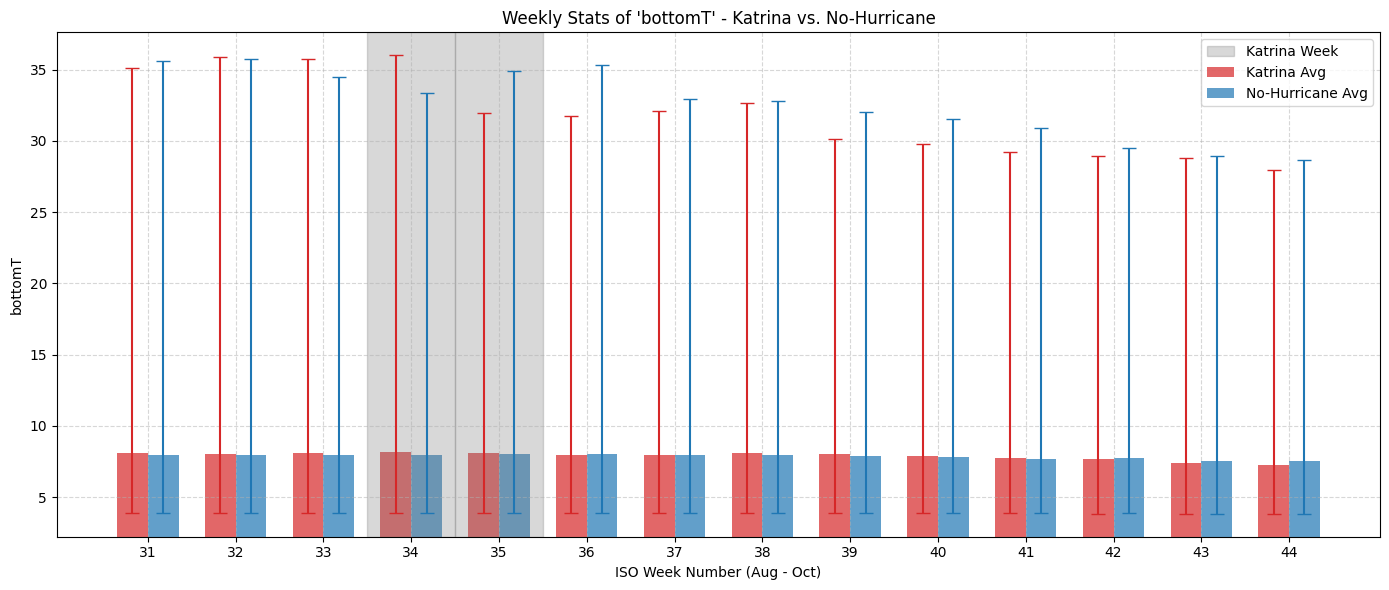

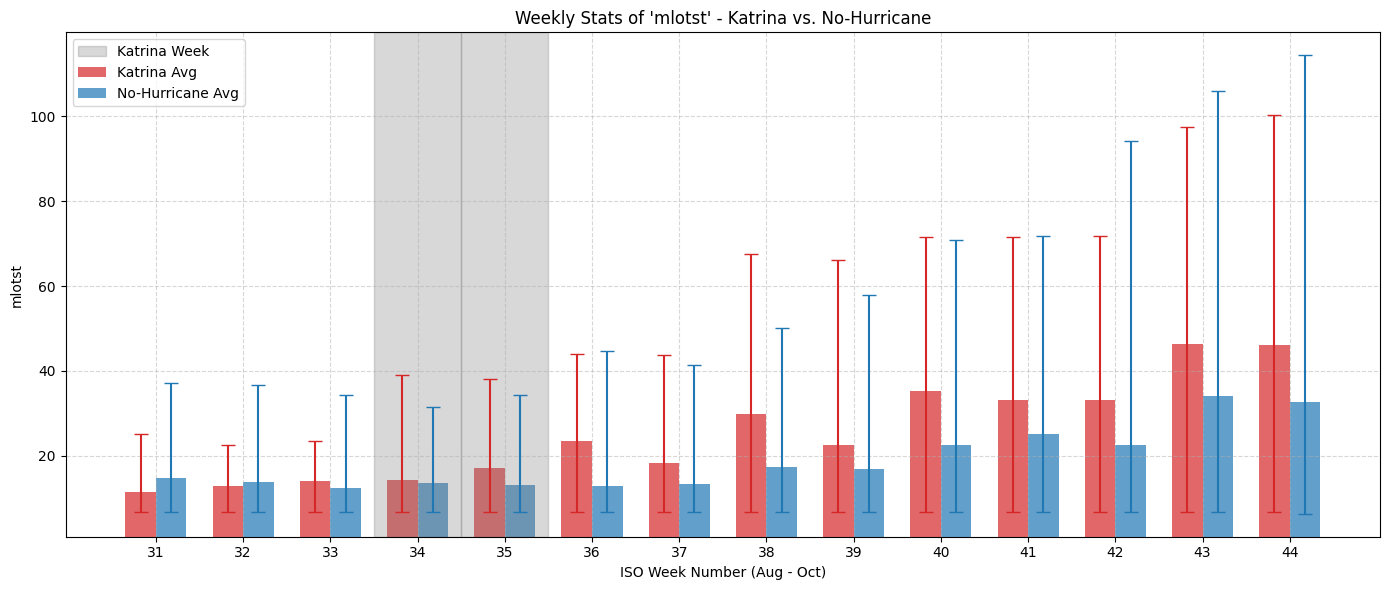

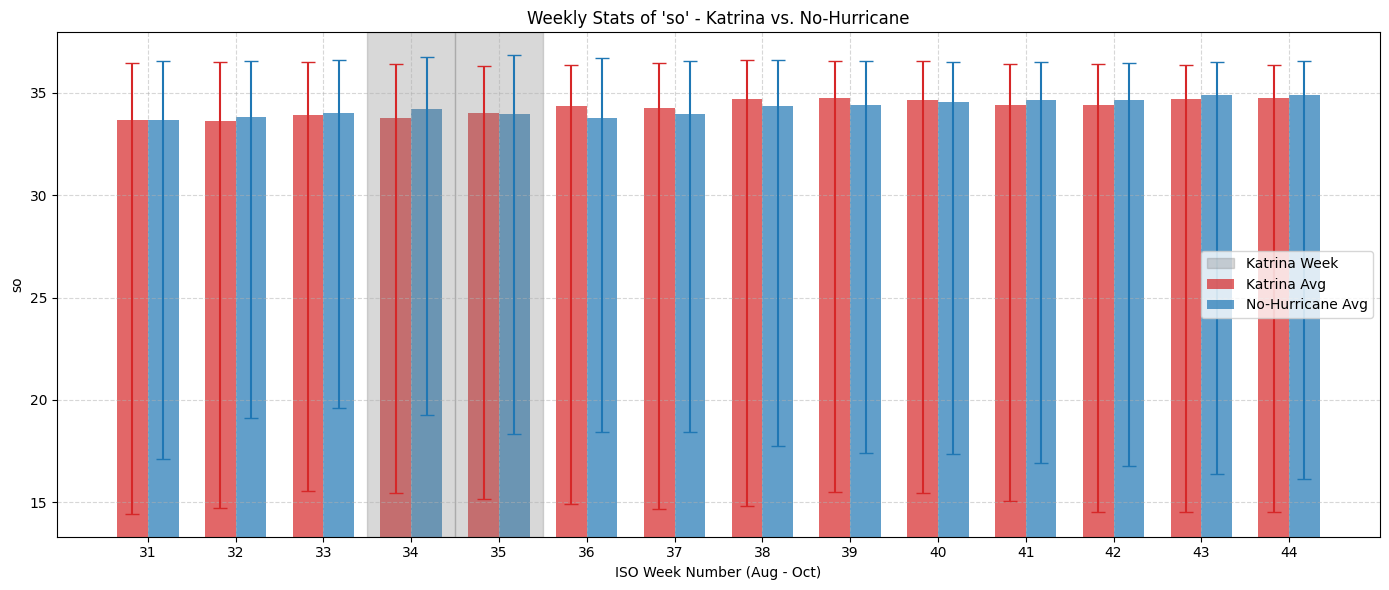

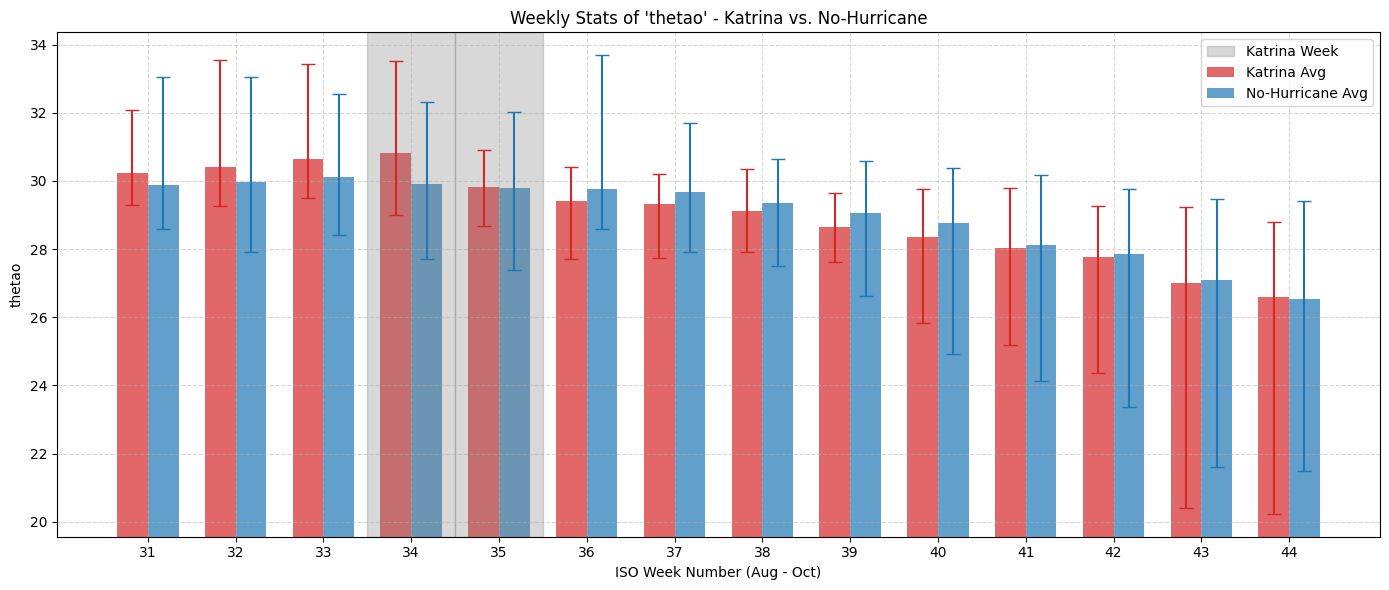

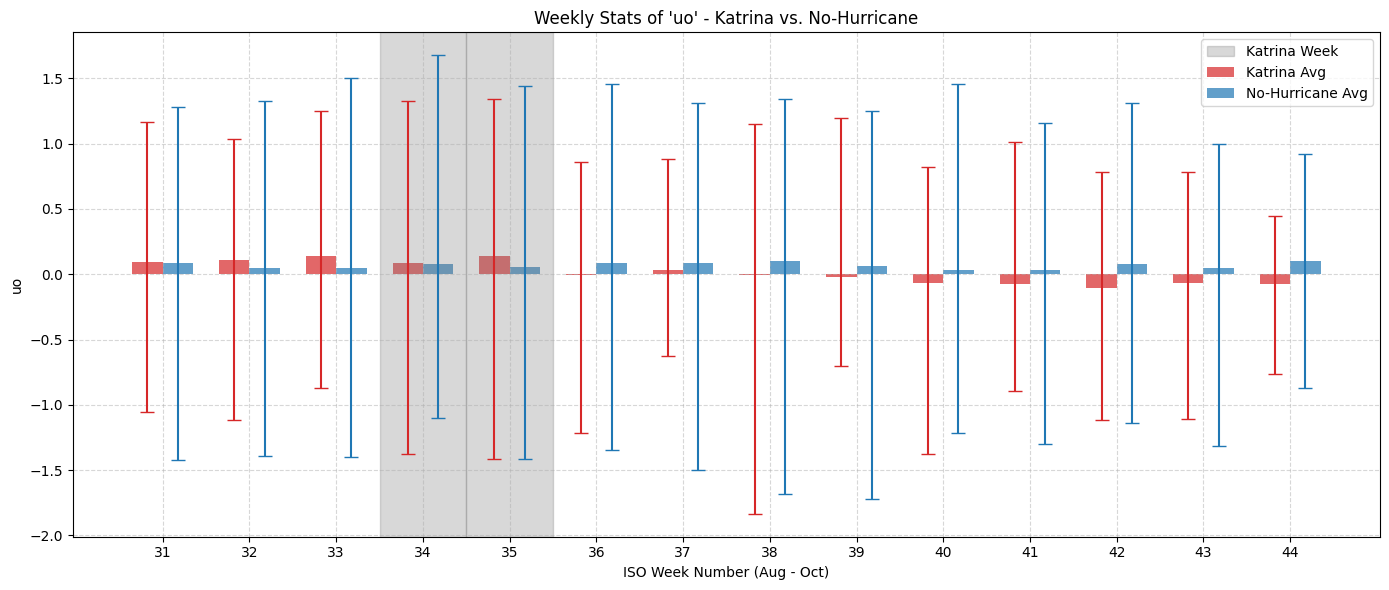

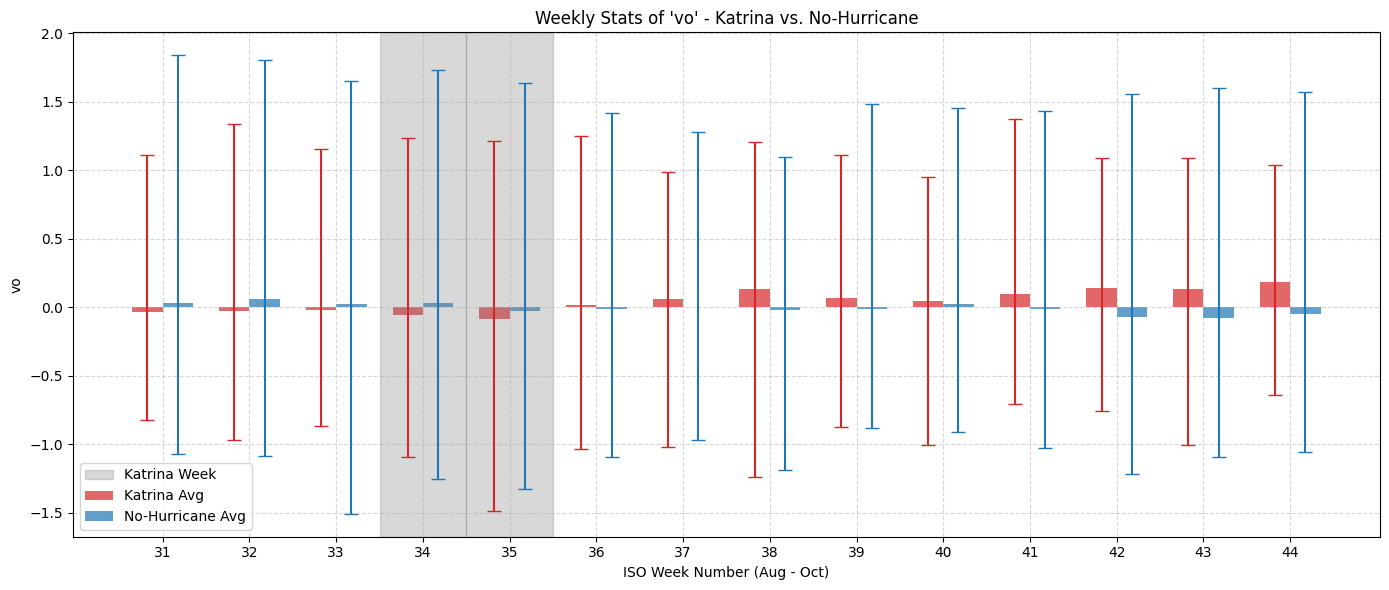

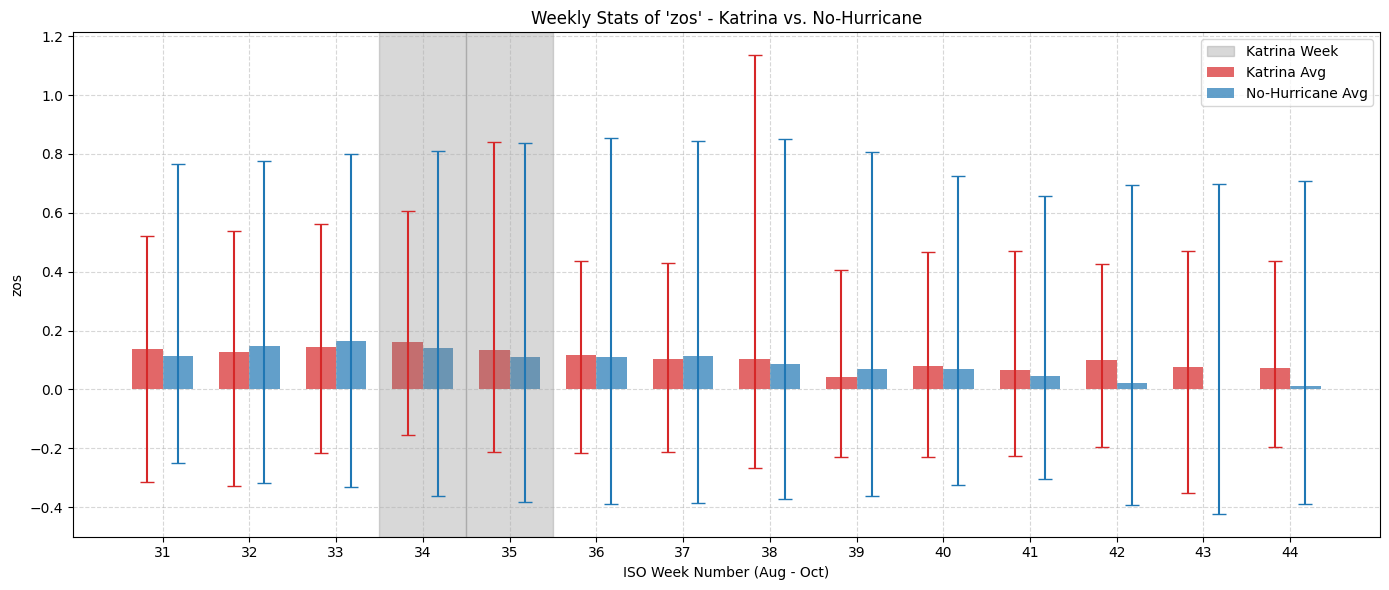

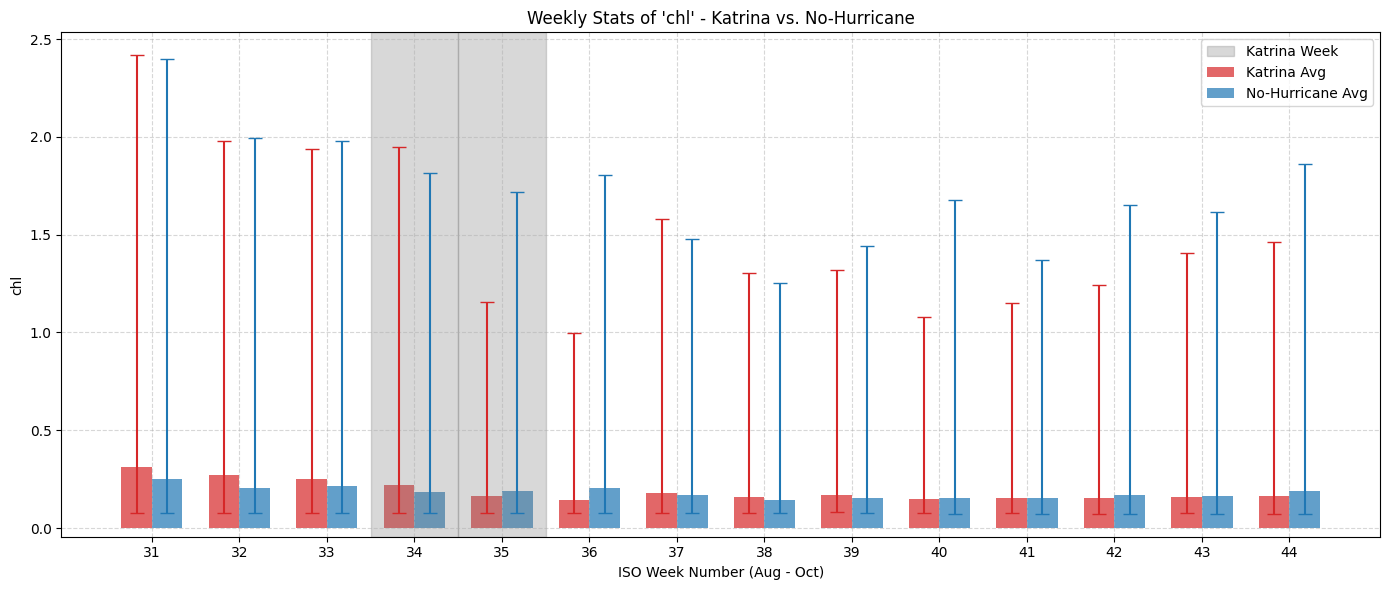

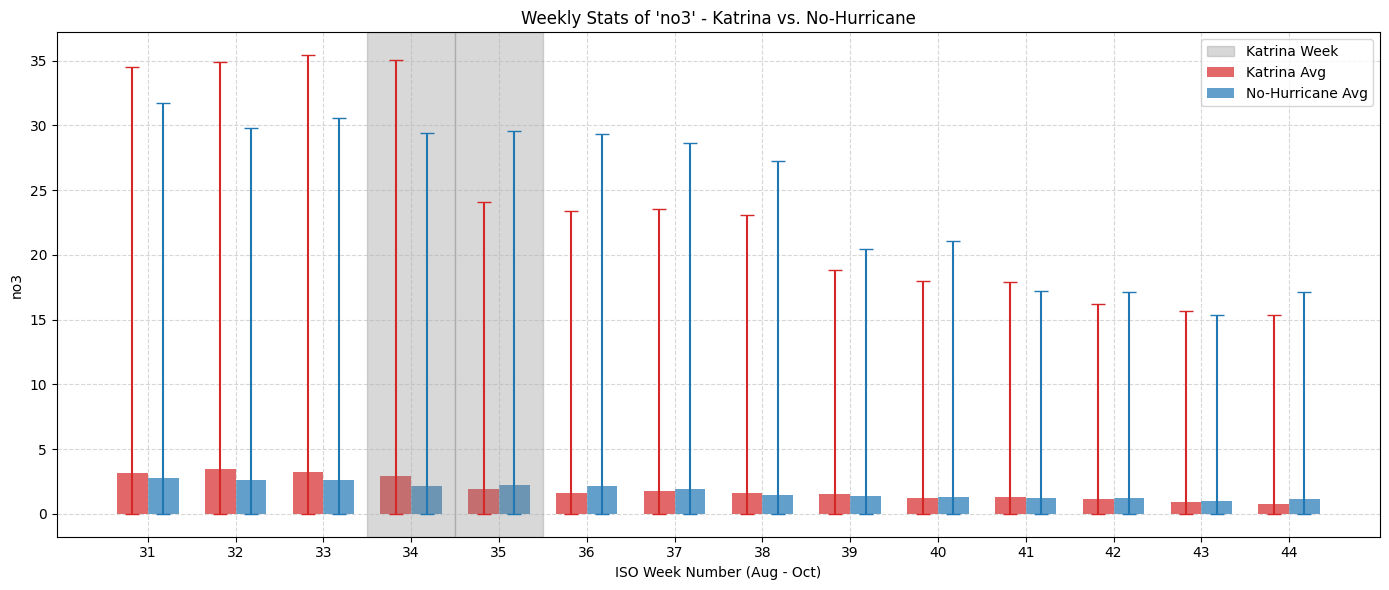

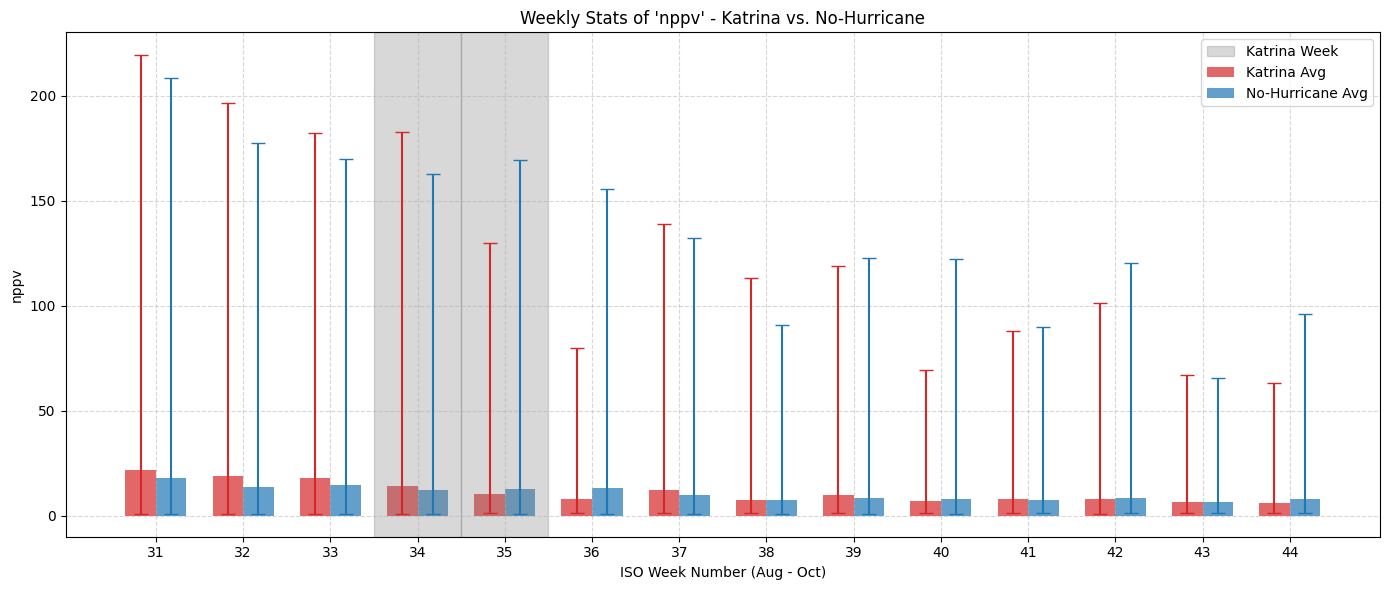

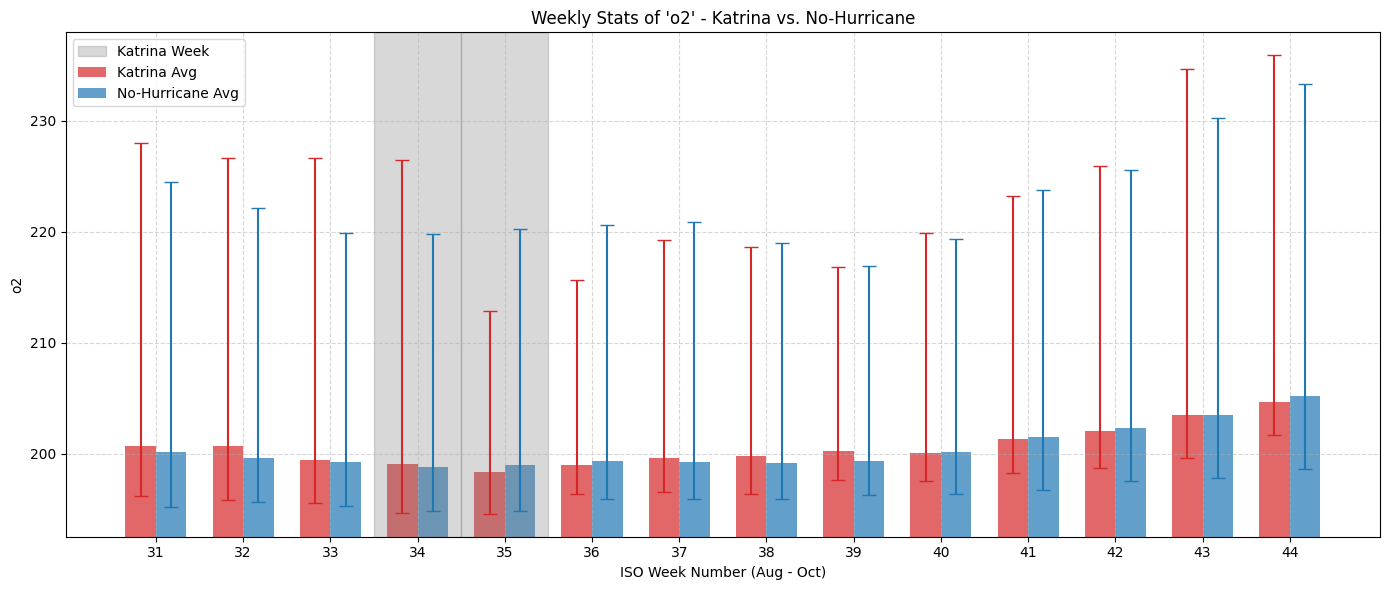

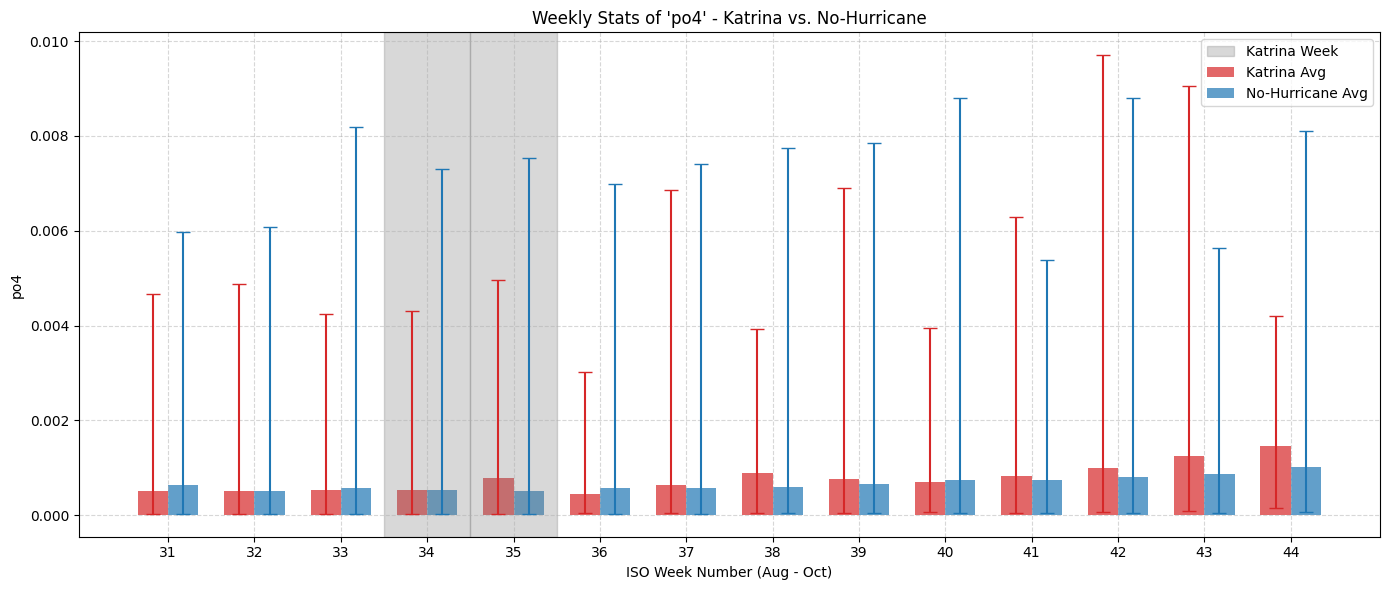

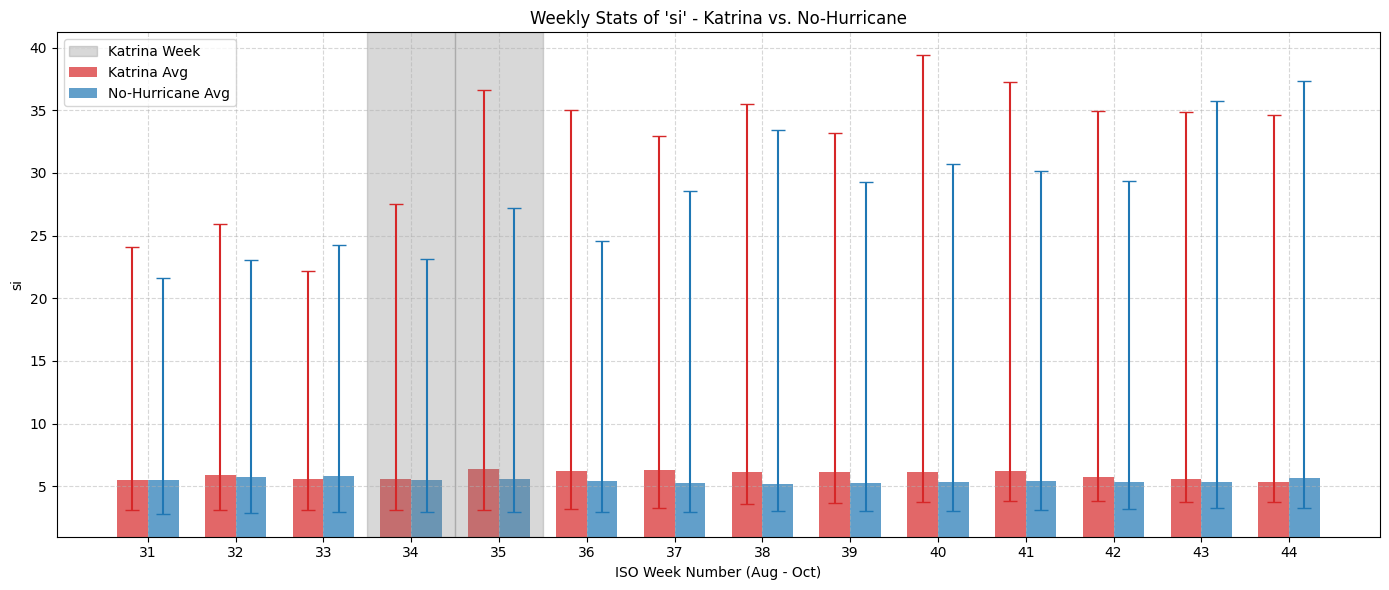

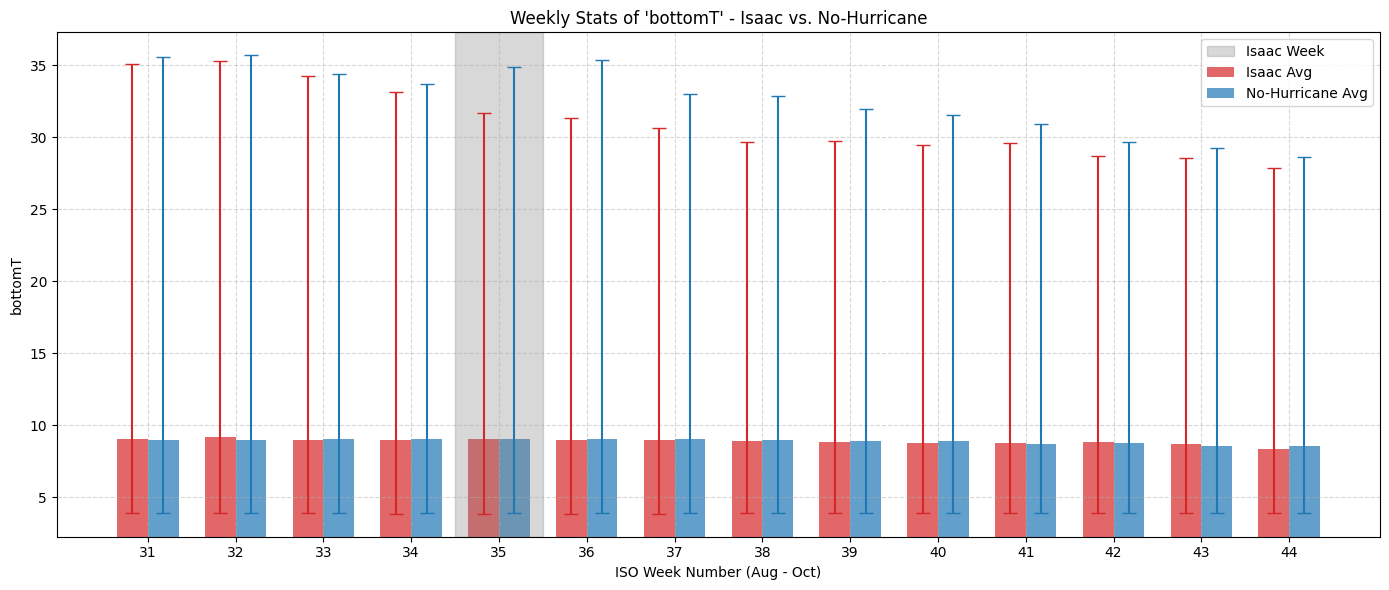

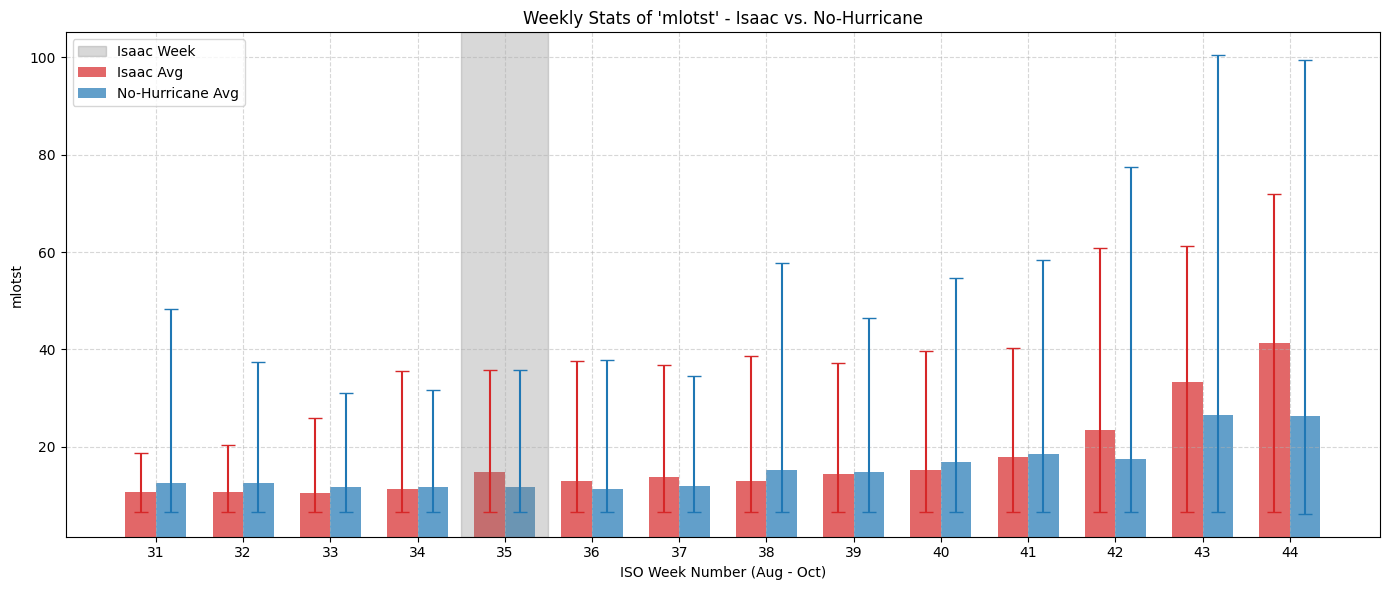

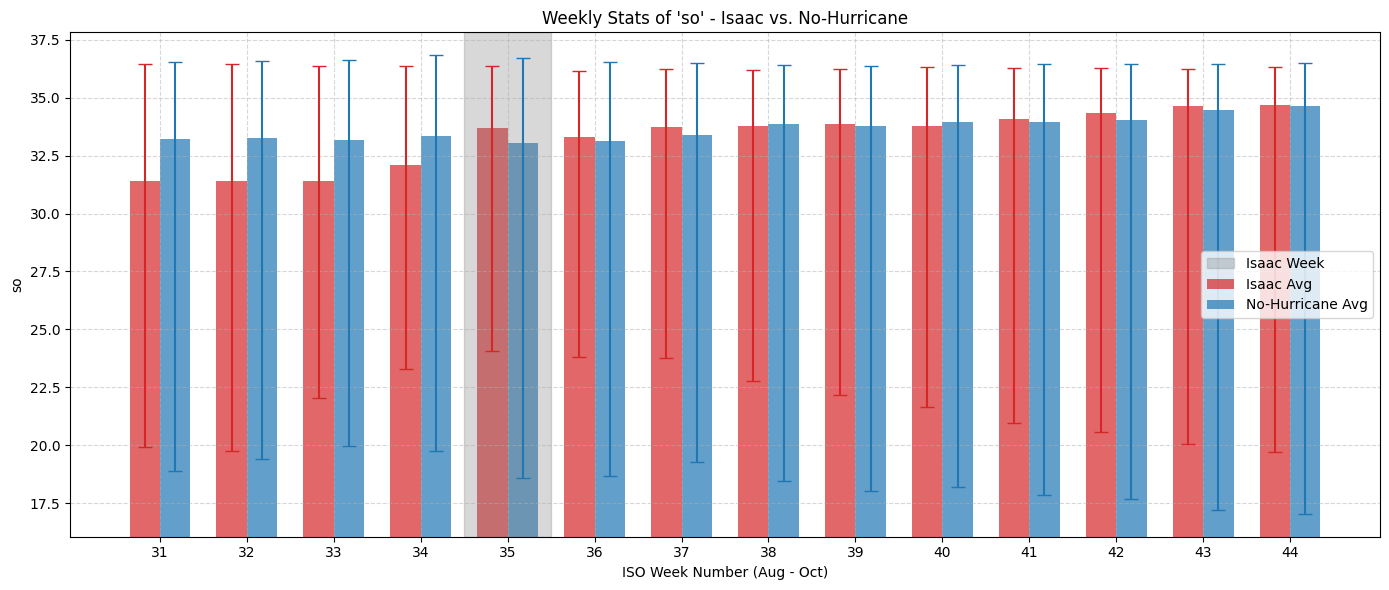

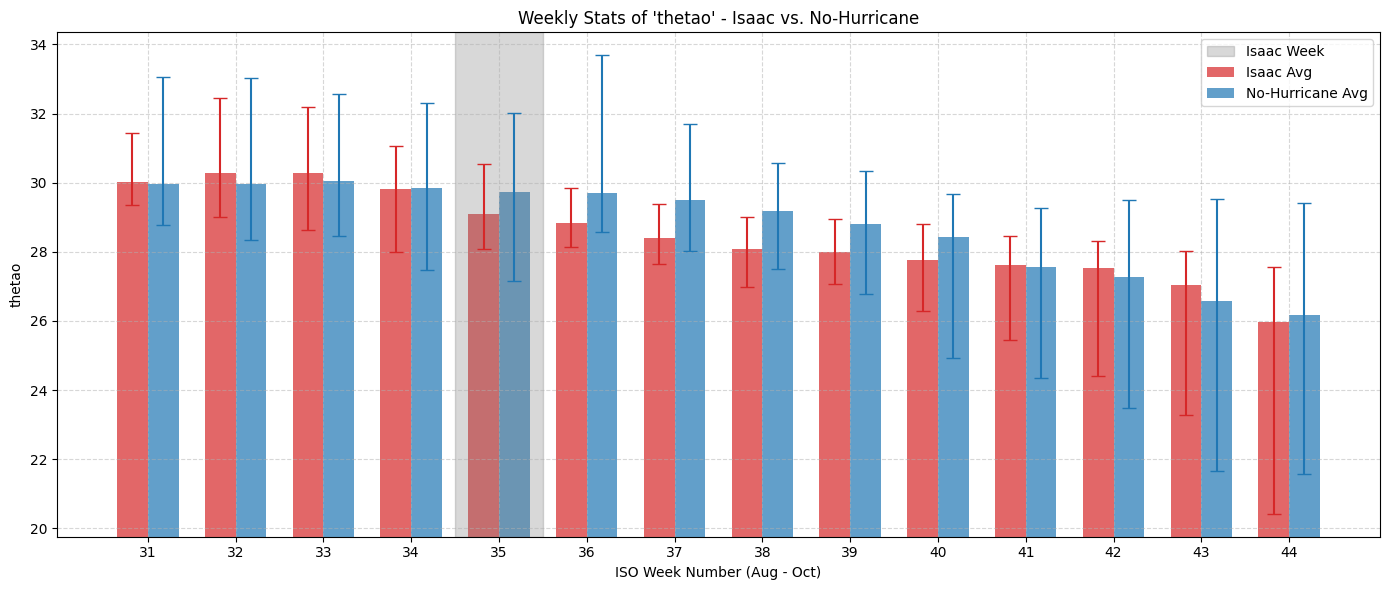

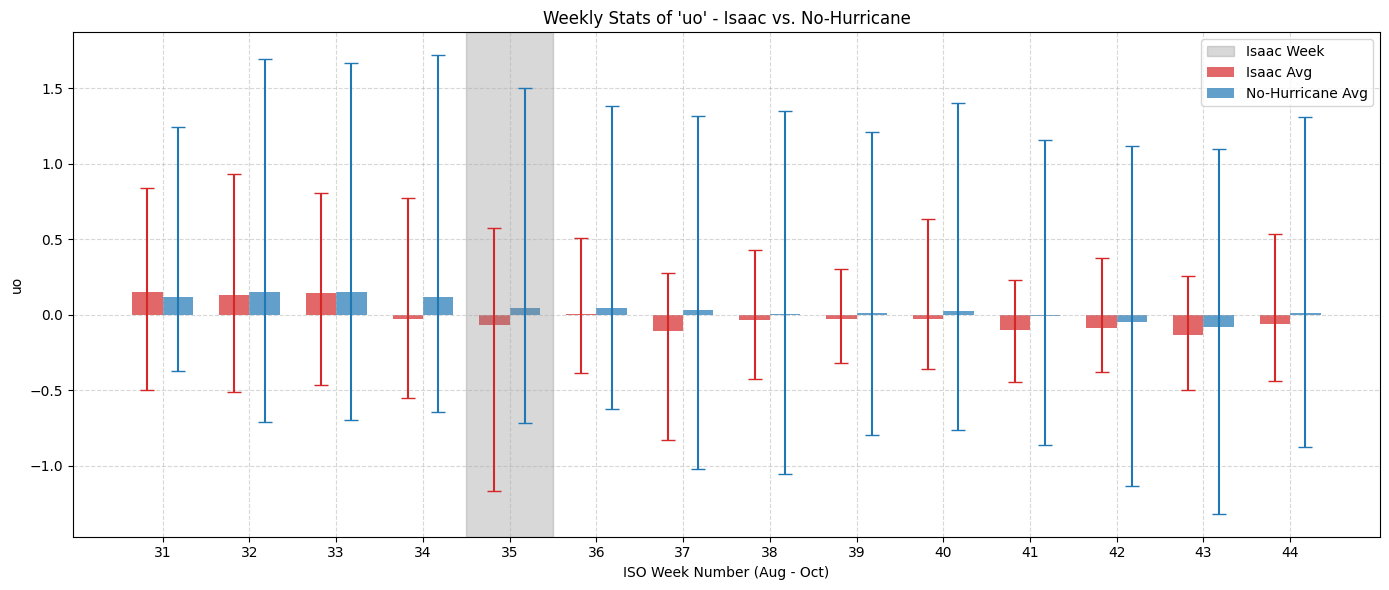

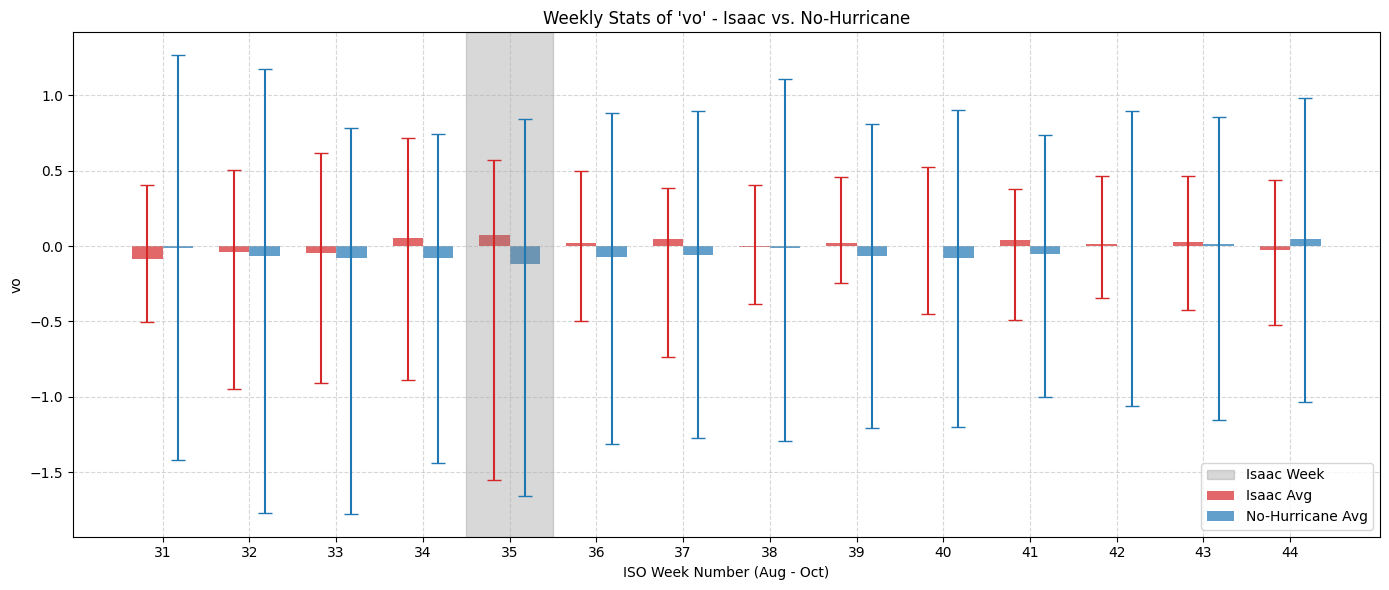

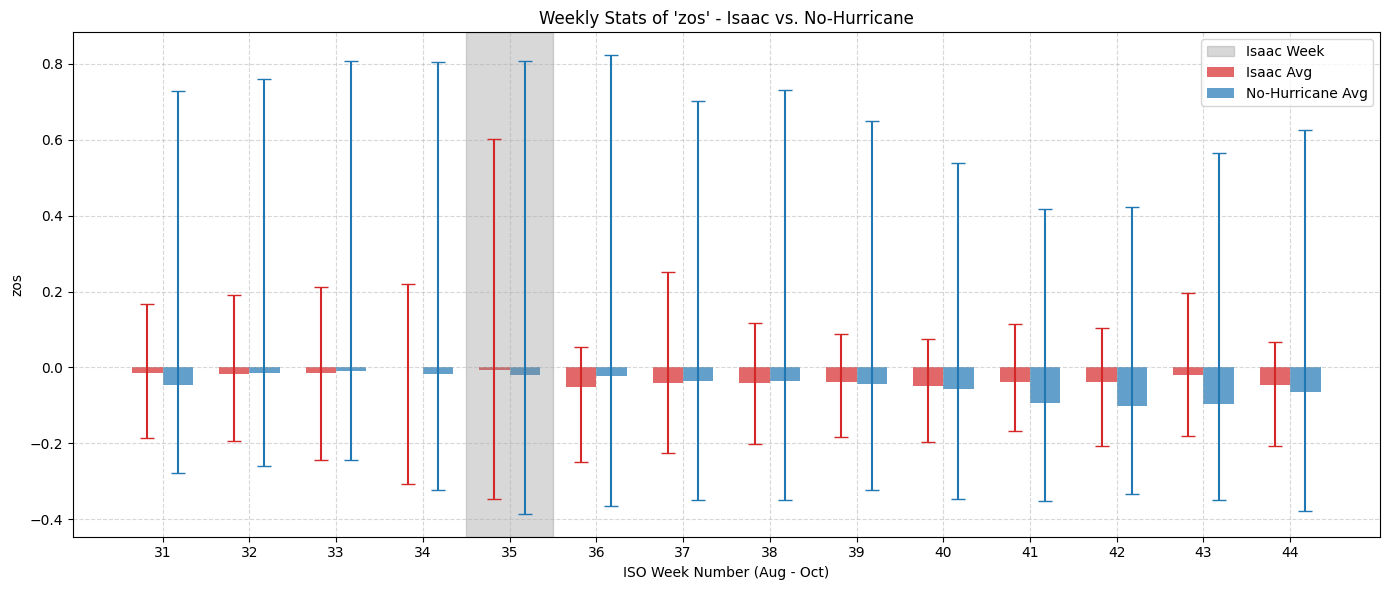

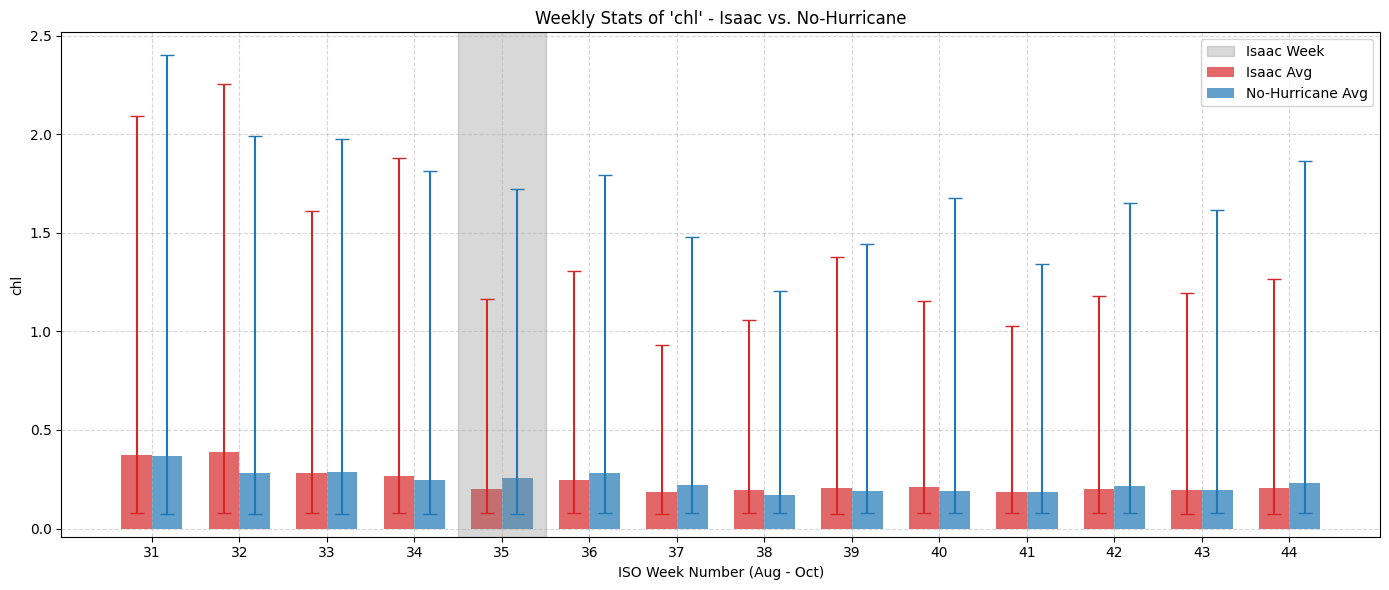

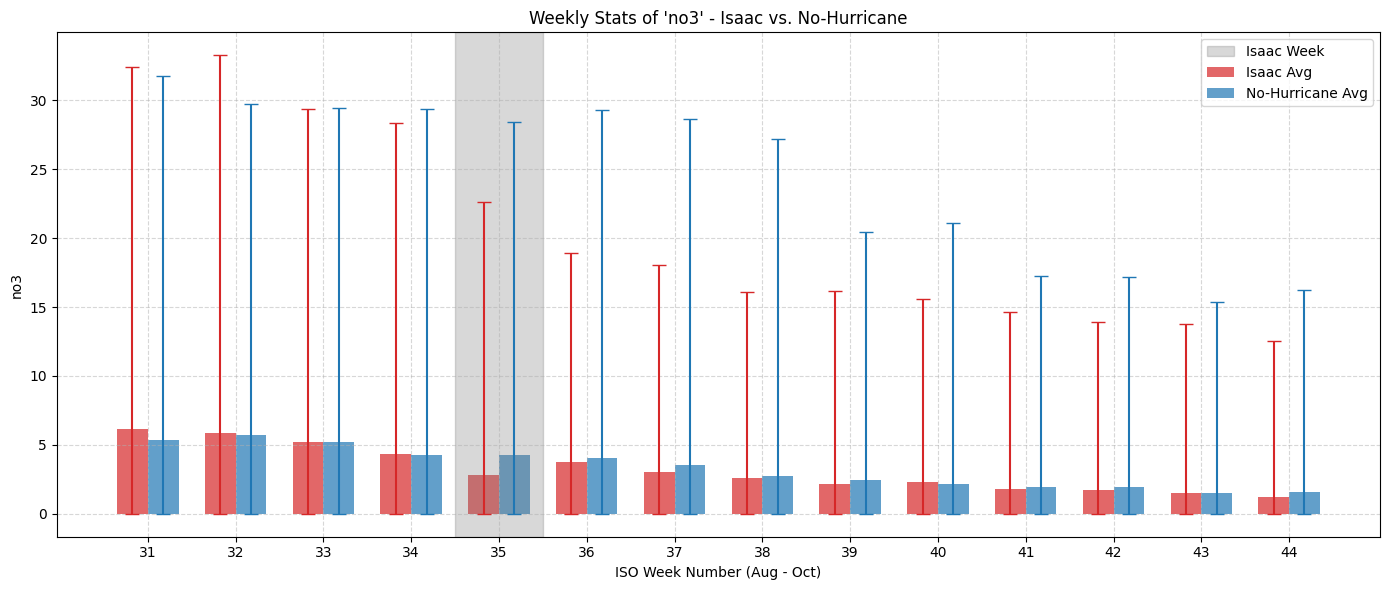

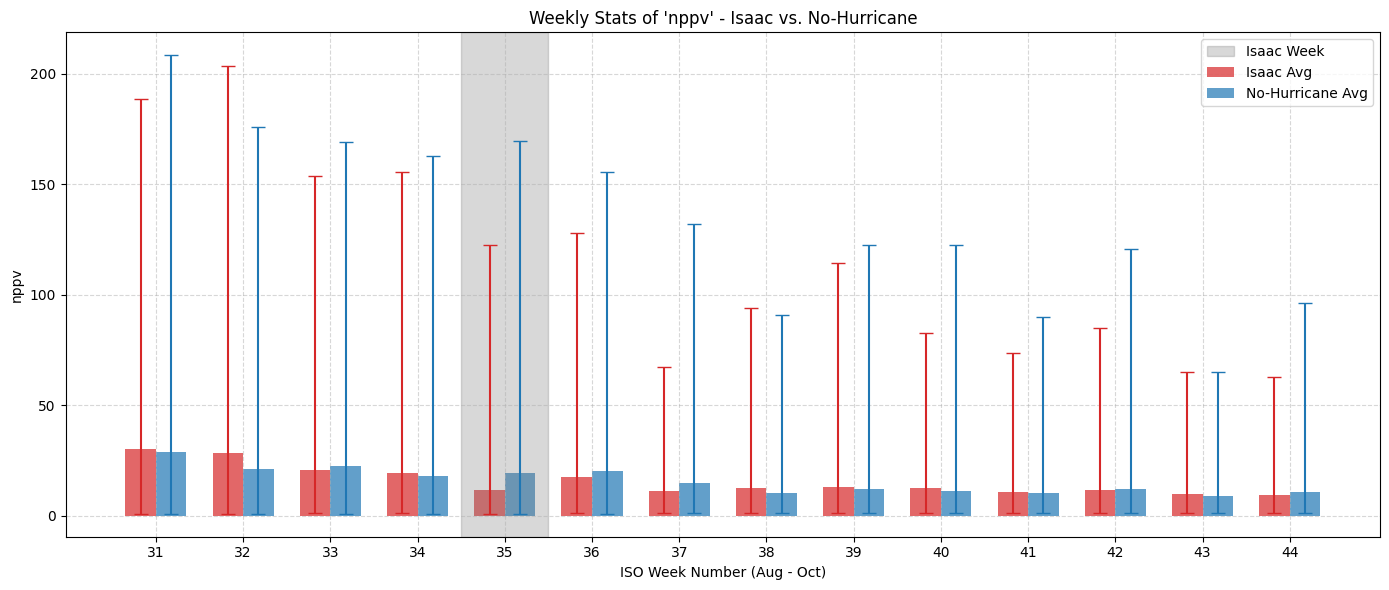

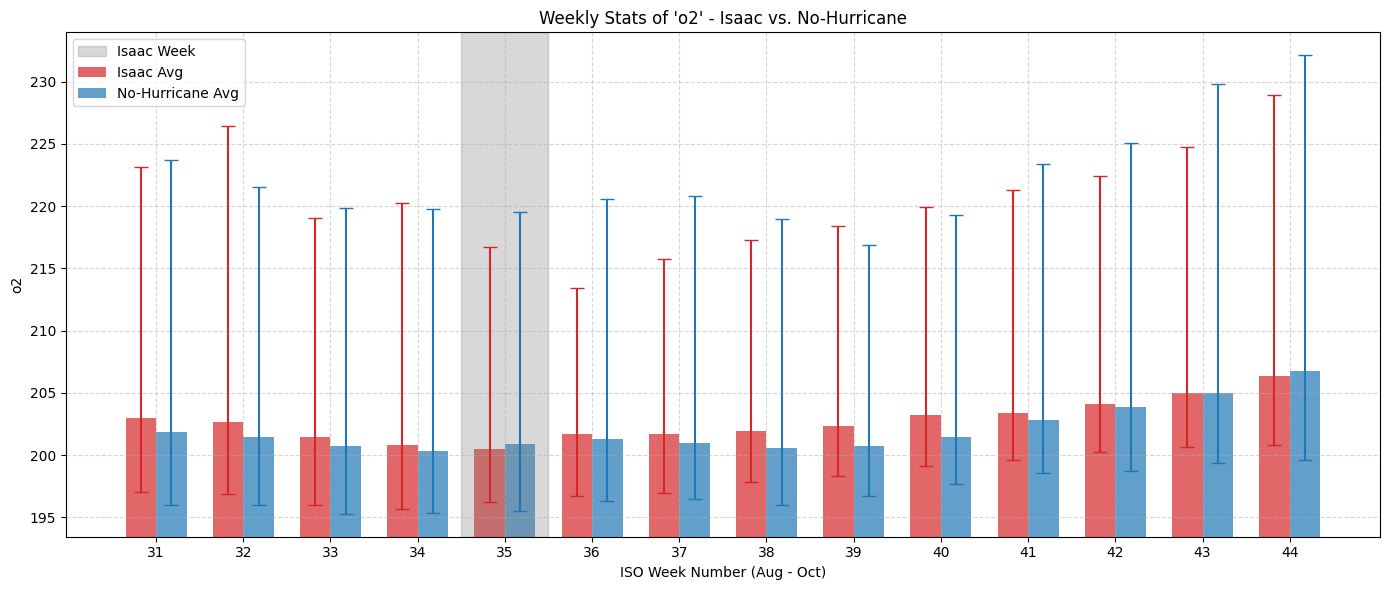

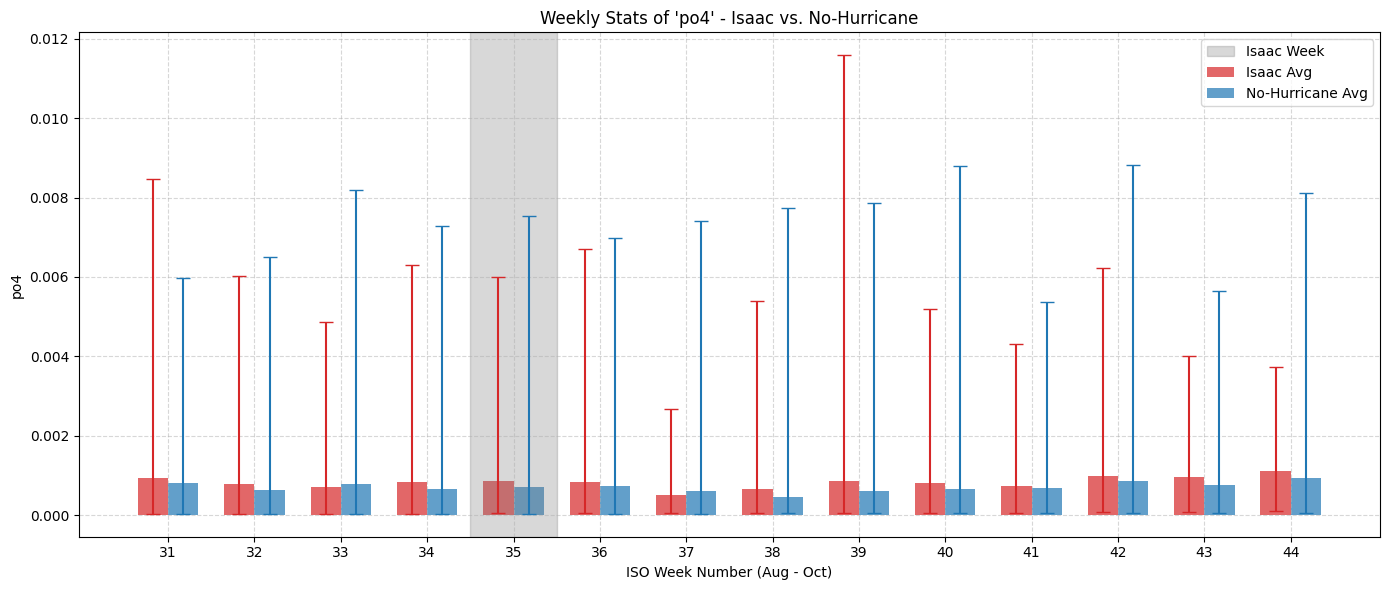

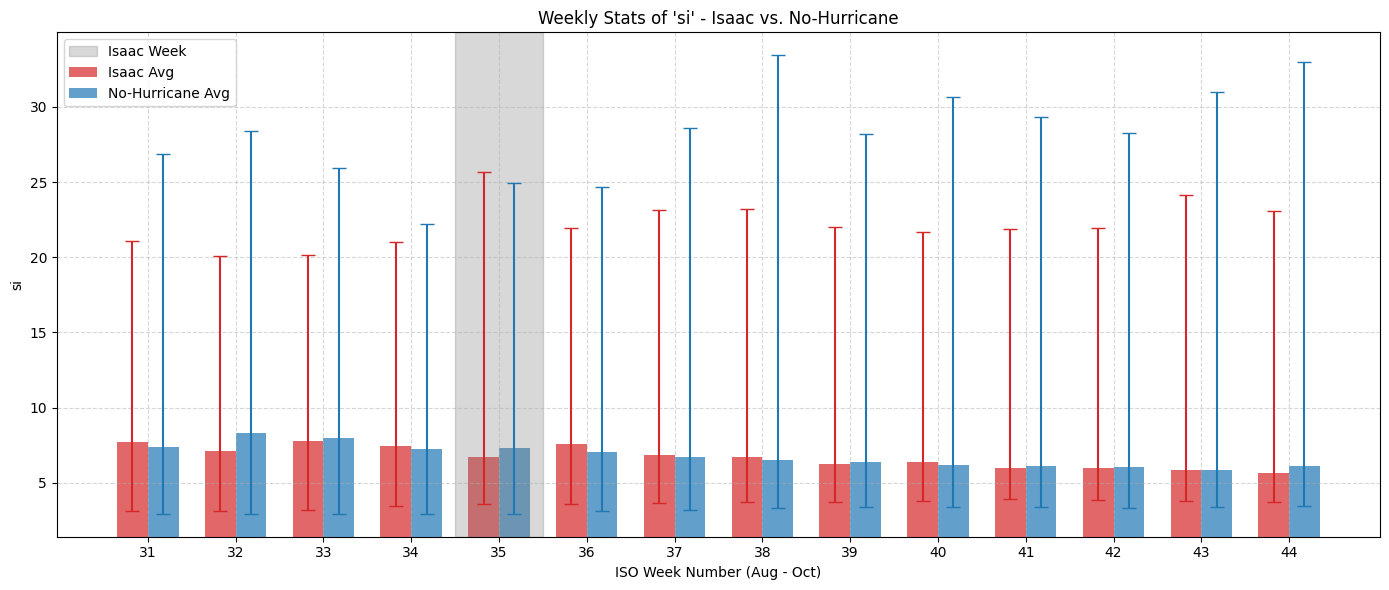

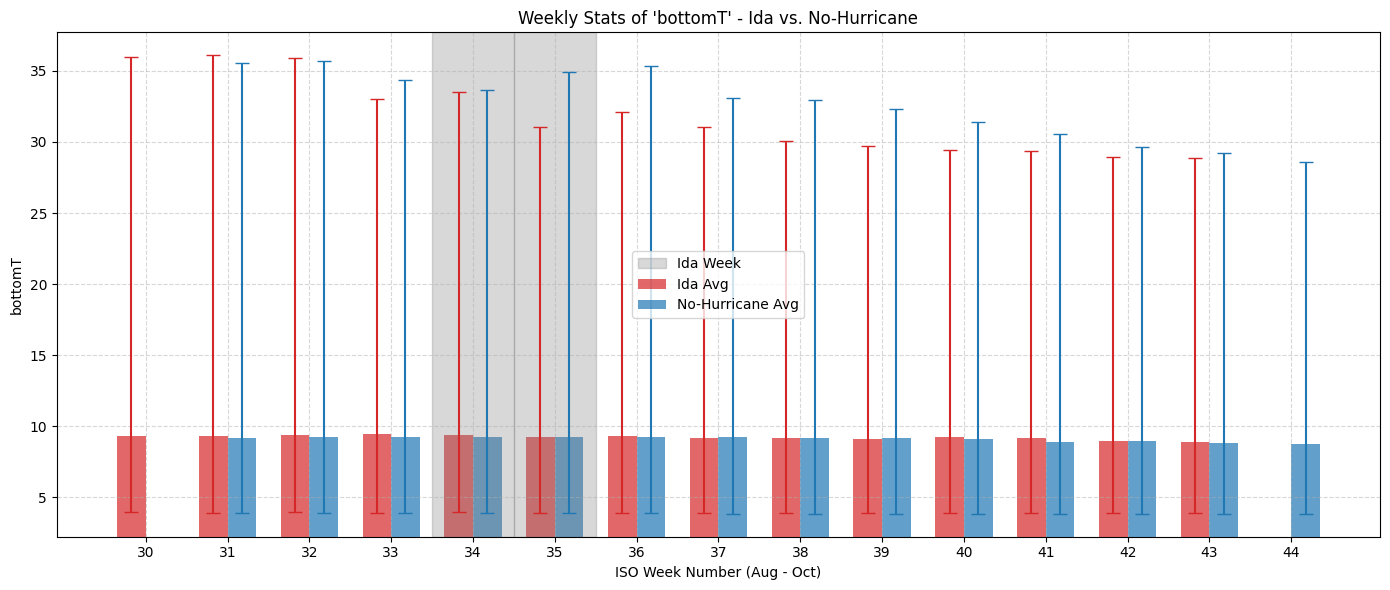

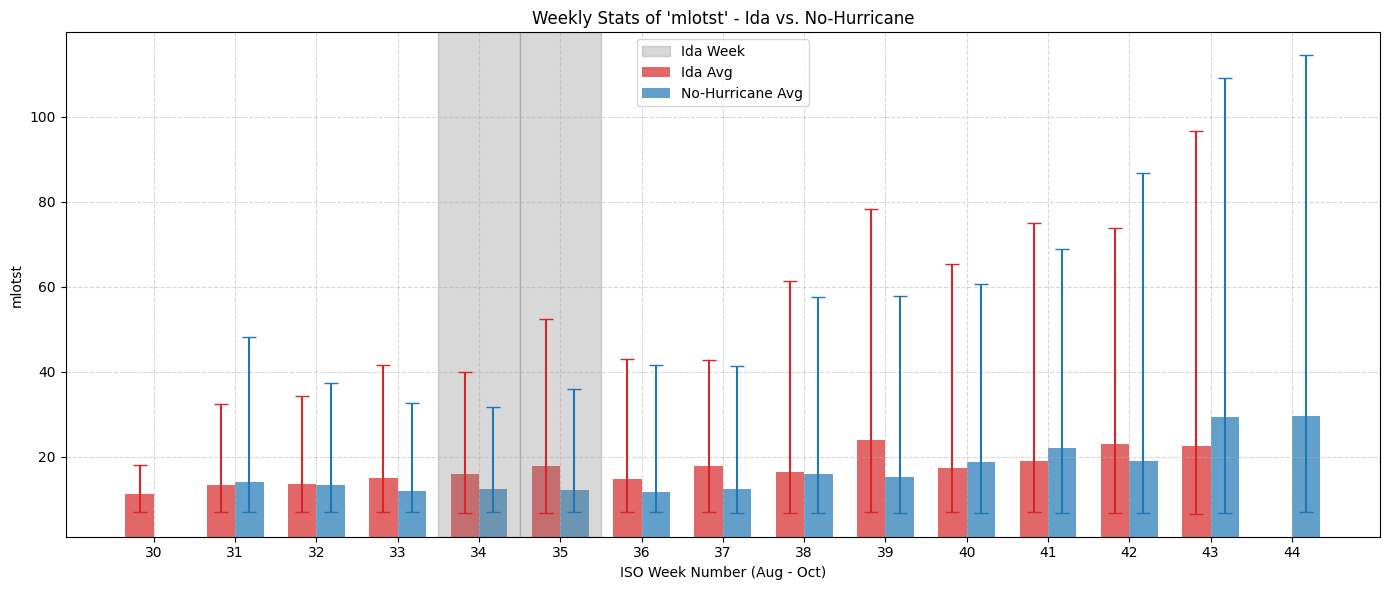

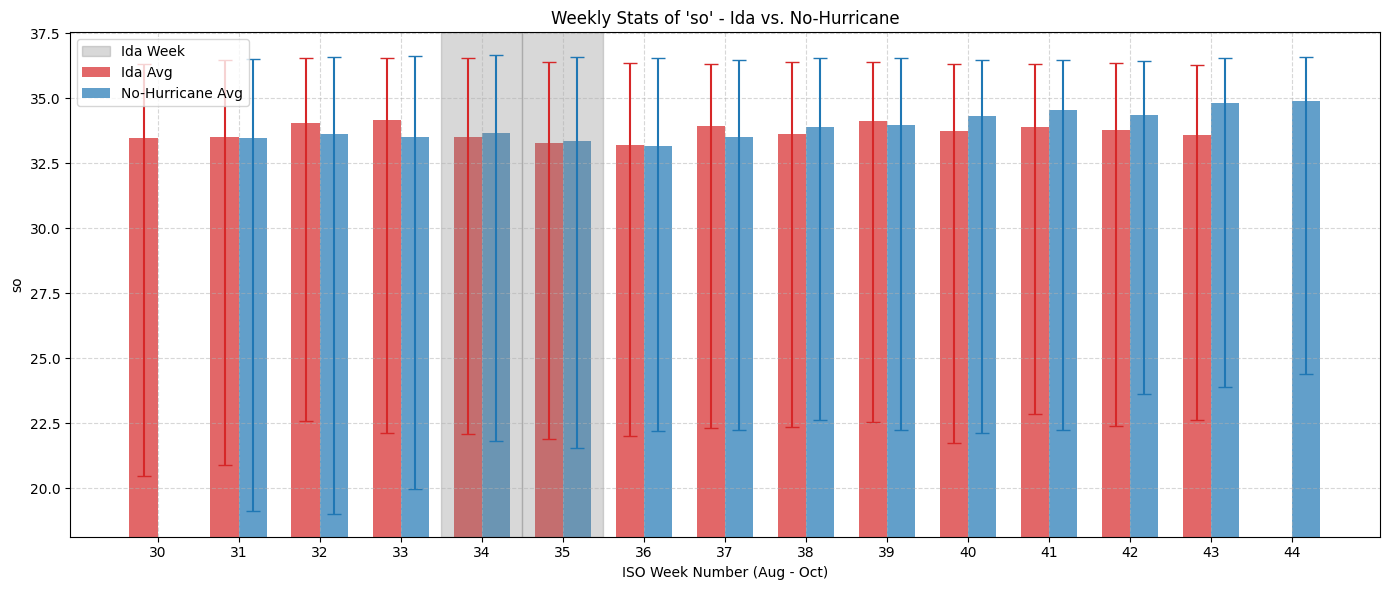

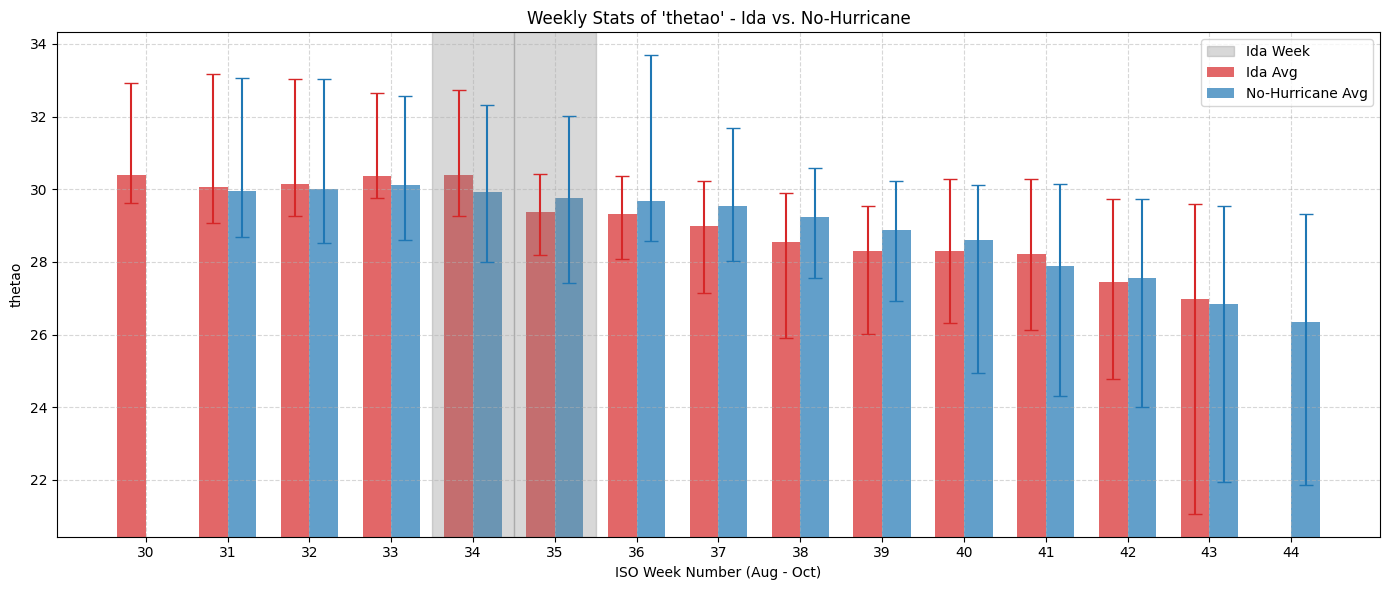

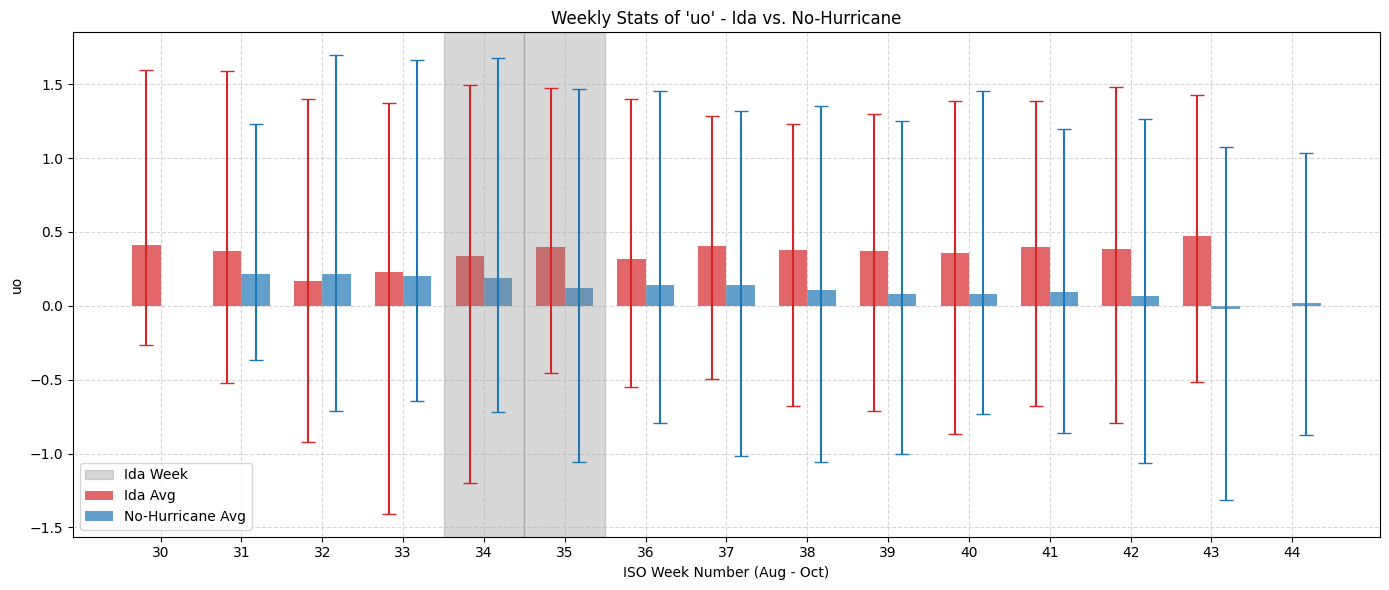

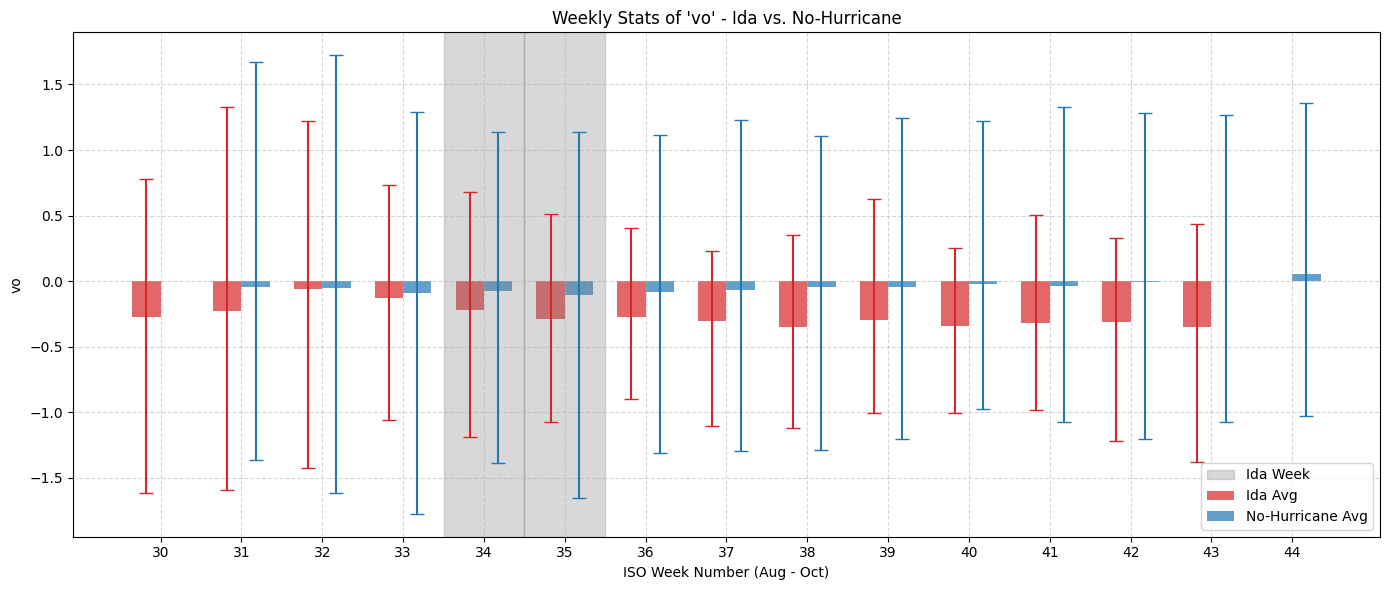

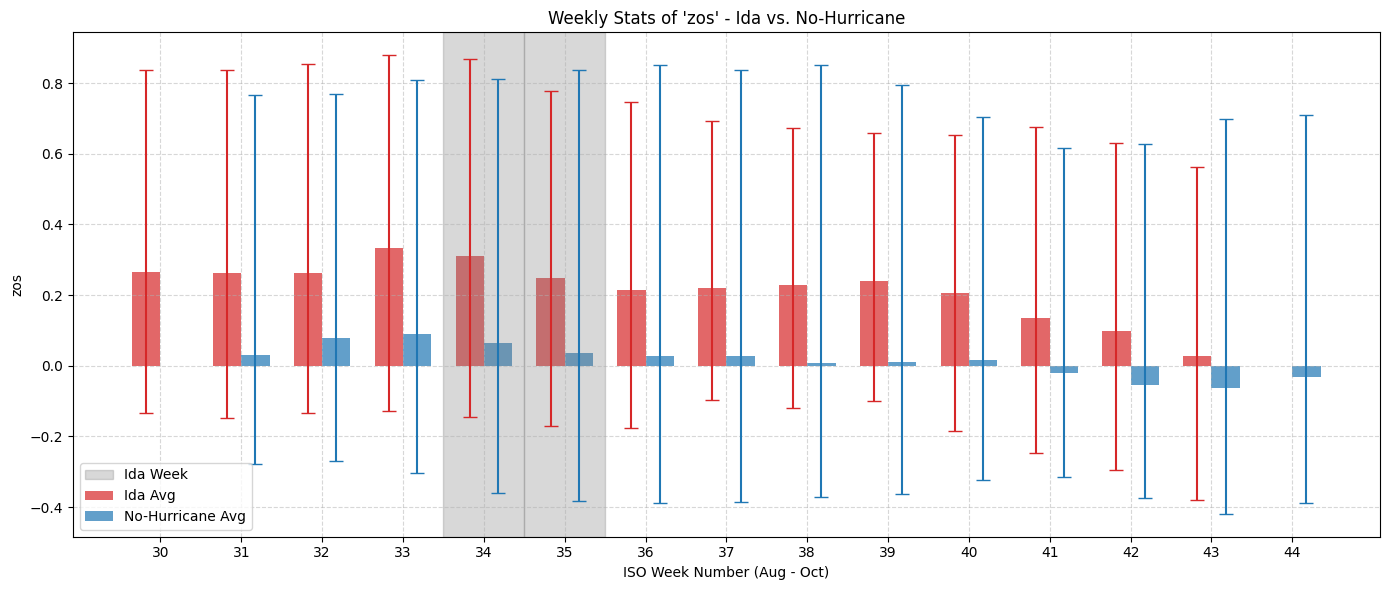

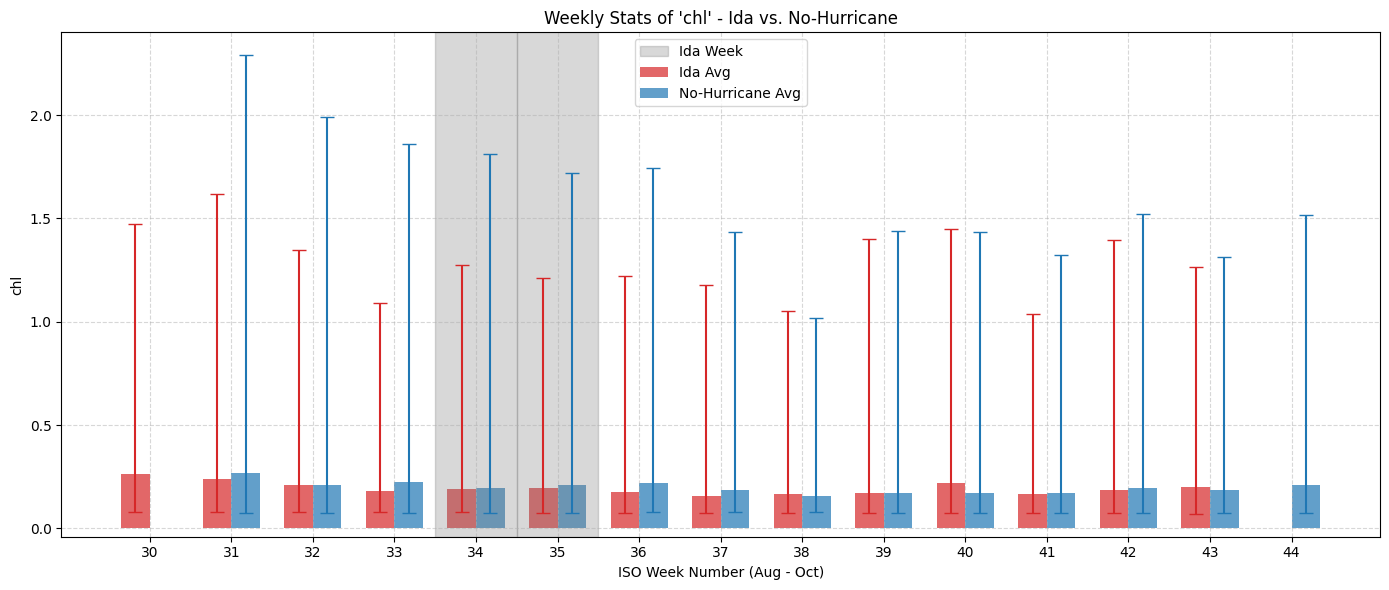

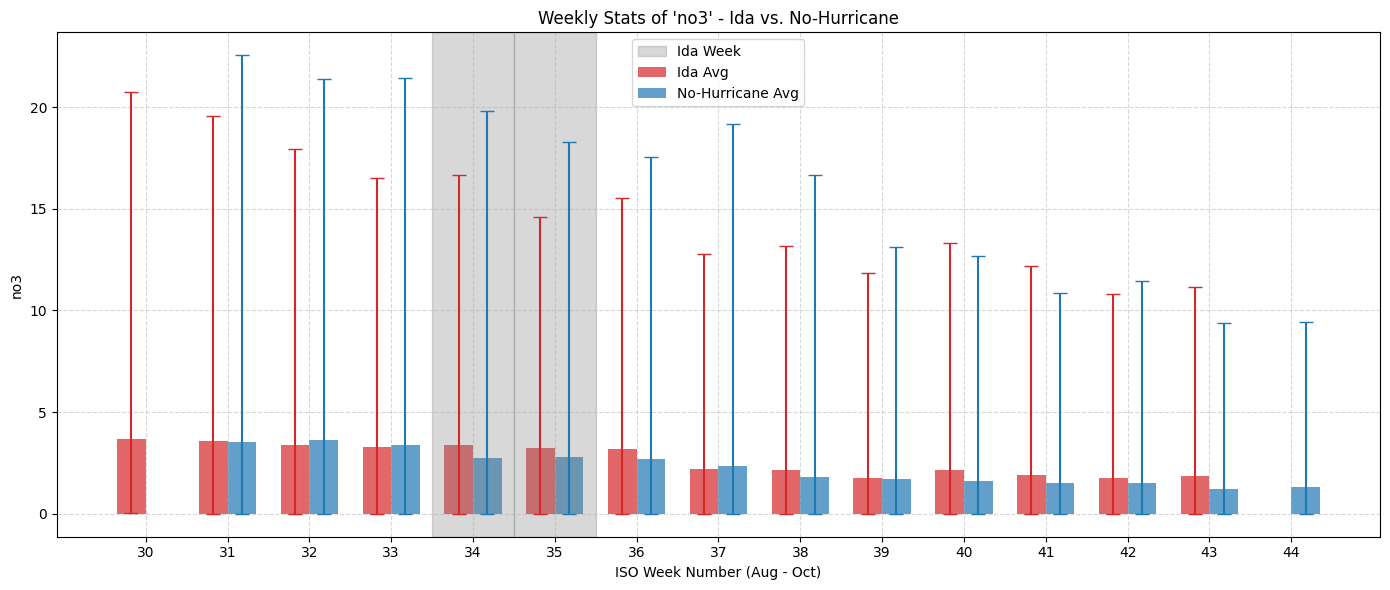

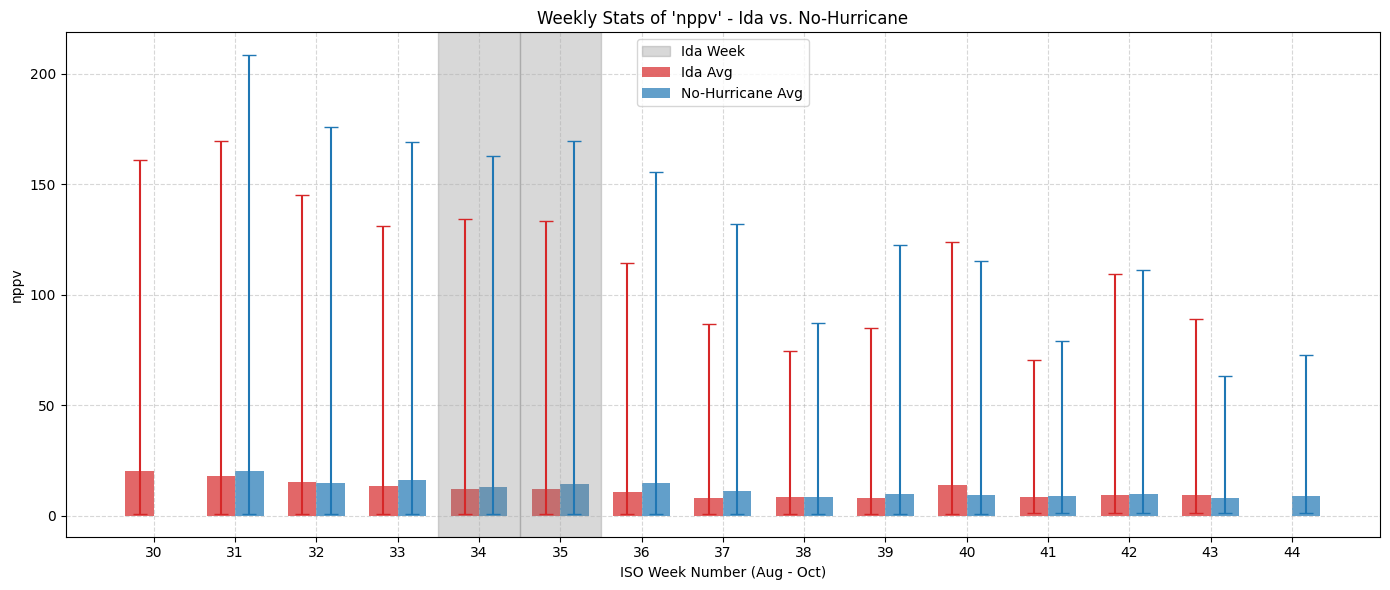

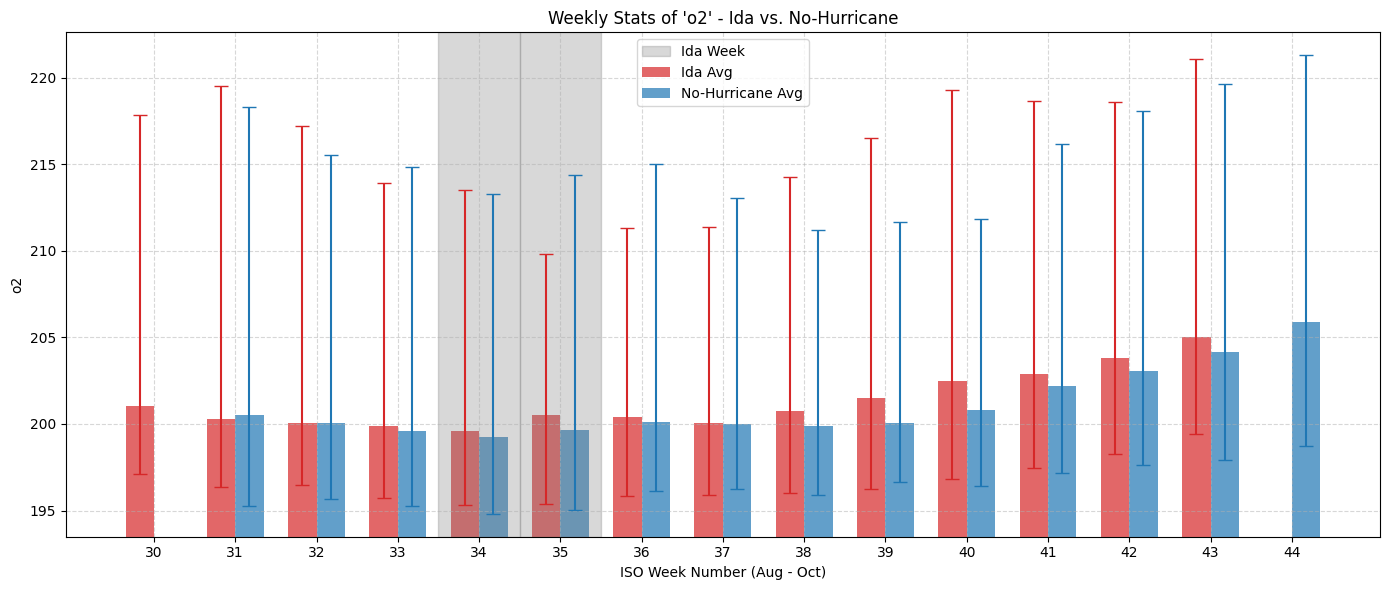

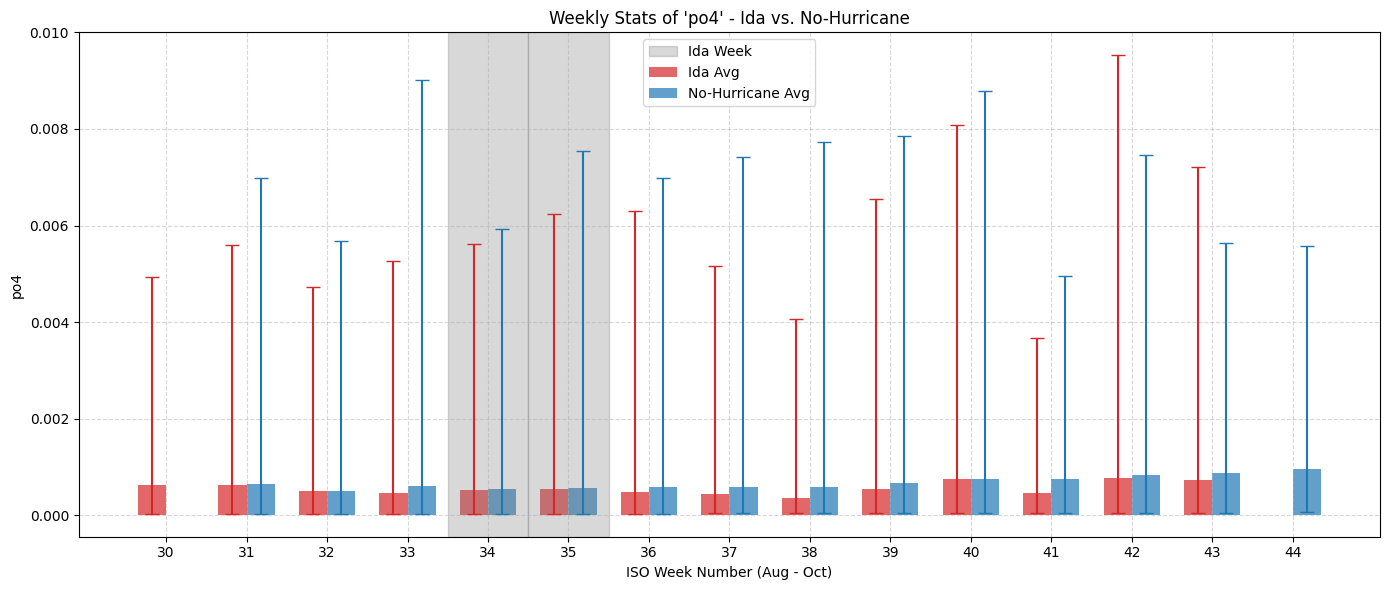

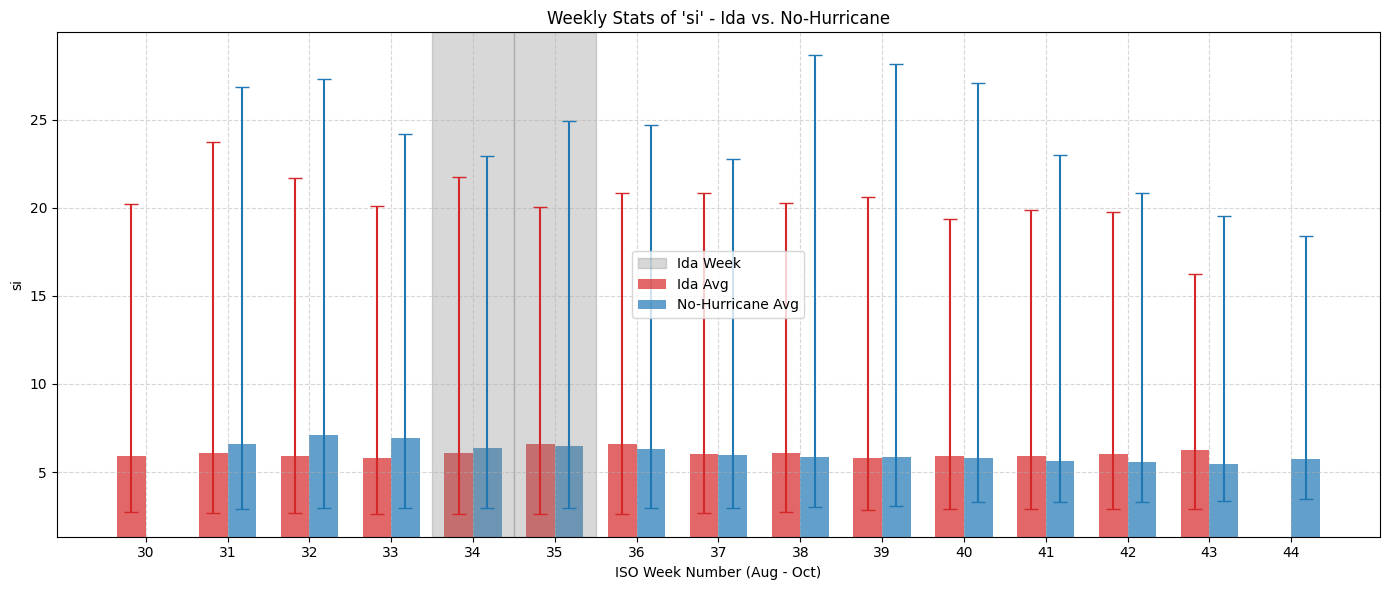

In [16]:
for hurricane in hurricane_names:
    latlon_points = get_latlon_within_radius(ds, hurricane_tracks, hurricane, radius_deg=0.6)
    ds_hurricane = extract_ds_grouped_by_time(ds, latlon_points, years=int(hurricane_tracks[hurricane]['year']))
    ds_no_hurricane = extract_ds_grouped_by_time(ds, latlon_points, years=no_hurricane_years)

    for var in ds.data_vars:
        if var not in ['siconc','sithick','vsi','usi']:
            plot_hurricane_vs_nohurricane(
                ds_hurricane,
                ds_no_hurricane,
                var_name=var,
                hurricane_meta=hurricane_tracks[hurricane],
                hurricane_name=hurricane)
